In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

# Import the libraries

In [2]:
import numpy as np
import pandas as pd
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, LeakyReLU, BatchNormalization, Bidirectional, LSTM, concatenate, Flatten
import time
import datetime

from tensorflow.keras.layers import Lambda

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
yf.pdr_override()
from pandas_datareader import data as pdr

In [3]:
def plot_dataframe(df):
  for column_name in df.columns:
    plt.figure()
    plt.title(column_name)
    plt.plot(df[column_name])

# Preprocessing

In [4]:
def add_Ma(df, window=5):
    for i in range(window, df.shape[0]):
        sum = 0.0
        for k in range(1, window+1):
            sum += df.iloc[i-k, 4]
        df.loc[df.index[i], 'Ma'] = np.round(sum/window, 6)
    return df[window:]

In [5]:
class Standarized_TimeseriesGenerator(tf.keras.preprocessing.sequence.TimeseriesGenerator):
  def __getitem__(self, index):
    samples, targets  = super(Standarized_TimeseriesGenerator, self).__getitem__(index)
    mean = samples.mean(axis=1)
    std = samples.std(axis=1)
    samples = (samples - mean[:,None,:])/std[:,None,:]
    targets = (targets - mean)/std
    return samples, targets

In [6]:
def get_gen_train_test(dataframe, n_sequence, n_batch):
    data = dataframe.drop(columns='Date').to_numpy()
    targets = data
    n_samples = data.shape[0]
    train_test_split=int(n_samples*0.9)

    data_gen_train = Standarized_TimeseriesGenerator(data, targets,
                                length=n_sequence, sampling_rate=1,
                                stride=1, batch_size=n_batch,
                                start_index = 0,
                                end_index = train_test_split,
                                shuffle = True)
    data_gen_test = Standarized_TimeseriesGenerator(data, targets,
                                length=n_sequence, sampling_rate=1,
                                stride=1, batch_size=n_batch,
                                start_index = train_test_split,
                                end_index = n_samples-1)

    return data_gen_train, data_gen_test

# Baseline

In [7]:
def mean_squared_error(X, lenght = 5):
    squared_error = 0
    for i in range(0, X.shape[0] - lenght):
        x = X[i:i+lenght]
        mean = x.mean()
        std = x.std()
        x = (x - mean)/std
        y = (X[i+lenght] - mean)/std
        squared_error += np.square(x[-1]-y)
    return squared_error/X.shape[0]

In [8]:
# For generated data
def mean_squared_error(dataset):
    mse=0
    for X_batch, y_batch in dataset:
        mse += np.mean(np.square(X_batch[:, -1, 3:4]-y_batch[:, 3:4]))
    mse /= len(dataset)
    return mse

# Utilities

In [9]:
def mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true[:,3]-y_pred[:,3]))
def mae(y_true, y_pred):
    return tf.reduce_mean(tf.keras.backend.abs((y_true[:,3]-y_pred[:,3])))
    # ***The absolute is over the whole thing as y_true can be negative
def mape(y_true, y_pred):
    return tf.reduce_mean(tf.keras.backend.abs((y_true[:,3]-y_pred[:,3])/y_true[:,3]))
    # ***The absolute is over the whole thing as y_true can be negative
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true[:,3]-y_pred[:,3])))
def ar(y_true, y_pred):
    mask = tf.cast(y_pred[1:,3] > y_true[:-1,3],tf.float32)
    return tf.reduce_mean((y_true[1:,3]-y_true[:-1,3])*mask)

# GAN

## Perdidas

In [10]:
def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(x, y, fake_output):
    a1=0.01
    g_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
    g_mse = tf.keras.losses.MSE(x, y)
    return a1*g_mse + (1-a1)*g_loss, g_mse

## Generator

In [11]:
def make_generator_model(n_sequence, n_features):
    inputs = Input(shape=(n_sequence, n_features,))
    
    # Define the first Densely Connected Bidirectional LSTM layer
    lstm_1 = Bidirectional(LSTM(units=10, return_sequences=True, activation=None, kernel_initializer='random_normal', dropout=0.3))(inputs)
    lstm_1_batch_norm = BatchNormalization()(lstm_1)
    lstm_1_LRelu = LeakyReLU(alpha=0.3)(lstm_1_batch_norm)
    lstm_1_dropout = Dropout(0.3)(lstm_1_LRelu)
    
    # Define the second Densely Connected Bidirectional LSTM layer
    lstm_2_input = concatenate([lstm_1, inputs], axis=2)
    lstm_2 = Bidirectional(LSTM(units=10, return_sequences=False, activation=None, kernel_initializer='random_normal', dropout=0.3))(lstm_2_input)
    lstm_2_batch_norm = BatchNormalization()(lstm_2)
    lstm_2_LRelu = LeakyReLU(alpha=0.3)(lstm_2_batch_norm)
    lstm_2_dropout = Dropout(0.3)(lstm_2_LRelu)
    
    # Define the output layer
    output_dense = Dense(n_features, activation=None)(lstm_2_dropout)
    output = LeakyReLU(alpha=0.3)(output_dense)
    
    # Define the model
    model = Model(inputs=inputs, outputs=output)
    model.compile(loss=None, metrics=[mse, mae, mape, rmse, ar])
    model.summary()
    
    return model

## Discriminator

In [12]:
def make_discriminator_model(n_features):
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(units=72, input_shape=((n_sequence+1) * n_features,), activation=None, kernel_initializer='random_normal'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    model.add(tf.keras.layers.GaussianNoise(stddev=0.2))
    model.add(Dropout(0.3))
    model.add(Dense(units=100, activation=None, kernel_initializer='random_normal'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    model.add(Dropout(0.3))
    model.add(Dense(units=10, activation=None, kernel_initializer='random_normal'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    model.add(Dropout(0.3))
    model.add(Dense(1 ,activation='sigmoid'))
    model.compile(loss=discriminator_loss)
    return model

# Training

In [13]:
def train_step_def(sequences, sequences_end):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_prediction = generator(sequences, training=True)

        sequences_true = tf.concat((sequences, sequences_end[:, None, :]), axis=1)
        sequences_fake = tf.concat((sequences, generated_prediction[:, None, :]), axis=1)

        real_output = discriminator(sequences_true, training=True)
        fake_output = discriminator(sequences_fake, training=True)

        gen_loss, gen_mse_loss = generator_loss(generated_prediction, 
                                                sequences_end, 
                                                fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return tf.reduce_mean(gen_loss), tf.reduce_mean(disc_loss), tf.reduce_mean(gen_mse_loss)

def test_step_def(sequences, sequences_end):
    generated_prediction = generator(sequences, training=False)

    sequences_true = tf.concat((sequences, sequences_end[:,None,:]), axis=1)
    sequences_fake = tf.concat((sequences, generated_prediction[:,None,:]), axis=1)

    real_output = discriminator(sequences_true, training=False)
    fake_output = discriminator(sequences_fake, training=False)

    gen_loss, gen_mse_loss = generator_loss(generated_prediction, sequences_end, fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    return tf.reduce_mean(gen_loss), tf.reduce_mean(disc_loss), tf.reduce_mean(gen_mse_loss)

In [14]:
def train(dataset, dataset_val, epochs):
    history = np.empty(shape = (8, epochs))
    history_val = np.empty(shape = (8, epochs))
    len_dataset = len(dataset)
    len_dataset_val = len(dataset_val)
    for epoch in range(epochs):
        start = time.time()

        cur_dis_loss = 0
        cur_gen_loss = 0
        cur_gen_mse_loss = 0
        for sequence_batch, sequence_end_batch in dataset:
            aux_cur_losses = train_step(tf.cast(sequence_batch, tf.float32), 
                                      tf.cast(sequence_end_batch, tf.float32))
            cur_gen_loss += aux_cur_losses[0]/len_dataset
            cur_dis_loss += aux_cur_losses[1]/len_dataset
            cur_gen_mse_loss += aux_cur_losses[2]/len_dataset
        cur_gen_metrics = generator.evaluate(dataset,verbose=False)[1:]

        history[:, epoch] = cur_gen_loss, cur_dis_loss, cur_gen_mse_loss, *cur_gen_metrics

        cur_gen_metrics_val = generator.evaluate(dataset_val,verbose=False)[1: ]

        cur_gen_loss_val = 0
        cur_dis_loss_val = 0
        cur_gen_mse_loss_val = 0
        for sequence_batch, sequence_end_batch in dataset_val:
            aux_cur_losses_val = test_step(tf.cast(sequence_batch, tf.float32), 
                                         tf.cast(sequence_end_batch, tf.float32))
            cur_gen_loss_val += aux_cur_losses_val[0]/len_dataset_val
            cur_dis_loss_val += aux_cur_losses_val[1]/len_dataset_val
            cur_gen_mse_loss_val += aux_cur_losses_val[2]/len_dataset_val
    


        history_val[:, epoch] = cur_gen_loss_val, cur_dis_loss_val, cur_gen_mse_loss_val, *cur_gen_metrics_val

        print ('Time for epoch {} is {} sec Generator Loss: {},  Discriminator_loss: {}'
               .format(epoch + 1, time.time()-start, cur_gen_loss, cur_dis_loss))

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
#         if(cur_gen_loss > 0.85):
#                 break;
    return history, history_val

## Visualization

In [15]:
def plot_history(history, history_val):
    metrics = ["gen_loss","dis_loss","gen_mse_loss", 'mse','mae','mape','rmse','ar']
    for i, metric_name in enumerate(metrics):  
        plt.figure()
        plt.title(metric_name)
        plt.plot(history[i], label='train')
        plt.plot(history_val[i], label='test')
        plt.legend()
    plt.show()

In [16]:
def plot_frame(sequence, target, model):
    y_pred = model.predict(sequence)[...,3]
    y_true = target[...,3]

    plt.figure()
    plt.title("closing price")
    plt.plot(y_true, label="true")
    plt.plot(y_pred, label="prediction")
    plt.legend()
    plt.show()

In [17]:
def get_best_results(history):
    min_index = np.argmin(history[3, :])
    return history[:, min_index]

## Variables

In [18]:
window = 5
n_sequence = window
n_features = 7
n_batch = 50

## Data loading

In [19]:
stock_code = "TSLA"
start = dt.datetime(2000, 1, 1)
end = dt.datetime(2020, 12, 31)
raw_data = pdr.get_data_yahoo(stock_code, start, end,threads=False, proxy="http://127.0.0.1:7890")
df = raw_data.dropna();
df = df.reset_index(level=0)
df = add_Ma(df, window)
df

[*********************100%***********************]  1 of 1 completed


Date        Open        High         Low       Close   Adj Close  \
5    2010-07-07    1.093333    1.108667    0.998667    1.053333    1.053333   
6    2010-07-08    1.076000    1.168000    1.038000    1.164000    1.164000   
7    2010-07-09    1.172000    1.193333    1.103333    1.160000    1.160000   
8    2010-07-12    1.196667    1.204667    1.133333    1.136667    1.136667   
9    2010-07-13    1.159333    1.242667    1.126667    1.209333    1.209333   
...         ...         ...         ...         ...         ...         ...   
2641 2020-12-23  210.733337  217.166672  207.523331  215.326660  215.326660   
2642 2020-12-24  214.330002  222.029999  213.666672  220.589996  220.589996   
2643 2020-12-28  224.836670  227.133331  220.266663  221.229996  221.229996   
2644 2020-12-29  220.333328  223.300003  218.333328  221.996674  221.996674   
2645 2020-12-30  224.000000  232.199997  222.786667  231.593338  231.593338   

         Volume          Ma  
5     103825500    1.399867  
6     115671000    1.292000  
7      60759000    1.207067  
8      33037500    1.146267  
9      40201500    1.117600  
...         ...         ...  
2641   99519000  217.591333  
2642   68596800  219.138666  
2643   96835800  219.529999  
2644   68732400  217.442664  
2645  128538000  218.517999  

[2641 rows x 8 columns]

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5, 7)]       0           []                               
                                                                                                  
 bidirectional (Bidirectional)  (None, 5, 20)        1440        ['input_1[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 5, 27)        0           ['bidirectional[0][0]',          
                                                                  'input_1[0][0]']                
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 20)          3040        ['concatenate[0][0]']        

Time for epoch 48 is 0.5548162460327148 sec Generator Loss: 0.9731794595718384,  Discriminator_loss: 1.2092809677124023
Time for epoch 49 is 0.5241134166717529 sec Generator Loss: 0.9492659568786621,  Discriminator_loss: 1.2228329181671143
Time for epoch 50 is 0.49396705627441406 sec Generator Loss: 0.9595320820808411,  Discriminator_loss: 1.2215361595153809
Time for epoch 51 is 0.4882497787475586 sec Generator Loss: 0.920238196849823,  Discriminator_loss: 1.2591445446014404
Time for epoch 52 is 0.496990442276001 sec Generator Loss: 0.9044003486633301,  Discriminator_loss: 1.2741397619247437
Time for epoch 53 is 0.5068662166595459 sec Generator Loss: 0.9273297190666199,  Discriminator_loss: 1.2603429555892944
Time for epoch 54 is 0.4957737922668457 sec Generator Loss: 0.9179008603096008,  Discriminator_loss: 1.2721929550170898
Time for epoch 55 is 0.4947235584259033 sec Generator Loss: 0.9115163087844849,  Discriminator_loss: 1.2675220966339111
Time for epoch 56 is 0.49416351318359375 

Time for epoch 117 is 0.5226962566375732 sec Generator Loss: 0.8081955313682556,  Discriminator_loss: 1.343860387802124
Time for epoch 118 is 0.5198125839233398 sec Generator Loss: 0.804078996181488,  Discriminator_loss: 1.34367835521698
Time for epoch 119 is 0.5135939121246338 sec Generator Loss: 0.7981894612312317,  Discriminator_loss: 1.3548009395599365
Time for epoch 120 is 0.5197885036468506 sec Generator Loss: 0.8011632561683655,  Discriminator_loss: 1.3470683097839355
Time for epoch 121 is 0.5184135437011719 sec Generator Loss: 0.8049474358558655,  Discriminator_loss: 1.348859190940857
Time for epoch 122 is 0.5243911743164062 sec Generator Loss: 0.8004834055900574,  Discriminator_loss: 1.3437557220458984
Time for epoch 123 is 0.5171539783477783 sec Generator Loss: 0.8199117183685303,  Discriminator_loss: 1.339907169342041
Time for epoch 124 is 0.5187969207763672 sec Generator Loss: 0.8104591965675354,  Discriminator_loss: 1.3404557704925537
Time for epoch 125 is 0.50028276443481

Time for epoch 185 is 0.4939861297607422 sec Generator Loss: 0.806570291519165,  Discriminator_loss: 1.3429594039916992
Time for epoch 186 is 0.4917442798614502 sec Generator Loss: 0.8129783272743225,  Discriminator_loss: 1.337187647819519
Time for epoch 187 is 0.4930403232574463 sec Generator Loss: 0.8153302669525146,  Discriminator_loss: 1.338802695274353
Time for epoch 188 is 0.5001826286315918 sec Generator Loss: 0.8102299571037292,  Discriminator_loss: 1.3415077924728394
Time for epoch 189 is 0.49765801429748535 sec Generator Loss: 0.8173678517341614,  Discriminator_loss: 1.339866042137146
Time for epoch 190 is 0.49907374382019043 sec Generator Loss: 0.8161015510559082,  Discriminator_loss: 1.3358535766601562
Time for epoch 191 is 0.49647951126098633 sec Generator Loss: 0.8136723637580872,  Discriminator_loss: 1.3354703187942505
Time for epoch 192 is 0.4921536445617676 sec Generator Loss: 0.8070064187049866,  Discriminator_loss: 1.3467532396316528
Time for epoch 193 is 0.501402139

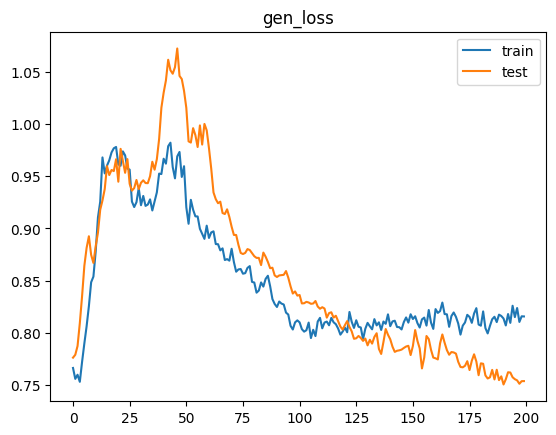

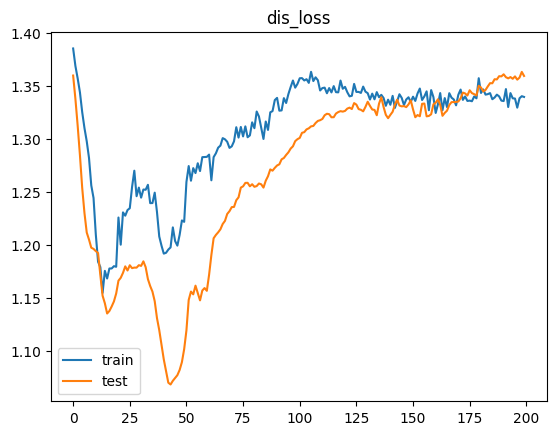

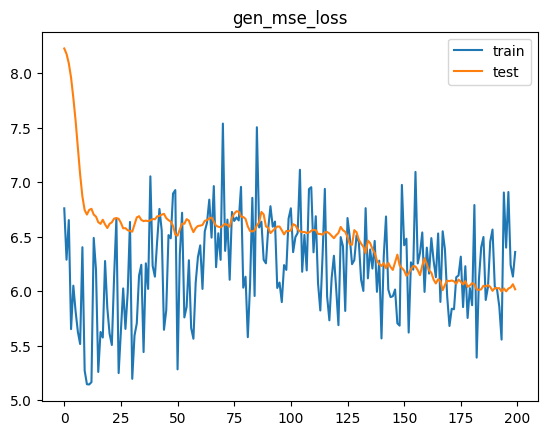

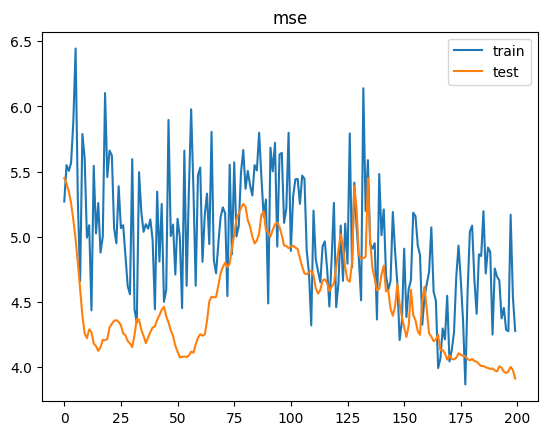

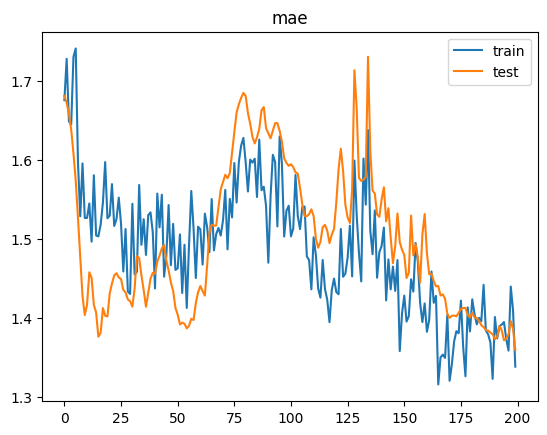

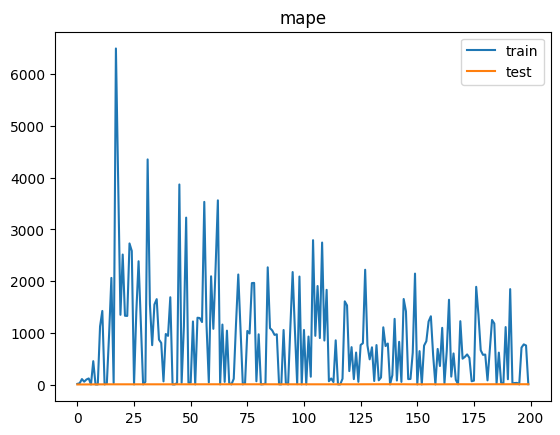

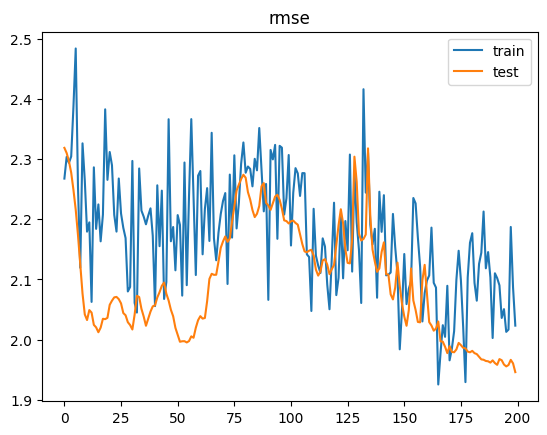

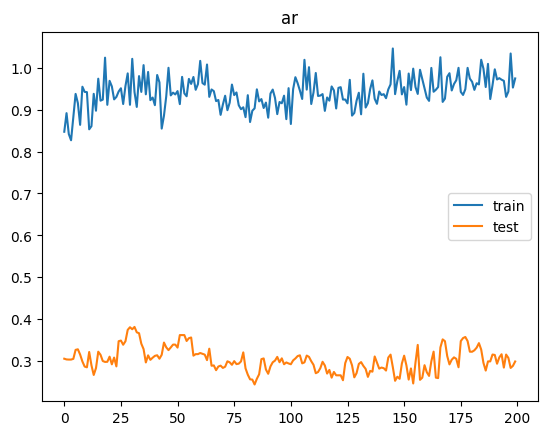

2/2 [==============================] - 1s 3ms/step


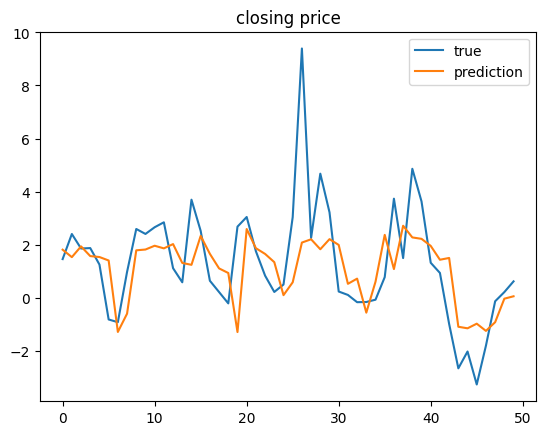

[MSE Baseline] train: 4.667994424211335  test: 3.868181586758766
Delta time with epochs = 200: 0:02:00.621095
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 5, 7)]       0           []                               
                                                                                                  
 bidirectional_2 (Bidirectional  (None, 5, 20)       1440        ['input_2[0][0]']                
 )                                                                                                
                                                                                                  
 concatenate_1 (Concatenate)    (None, 5, 27)        0           ['bidirectional_2[0][0]',        
                                                                  'input_2[0][0]'

Time for epoch 46 is 0.5085532665252686 sec Generator Loss: 0.9022255539894104,  Discriminator_loss: 1.2581324577331543
Time for epoch 47 is 0.510023832321167 sec Generator Loss: 0.906554102897644,  Discriminator_loss: 1.2394866943359375
Time for epoch 48 is 0.513251543045044 sec Generator Loss: 0.8974363803863525,  Discriminator_loss: 1.2555055618286133
Time for epoch 49 is 0.5090212821960449 sec Generator Loss: 0.9027478098869324,  Discriminator_loss: 1.2540969848632812
Time for epoch 50 is 0.5053610801696777 sec Generator Loss: 0.9078870415687561,  Discriminator_loss: 1.2350651025772095
Time for epoch 51 is 0.529531717300415 sec Generator Loss: 0.8978139162063599,  Discriminator_loss: 1.2664110660552979
Time for epoch 52 is 0.5696804523468018 sec Generator Loss: 0.8999353051185608,  Discriminator_loss: 1.2757759094238281
Time for epoch 53 is 0.5657334327697754 sec Generator Loss: 0.9073804616928101,  Discriminator_loss: 1.2556021213531494
Time for epoch 54 is 0.5666606426239014 sec 

Time for epoch 115 is 0.5052170753479004 sec Generator Loss: 0.813730776309967,  Discriminator_loss: 1.342896580696106
Time for epoch 116 is 0.5067825317382812 sec Generator Loss: 0.8112170696258545,  Discriminator_loss: 1.3482295274734497
Time for epoch 117 is 0.5068974494934082 sec Generator Loss: 0.8232855200767517,  Discriminator_loss: 1.3398610353469849
Time for epoch 118 is 0.5015542507171631 sec Generator Loss: 0.8230839967727661,  Discriminator_loss: 1.3370307683944702
Time for epoch 119 is 0.5079154968261719 sec Generator Loss: 0.8204777240753174,  Discriminator_loss: 1.3442773818969727
Time for epoch 120 is 0.5030348300933838 sec Generator Loss: 0.8162744641304016,  Discriminator_loss: 1.3410460948944092
Time for epoch 121 is 0.5013937950134277 sec Generator Loss: 0.8210466504096985,  Discriminator_loss: 1.346182107925415
Time for epoch 122 is 0.5171427726745605 sec Generator Loss: 0.8255855441093445,  Discriminator_loss: 1.3371777534484863
Time for epoch 123 is 0.51103281974

Time for epoch 183 is 0.5040383338928223 sec Generator Loss: 0.8175466060638428,  Discriminator_loss: 1.3294572830200195
Time for epoch 184 is 0.5044651031494141 sec Generator Loss: 0.8167541027069092,  Discriminator_loss: 1.3227636814117432
Time for epoch 185 is 0.5013382434844971 sec Generator Loss: 0.8289862275123596,  Discriminator_loss: 1.3292806148529053
Time for epoch 186 is 0.5021634101867676 sec Generator Loss: 0.8228713870048523,  Discriminator_loss: 1.3436591625213623
Time for epoch 187 is 0.5026893615722656 sec Generator Loss: 0.8222388029098511,  Discriminator_loss: 1.342574119567871
Time for epoch 188 is 0.5047831535339355 sec Generator Loss: 0.8159163594245911,  Discriminator_loss: 1.317404866218567
Time for epoch 189 is 0.5080060958862305 sec Generator Loss: 0.8133068084716797,  Discriminator_loss: 1.3327358961105347
Time for epoch 190 is 0.5025231838226318 sec Generator Loss: 0.8190548419952393,  Discriminator_loss: 1.3318389654159546
Time for epoch 191 is 0.5129692554

Time for epoch 251 is 0.5256435871124268 sec Generator Loss: 0.8117790818214417,  Discriminator_loss: 1.338950753211975
Time for epoch 252 is 0.5282838344573975 sec Generator Loss: 0.810877799987793,  Discriminator_loss: 1.3421987295150757
Time for epoch 253 is 0.5306198596954346 sec Generator Loss: 0.8119560480117798,  Discriminator_loss: 1.3442596197128296
Time for epoch 254 is 0.5242903232574463 sec Generator Loss: 0.8113279938697815,  Discriminator_loss: 1.3383821249008179
Time for epoch 255 is 0.5140690803527832 sec Generator Loss: 0.8224821090698242,  Discriminator_loss: 1.339709758758545
Time for epoch 256 is 0.5100631713867188 sec Generator Loss: 0.8165079951286316,  Discriminator_loss: 1.3324743509292603
Time for epoch 257 is 0.5036816596984863 sec Generator Loss: 0.8164904713630676,  Discriminator_loss: 1.337952971458435
Time for epoch 258 is 0.5049188137054443 sec Generator Loss: 0.8100860714912415,  Discriminator_loss: 1.3377753496170044
Time for epoch 259 is 0.552400350570

Time for epoch 319 is 0.5028207302093506 sec Generator Loss: 0.8151489496231079,  Discriminator_loss: 1.3299527168273926
Time for epoch 320 is 0.5106656551361084 sec Generator Loss: 0.8098253607749939,  Discriminator_loss: 1.3381543159484863
Time for epoch 321 is 0.5017549991607666 sec Generator Loss: 0.8131617307662964,  Discriminator_loss: 1.3318043947219849
Time for epoch 322 is 0.49500608444213867 sec Generator Loss: 0.8153743147850037,  Discriminator_loss: 1.3277506828308105
Time for epoch 323 is 0.5048372745513916 sec Generator Loss: 0.8096232414245605,  Discriminator_loss: 1.3318787813186646
Time for epoch 324 is 0.5038044452667236 sec Generator Loss: 0.8127427101135254,  Discriminator_loss: 1.3466200828552246
Time for epoch 325 is 0.5131897926330566 sec Generator Loss: 0.8150483965873718,  Discriminator_loss: 1.3374584913253784
Time for epoch 326 is 0.5031130313873291 sec Generator Loss: 0.7976083159446716,  Discriminator_loss: 1.3425710201263428
Time for epoch 327 is 0.5075833

Time for epoch 387 is 0.5872750282287598 sec Generator Loss: 0.8327133059501648,  Discriminator_loss: 1.3234044313430786
Time for epoch 388 is 0.5510993003845215 sec Generator Loss: 0.8257966637611389,  Discriminator_loss: 1.3373130559921265
Time for epoch 389 is 0.5452070236206055 sec Generator Loss: 0.8215807676315308,  Discriminator_loss: 1.3359876871109009
Time for epoch 390 is 0.5403375625610352 sec Generator Loss: 0.8276122808456421,  Discriminator_loss: 1.3209197521209717
Time for epoch 391 is 0.5809261798858643 sec Generator Loss: 0.8189855217933655,  Discriminator_loss: 1.3381298780441284
Time for epoch 392 is 0.546283483505249 sec Generator Loss: 0.8286370635032654,  Discriminator_loss: 1.3257255554199219
Time for epoch 393 is 0.535053014755249 sec Generator Loss: 0.8209215402603149,  Discriminator_loss: 1.3428186178207397
Time for epoch 394 is 0.5445220470428467 sec Generator Loss: 0.8166325092315674,  Discriminator_loss: 1.3370518684387207
Time for epoch 395 is 0.5690870285

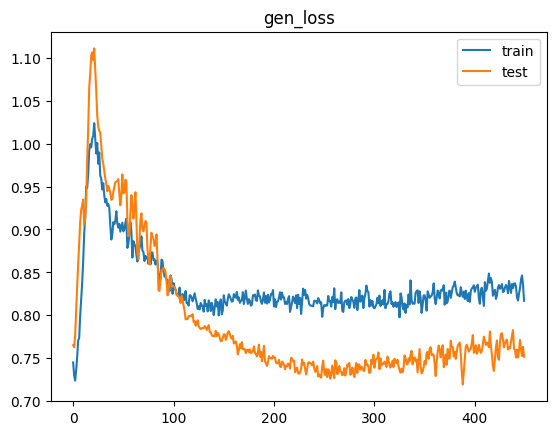

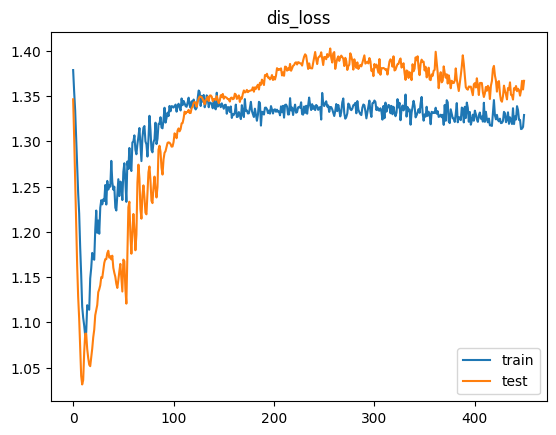

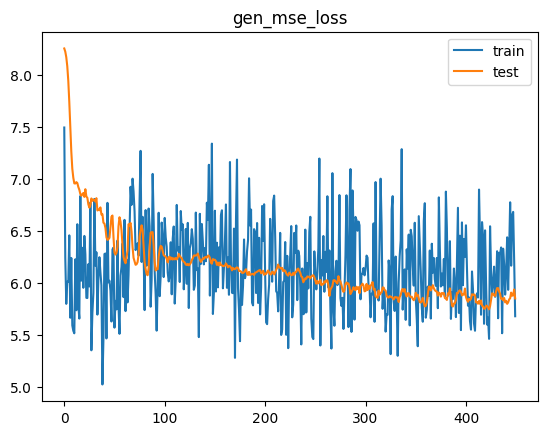

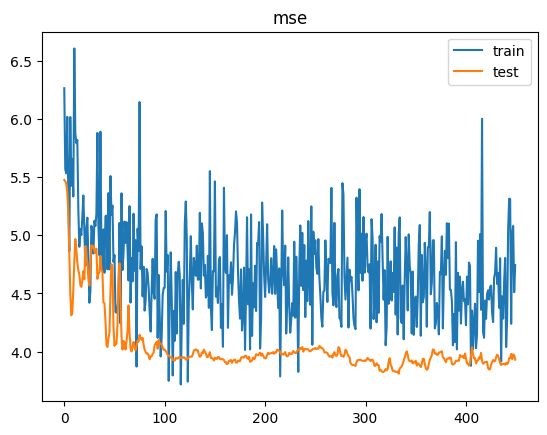

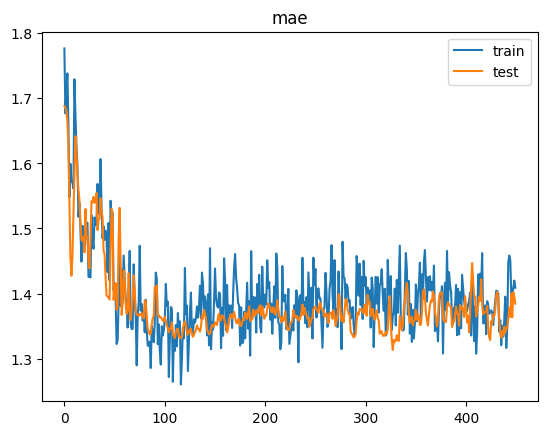

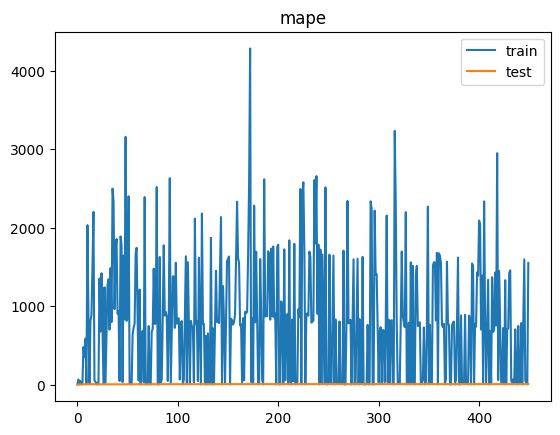

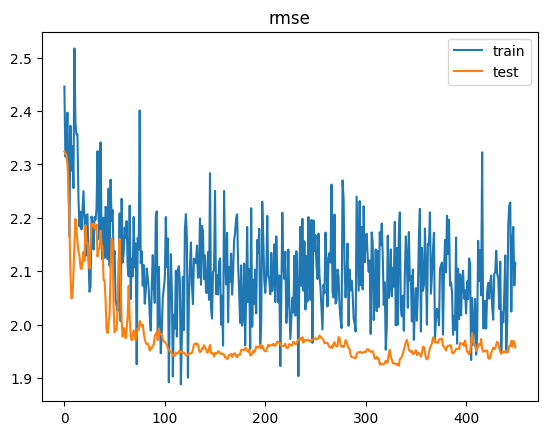

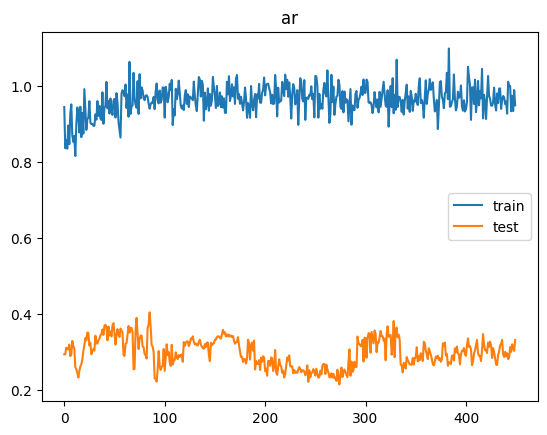

2/2 [==============================] - 1s 3ms/step


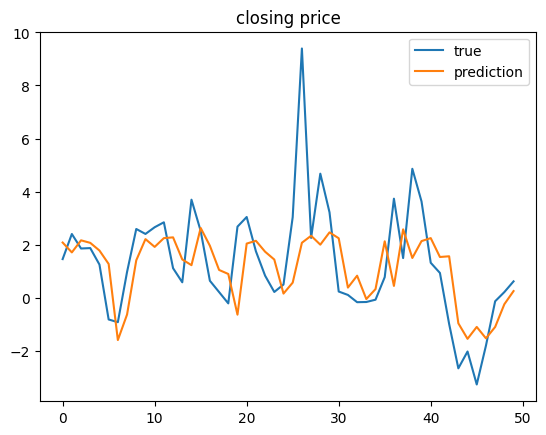

[MSE Baseline] train: 4.642820881304524  test: 3.868181586758766
Delta time with epochs = 450: 0:04:08.088334
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 5, 7)]       0           []                               
                                                                                                  
 bidirectional_4 (Bidirectional  (None, 5, 20)       1440        ['input_3[0][0]']                
 )                                                                                                
                                                                                                  
 concatenate_2 (Concatenate)    (None, 5, 27)        0           ['bidirectional_4[0][0]',        
                                                                  'input_3[0][0]'

Time for epoch 46 is 0.5264573097229004 sec Generator Loss: 0.949675440788269,  Discriminator_loss: 1.242537260055542
Time for epoch 47 is 0.5438430309295654 sec Generator Loss: 0.9585995078086853,  Discriminator_loss: 1.2064168453216553
Time for epoch 48 is 0.5269920825958252 sec Generator Loss: 0.9559499025344849,  Discriminator_loss: 1.2257697582244873
Time for epoch 49 is 0.526263952255249 sec Generator Loss: 0.9420793056488037,  Discriminator_loss: 1.2449283599853516
Time for epoch 50 is 0.5274960994720459 sec Generator Loss: 0.9270614385604858,  Discriminator_loss: 1.251993179321289
Time for epoch 51 is 0.5336630344390869 sec Generator Loss: 0.9193923473358154,  Discriminator_loss: 1.2359198331832886
Time for epoch 52 is 0.5304341316223145 sec Generator Loss: 0.9201111793518066,  Discriminator_loss: 1.2487201690673828
Time for epoch 53 is 0.5196120738983154 sec Generator Loss: 0.9261394739151001,  Discriminator_loss: 1.2339895963668823
Time for epoch 54 is 0.5279898643493652 sec 

Time for epoch 115 is 0.5403833389282227 sec Generator Loss: 0.8166681528091431,  Discriminator_loss: 1.3402845859527588
Time for epoch 116 is 0.5268347263336182 sec Generator Loss: 0.8213008642196655,  Discriminator_loss: 1.3533282279968262
Time for epoch 117 is 0.52264404296875 sec Generator Loss: 0.8226550221443176,  Discriminator_loss: 1.3439604043960571
Time for epoch 118 is 0.5186753273010254 sec Generator Loss: 0.8258564472198486,  Discriminator_loss: 1.3366941213607788
Time for epoch 119 is 0.5199899673461914 sec Generator Loss: 0.8178281188011169,  Discriminator_loss: 1.3397791385650635
Time for epoch 120 is 0.5185134410858154 sec Generator Loss: 0.8174267411231995,  Discriminator_loss: 1.346139907836914
Time for epoch 121 is 0.5314414501190186 sec Generator Loss: 0.8226134181022644,  Discriminator_loss: 1.3383337259292603
Time for epoch 122 is 0.5323517322540283 sec Generator Loss: 0.8272841572761536,  Discriminator_loss: 1.3474868535995483
Time for epoch 123 is 0.52876996994

Time for epoch 183 is 0.5303828716278076 sec Generator Loss: 0.8109005093574524,  Discriminator_loss: 1.3444451093673706
Time for epoch 184 is 0.52394700050354 sec Generator Loss: 0.8349156975746155,  Discriminator_loss: 1.3297498226165771
Time for epoch 185 is 0.5241518020629883 sec Generator Loss: 0.826231062412262,  Discriminator_loss: 1.3300079107284546
Time for epoch 186 is 0.5287647247314453 sec Generator Loss: 0.8163111805915833,  Discriminator_loss: 1.3381059169769287
Time for epoch 187 is 0.539086103439331 sec Generator Loss: 0.8161839246749878,  Discriminator_loss: 1.335214376449585
Time for epoch 188 is 0.5060372352600098 sec Generator Loss: 0.8260589241981506,  Discriminator_loss: 1.337307095527649
Time for epoch 189 is 0.5196247100830078 sec Generator Loss: 0.8244984745979309,  Discriminator_loss: 1.335771918296814
Time for epoch 190 is 0.5250952243804932 sec Generator Loss: 0.816798210144043,  Discriminator_loss: 1.3304189443588257
Time for epoch 191 is 0.5235707759857178

Time for epoch 252 is 0.5012984275817871 sec Generator Loss: 0.8251760005950928,  Discriminator_loss: 1.3410656452178955
Time for epoch 253 is 0.5086627006530762 sec Generator Loss: 0.8175856471061707,  Discriminator_loss: 1.3327683210372925
Time for epoch 254 is 0.5107135772705078 sec Generator Loss: 0.8233962059020996,  Discriminator_loss: 1.3343604803085327
Time for epoch 255 is 0.53092360496521 sec Generator Loss: 0.8229292631149292,  Discriminator_loss: 1.333871603012085
Time for epoch 256 is 0.5477745532989502 sec Generator Loss: 0.8315117955207825,  Discriminator_loss: 1.3292361497879028
Time for epoch 257 is 0.5245614051818848 sec Generator Loss: 0.8291031718254089,  Discriminator_loss: 1.3354408740997314
Time for epoch 258 is 0.5041143894195557 sec Generator Loss: 0.8224223852157593,  Discriminator_loss: 1.331167221069336
Time for epoch 259 is 0.5266752243041992 sec Generator Loss: 0.8252524137496948,  Discriminator_loss: 1.334504246711731
Time for epoch 260 is 0.5442128181457

Time for epoch 321 is 0.49856042861938477 sec Generator Loss: 0.8351399898529053,  Discriminator_loss: 1.3368029594421387
Time for epoch 322 is 0.4984090328216553 sec Generator Loss: 0.8128554821014404,  Discriminator_loss: 1.3305145502090454
Time for epoch 323 is 0.5135488510131836 sec Generator Loss: 0.8214247822761536,  Discriminator_loss: 1.3350677490234375
Time for epoch 324 is 0.5056045055389404 sec Generator Loss: 0.8221752047538757,  Discriminator_loss: 1.3307342529296875
Time for epoch 325 is 0.5052237510681152 sec Generator Loss: 0.825650155544281,  Discriminator_loss: 1.3466688394546509
Time for epoch 326 is 0.5026071071624756 sec Generator Loss: 0.8257938027381897,  Discriminator_loss: 1.3391478061676025
Time for epoch 327 is 0.5026564598083496 sec Generator Loss: 0.8162763118743896,  Discriminator_loss: 1.3304665088653564
Time for epoch 328 is 0.4995996952056885 sec Generator Loss: 0.8226057887077332,  Discriminator_loss: 1.3335932493209839
Time for epoch 329 is 0.51392173

Time for epoch 389 is 0.4958078861236572 sec Generator Loss: 0.8271440863609314,  Discriminator_loss: 1.3348816633224487
Time for epoch 390 is 0.5028877258300781 sec Generator Loss: 0.8389261960983276,  Discriminator_loss: 1.3169960975646973
Time for epoch 391 is 0.49904632568359375 sec Generator Loss: 0.8216598629951477,  Discriminator_loss: 1.3376293182373047
Time for epoch 392 is 0.5065271854400635 sec Generator Loss: 0.8341642618179321,  Discriminator_loss: 1.338325023651123
Time for epoch 393 is 0.5139255523681641 sec Generator Loss: 0.8278172016143799,  Discriminator_loss: 1.330790638923645
Time for epoch 394 is 0.4985787868499756 sec Generator Loss: 0.8304741978645325,  Discriminator_loss: 1.3340306282043457
Time for epoch 395 is 0.5000836849212646 sec Generator Loss: 0.8068270087242126,  Discriminator_loss: 1.339849591255188
Time for epoch 396 is 0.5020110607147217 sec Generator Loss: 0.8161162734031677,  Discriminator_loss: 1.3349331617355347
Time for epoch 397 is 0.4987490177

Time for epoch 457 is 0.5007820129394531 sec Generator Loss: 0.823456346988678,  Discriminator_loss: 1.3435834646224976
Time for epoch 458 is 0.4949336051940918 sec Generator Loss: 0.8326647281646729,  Discriminator_loss: 1.3252235651016235
Time for epoch 459 is 0.49831104278564453 sec Generator Loss: 0.827199399471283,  Discriminator_loss: 1.3372660875320435
Time for epoch 460 is 0.5048589706420898 sec Generator Loss: 0.8350252509117126,  Discriminator_loss: 1.32953679561615
Time for epoch 461 is 0.5041458606719971 sec Generator Loss: 0.8420628309249878,  Discriminator_loss: 1.3243869543075562
Time for epoch 462 is 0.5059473514556885 sec Generator Loss: 0.8384830951690674,  Discriminator_loss: 1.3255261182785034
Time for epoch 463 is 0.49976587295532227 sec Generator Loss: 0.8439591526985168,  Discriminator_loss: 1.3137224912643433
Time for epoch 464 is 0.5021054744720459 sec Generator Loss: 0.8368362784385681,  Discriminator_loss: 1.3270609378814697
Time for epoch 465 is 0.5043380260

Time for epoch 525 is 0.49904584884643555 sec Generator Loss: 0.8239459991455078,  Discriminator_loss: 1.330252766609192
Time for epoch 526 is 0.4826841354370117 sec Generator Loss: 0.8306200504302979,  Discriminator_loss: 1.324760913848877
Time for epoch 527 is 0.48372840881347656 sec Generator Loss: 0.8153151869773865,  Discriminator_loss: 1.3377732038497925
Time for epoch 528 is 0.4828457832336426 sec Generator Loss: 0.8302468061447144,  Discriminator_loss: 1.3359184265136719
Time for epoch 529 is 0.47958850860595703 sec Generator Loss: 0.8349348306655884,  Discriminator_loss: 1.3310500383377075
Time for epoch 530 is 0.4889528751373291 sec Generator Loss: 0.8264070749282837,  Discriminator_loss: 1.338639259338379
Time for epoch 531 is 0.48444271087646484 sec Generator Loss: 0.8302024006843567,  Discriminator_loss: 1.3366050720214844
Time for epoch 532 is 0.48119449615478516 sec Generator Loss: 0.8189343810081482,  Discriminator_loss: 1.3311318159103394
Time for epoch 533 is 0.475813

Time for epoch 593 is 0.5313193798065186 sec Generator Loss: 0.8327619433403015,  Discriminator_loss: 1.3237864971160889
Time for epoch 594 is 0.4937887191772461 sec Generator Loss: 0.840589702129364,  Discriminator_loss: 1.3161503076553345
Time for epoch 595 is 0.4915030002593994 sec Generator Loss: 0.8478251099586487,  Discriminator_loss: 1.3066110610961914
Time for epoch 596 is 0.5042481422424316 sec Generator Loss: 0.8491383194923401,  Discriminator_loss: 1.3219823837280273
Time for epoch 597 is 0.5026087760925293 sec Generator Loss: 0.8359933495521545,  Discriminator_loss: 1.3170924186706543
Time for epoch 598 is 0.5025672912597656 sec Generator Loss: 0.8370204567909241,  Discriminator_loss: 1.323994755744934
Time for epoch 599 is 0.5002360343933105 sec Generator Loss: 0.8356968760490417,  Discriminator_loss: 1.3293633460998535
Time for epoch 600 is 0.4987754821777344 sec Generator Loss: 0.8381547331809998,  Discriminator_loss: 1.3276258707046509
Time for epoch 601 is 0.5371694564

Time for epoch 662 is 0.5333786010742188 sec Generator Loss: 0.8261861801147461,  Discriminator_loss: 1.3310140371322632
Time for epoch 663 is 0.534203052520752 sec Generator Loss: 0.841619610786438,  Discriminator_loss: 1.3147895336151123
Time for epoch 664 is 0.5225486755371094 sec Generator Loss: 0.8376721739768982,  Discriminator_loss: 1.322057843208313
Time for epoch 665 is 0.5109214782714844 sec Generator Loss: 0.8468013405799866,  Discriminator_loss: 1.3338969945907593
Time for epoch 666 is 0.502709150314331 sec Generator Loss: 0.8359324336051941,  Discriminator_loss: 1.3209030628204346
Time for epoch 667 is 0.5080945491790771 sec Generator Loss: 0.8362900614738464,  Discriminator_loss: 1.322860836982727
Time for epoch 668 is 0.5047709941864014 sec Generator Loss: 0.8362987041473389,  Discriminator_loss: 1.3196309804916382
Time for epoch 669 is 0.5013258457183838 sec Generator Loss: 0.8336955904960632,  Discriminator_loss: 1.331723690032959
Time for epoch 670 is 0.50472617149353

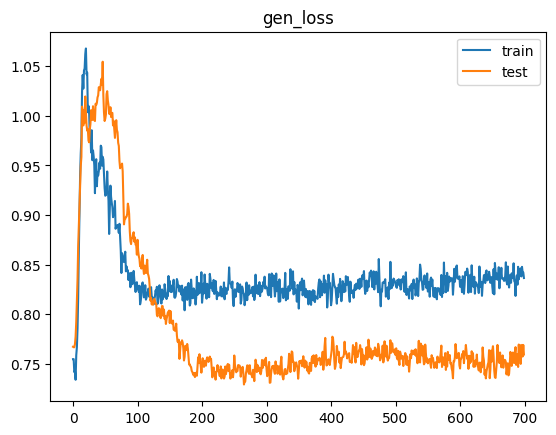

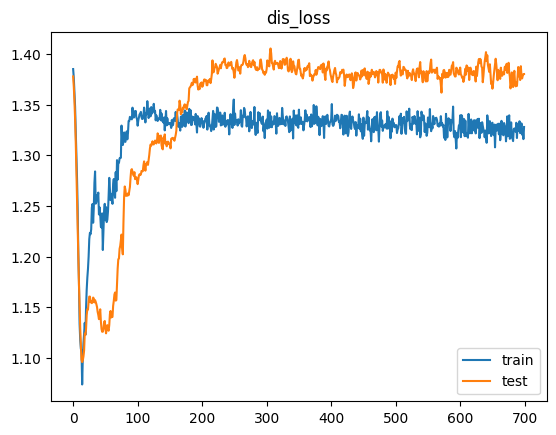

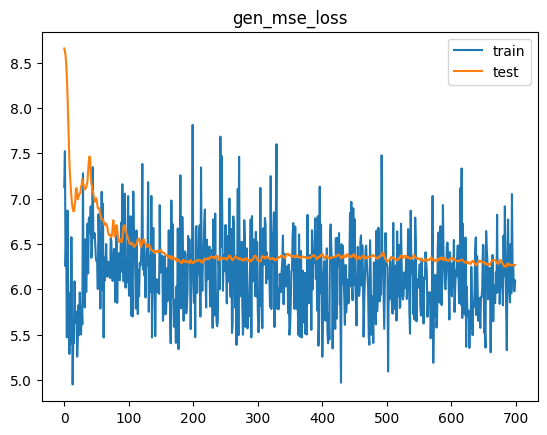

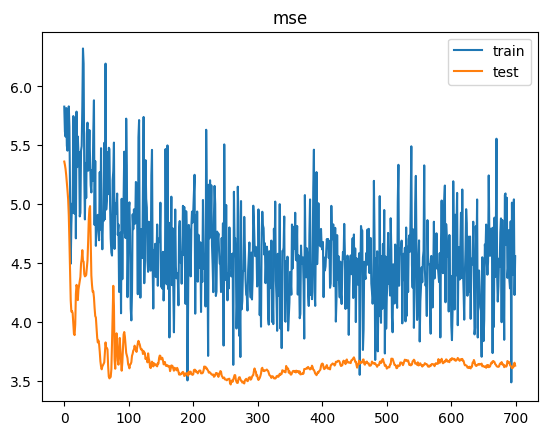

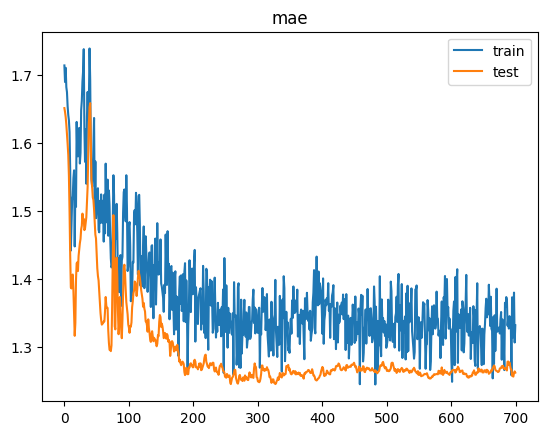

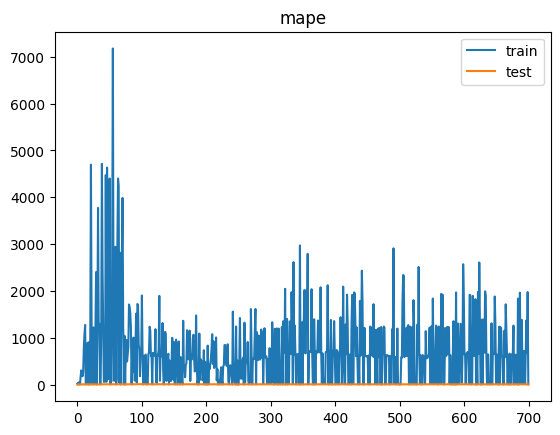

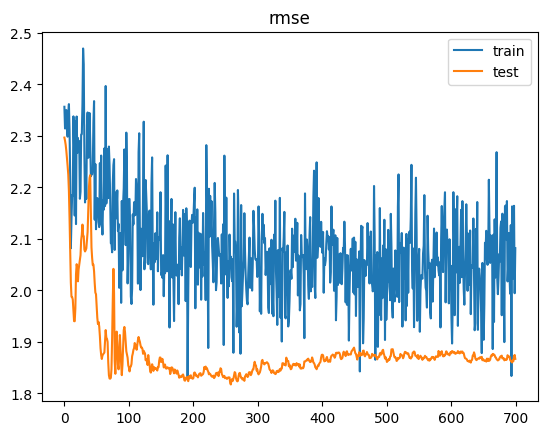

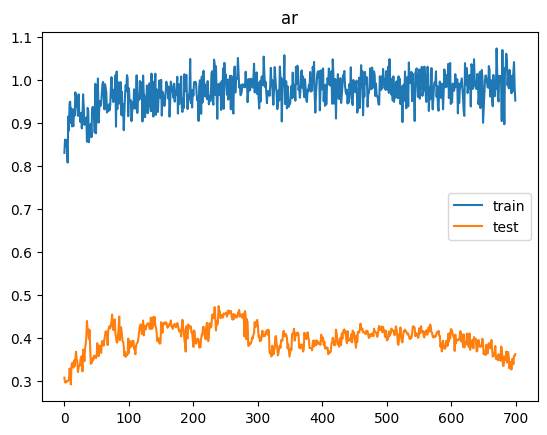

2/2 [==============================] - 1s 3ms/step


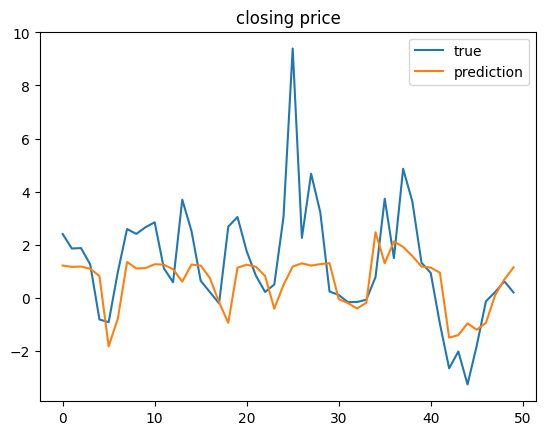

[MSE Baseline] train: 4.593254532436393  test: 3.7469059248471765
Delta time with epochs = 700: 0:06:22.375968
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 5, 7)]       0           []                               
                                                                                                  
 bidirectional_6 (Bidirectional  (None, 5, 20)       1440        ['input_4[0][0]']                
 )                                                                                                
                                                                                                  
 concatenate_3 (Concatenate)    (None, 5, 27)        0           ['bidirectional_6[0][0]',        
                                                                  'input_4[0][0]

Time for epoch 46 is 0.5055108070373535 sec Generator Loss: 0.8962098360061646,  Discriminator_loss: 1.2812743186950684
Time for epoch 47 is 0.514275312423706 sec Generator Loss: 0.9035218954086304,  Discriminator_loss: 1.2576119899749756
Time for epoch 48 is 0.5113101005554199 sec Generator Loss: 0.8949915766716003,  Discriminator_loss: 1.266226887702942
Time for epoch 49 is 0.5097975730895996 sec Generator Loss: 0.8918570280075073,  Discriminator_loss: 1.2869338989257812
Time for epoch 50 is 0.5068655014038086 sec Generator Loss: 0.8950945138931274,  Discriminator_loss: 1.276511788368225
Time for epoch 51 is 0.5354843139648438 sec Generator Loss: 0.8923335075378418,  Discriminator_loss: 1.2752927541732788
Time for epoch 52 is 0.5326874256134033 sec Generator Loss: 0.8931263089179993,  Discriminator_loss: 1.2719172239303589
Time for epoch 53 is 0.5306711196899414 sec Generator Loss: 0.8806277513504028,  Discriminator_loss: 1.2821071147918701
Time for epoch 54 is 0.5345146656036377 sec

Time for epoch 115 is 0.5028772354125977 sec Generator Loss: 0.8531745076179504,  Discriminator_loss: 1.3066318035125732
Time for epoch 116 is 0.49770498275756836 sec Generator Loss: 0.8589364290237427,  Discriminator_loss: 1.321143388748169
Time for epoch 117 is 0.52659010887146 sec Generator Loss: 0.8598803281784058,  Discriminator_loss: 1.311163067817688
Time for epoch 118 is 0.5238564014434814 sec Generator Loss: 0.861484706401825,  Discriminator_loss: 1.3046774864196777
Time for epoch 119 is 0.5546269416809082 sec Generator Loss: 0.8613148331642151,  Discriminator_loss: 1.3154277801513672
Time for epoch 120 is 0.533470630645752 sec Generator Loss: 0.8571934700012207,  Discriminator_loss: 1.3071829080581665
Time for epoch 121 is 0.5506770610809326 sec Generator Loss: 0.8567883372306824,  Discriminator_loss: 1.3100810050964355
Time for epoch 122 is 0.5316050052642822 sec Generator Loss: 0.8687211275100708,  Discriminator_loss: 1.305290937423706
Time for epoch 123 is 0.52034401893615

Time for epoch 184 is 0.5259623527526855 sec Generator Loss: 0.8390933871269226,  Discriminator_loss: 1.3216302394866943
Time for epoch 185 is 0.5507631301879883 sec Generator Loss: 0.8619192838668823,  Discriminator_loss: 1.304770827293396
Time for epoch 186 is 0.5190279483795166 sec Generator Loss: 0.845365583896637,  Discriminator_loss: 1.3156235218048096
Time for epoch 187 is 0.5285289287567139 sec Generator Loss: 0.8440405130386353,  Discriminator_loss: 1.3215545415878296
Time for epoch 188 is 0.5324783325195312 sec Generator Loss: 0.8626176714897156,  Discriminator_loss: 1.3021185398101807
Time for epoch 189 is 0.519869327545166 sec Generator Loss: 0.8614296317100525,  Discriminator_loss: 1.3115798234939575
Time for epoch 190 is 0.5256376266479492 sec Generator Loss: 0.8357081413269043,  Discriminator_loss: 1.3336637020111084
Time for epoch 191 is 0.5332212448120117 sec Generator Loss: 0.8364207744598389,  Discriminator_loss: 1.3295447826385498
Time for epoch 192 is 0.53813171386

Time for epoch 252 is 0.5109362602233887 sec Generator Loss: 0.8314365744590759,  Discriminator_loss: 1.3241503238677979
Time for epoch 253 is 0.5040793418884277 sec Generator Loss: 0.8479718565940857,  Discriminator_loss: 1.3209606409072876
Time for epoch 254 is 0.5037343502044678 sec Generator Loss: 0.8390487432479858,  Discriminator_loss: 1.3301124572753906
Time for epoch 255 is 0.5011301040649414 sec Generator Loss: 0.8210992217063904,  Discriminator_loss: 1.344130039215088
Time for epoch 256 is 0.5382647514343262 sec Generator Loss: 0.8302697539329529,  Discriminator_loss: 1.3322365283966064
Time for epoch 257 is 0.5248701572418213 sec Generator Loss: 0.835586667060852,  Discriminator_loss: 1.338754415512085
Time for epoch 258 is 0.5330049991607666 sec Generator Loss: 0.8176825046539307,  Discriminator_loss: 1.3451169729232788
Time for epoch 259 is 0.539839506149292 sec Generator Loss: 0.8297348022460938,  Discriminator_loss: 1.3373836278915405
Time for epoch 260 is 0.512175321578

Time for epoch 320 is 0.5318741798400879 sec Generator Loss: 0.8409390449523926,  Discriminator_loss: 1.3197818994522095
Time for epoch 321 is 0.5298938751220703 sec Generator Loss: 0.8407045602798462,  Discriminator_loss: 1.3253655433654785
Time for epoch 322 is 0.5283792018890381 sec Generator Loss: 0.8199738264083862,  Discriminator_loss: 1.3403176069259644
Time for epoch 323 is 0.5198135375976562 sec Generator Loss: 0.8315620422363281,  Discriminator_loss: 1.3318191766738892
Time for epoch 324 is 0.5073356628417969 sec Generator Loss: 0.8361279964447021,  Discriminator_loss: 1.3245309591293335
Time for epoch 325 is 0.5017247200012207 sec Generator Loss: 0.8269575238227844,  Discriminator_loss: 1.3409160375595093
Time for epoch 326 is 0.5089366436004639 sec Generator Loss: 0.8124423623085022,  Discriminator_loss: 1.3377323150634766
Time for epoch 327 is 0.5057711601257324 sec Generator Loss: 0.8220252990722656,  Discriminator_loss: 1.3310823440551758
Time for epoch 328 is 0.51085233

Time for epoch 388 is 0.5067145824432373 sec Generator Loss: 0.8320254683494568,  Discriminator_loss: 1.3325749635696411
Time for epoch 389 is 0.5049343109130859 sec Generator Loss: 0.8327234983444214,  Discriminator_loss: 1.3248519897460938
Time for epoch 390 is 0.505258321762085 sec Generator Loss: 0.8423389196395874,  Discriminator_loss: 1.3331197500228882
Time for epoch 391 is 0.5091965198516846 sec Generator Loss: 0.8325669169425964,  Discriminator_loss: 1.3379034996032715
Time for epoch 392 is 0.5090517997741699 sec Generator Loss: 0.8322014212608337,  Discriminator_loss: 1.3295457363128662
Time for epoch 393 is 0.5077319145202637 sec Generator Loss: 0.8209062814712524,  Discriminator_loss: 1.3317432403564453
Time for epoch 394 is 0.5076565742492676 sec Generator Loss: 0.8324722051620483,  Discriminator_loss: 1.3397293090820312
Time for epoch 395 is 0.5101463794708252 sec Generator Loss: 0.8352683782577515,  Discriminator_loss: 1.3346151113510132
Time for epoch 396 is 1.250474691

Time for epoch 456 is 0.504777193069458 sec Generator Loss: 0.8314350247383118,  Discriminator_loss: 1.3352036476135254
Time for epoch 457 is 0.5055334568023682 sec Generator Loss: 0.8149876594543457,  Discriminator_loss: 1.3350021839141846
Time for epoch 458 is 0.5020730495452881 sec Generator Loss: 0.8257571458816528,  Discriminator_loss: 1.325668215751648
Time for epoch 459 is 0.4990835189819336 sec Generator Loss: 0.8409038782119751,  Discriminator_loss: 1.3250102996826172
Time for epoch 460 is 0.5005953311920166 sec Generator Loss: 0.829105794429779,  Discriminator_loss: 1.3262624740600586
Time for epoch 461 is 0.5084104537963867 sec Generator Loss: 0.8332529664039612,  Discriminator_loss: 1.325196623802185
Time for epoch 462 is 0.5145401954650879 sec Generator Loss: 0.8440946340560913,  Discriminator_loss: 1.3191601037979126
Time for epoch 463 is 0.5035436153411865 sec Generator Loss: 0.8456456065177917,  Discriminator_loss: 1.313788890838623
Time for epoch 464 is 0.5039329528808

Time for epoch 524 is 0.5083582401275635 sec Generator Loss: 0.8539233207702637,  Discriminator_loss: 1.311181664466858
Time for epoch 525 is 0.5047726631164551 sec Generator Loss: 0.8483791947364807,  Discriminator_loss: 1.3176281452178955
Time for epoch 526 is 0.4978322982788086 sec Generator Loss: 0.8338333368301392,  Discriminator_loss: 1.3348469734191895
Time for epoch 527 is 0.5003063678741455 sec Generator Loss: 0.8535789251327515,  Discriminator_loss: 1.3211172819137573
Time for epoch 528 is 0.5063402652740479 sec Generator Loss: 0.8560265302658081,  Discriminator_loss: 1.3201342821121216
Time for epoch 529 is 0.5051636695861816 sec Generator Loss: 0.8281711935997009,  Discriminator_loss: 1.328335165977478
Time for epoch 530 is 0.5146408081054688 sec Generator Loss: 0.8330679535865784,  Discriminator_loss: 1.320008397102356
Time for epoch 531 is 0.5023047924041748 sec Generator Loss: 0.84825199842453,  Discriminator_loss: 1.3156194686889648
Time for epoch 532 is 0.5111408233642

Time for epoch 592 is 0.5009751319885254 sec Generator Loss: 0.8462684750556946,  Discriminator_loss: 1.3080483675003052
Time for epoch 593 is 0.5045652389526367 sec Generator Loss: 0.84830641746521,  Discriminator_loss: 1.3159607648849487
Time for epoch 594 is 0.5054426193237305 sec Generator Loss: 0.8516096472740173,  Discriminator_loss: 1.3207879066467285
Time for epoch 595 is 0.4996616840362549 sec Generator Loss: 0.8396763801574707,  Discriminator_loss: 1.3206663131713867
Time for epoch 596 is 0.5045092105865479 sec Generator Loss: 0.845780611038208,  Discriminator_loss: 1.3117262125015259
Time for epoch 597 is 0.5014445781707764 sec Generator Loss: 0.8616968989372253,  Discriminator_loss: 1.3140289783477783
Time for epoch 598 is 0.5069983005523682 sec Generator Loss: 0.8607088923454285,  Discriminator_loss: 1.3078746795654297
Time for epoch 599 is 0.5118112564086914 sec Generator Loss: 0.8413860201835632,  Discriminator_loss: 1.326843023300171
Time for epoch 600 is 0.503647565841

Time for epoch 660 is 0.49874448776245117 sec Generator Loss: 0.8643818497657776,  Discriminator_loss: 1.3237613439559937
Time for epoch 661 is 0.5001192092895508 sec Generator Loss: 0.8490031957626343,  Discriminator_loss: 1.3135547637939453
Time for epoch 662 is 0.5015649795532227 sec Generator Loss: 0.8493971228599548,  Discriminator_loss: 1.3103634119033813
Time for epoch 663 is 0.5078024864196777 sec Generator Loss: 0.8712946772575378,  Discriminator_loss: 1.3096628189086914
Time for epoch 664 is 0.4992196559906006 sec Generator Loss: 0.8742581605911255,  Discriminator_loss: 1.3058439493179321
Time for epoch 665 is 0.5034751892089844 sec Generator Loss: 0.8601316213607788,  Discriminator_loss: 1.3159430027008057
Time for epoch 666 is 0.4958786964416504 sec Generator Loss: 0.8375141620635986,  Discriminator_loss: 1.3268554210662842
Time for epoch 667 is 0.5035214424133301 sec Generator Loss: 0.8478606939315796,  Discriminator_loss: 1.3219878673553467
Time for epoch 668 is 0.4975595

Time for epoch 728 is 0.5006344318389893 sec Generator Loss: 0.8608891367912292,  Discriminator_loss: 1.3081988096237183
Time for epoch 729 is 0.5085532665252686 sec Generator Loss: 0.8647726774215698,  Discriminator_loss: 1.3150509595870972
Time for epoch 730 is 0.5035042762756348 sec Generator Loss: 0.8564677238464355,  Discriminator_loss: 1.3144639730453491
Time for epoch 731 is 0.5031733512878418 sec Generator Loss: 0.8791828155517578,  Discriminator_loss: 1.3024883270263672
Time for epoch 732 is 0.5008890628814697 sec Generator Loss: 0.8536291718482971,  Discriminator_loss: 1.3114876747131348
Time for epoch 733 is 0.5076484680175781 sec Generator Loss: 0.843538761138916,  Discriminator_loss: 1.3226059675216675
Time for epoch 734 is 0.5049364566802979 sec Generator Loss: 0.8618456125259399,  Discriminator_loss: 1.3163055181503296
Time for epoch 735 is 0.5123069286346436 sec Generator Loss: 0.8602139949798584,  Discriminator_loss: 1.3145619630813599
Time for epoch 736 is 0.498807191

Time for epoch 796 is 0.4682953357696533 sec Generator Loss: 0.8580814003944397,  Discriminator_loss: 1.319006085395813
Time for epoch 797 is 0.47213077545166016 sec Generator Loss: 0.8604544401168823,  Discriminator_loss: 1.306307315826416
Time for epoch 798 is 0.4840891361236572 sec Generator Loss: 0.8600633144378662,  Discriminator_loss: 1.3174312114715576
Time for epoch 799 is 0.48419785499572754 sec Generator Loss: 0.8794612884521484,  Discriminator_loss: 1.2957969903945923
Time for epoch 800 is 0.49610066413879395 sec Generator Loss: 0.8748121857643127,  Discriminator_loss: 1.3053979873657227
Time for epoch 801 is 0.49327635765075684 sec Generator Loss: 0.8671989440917969,  Discriminator_loss: 1.3114045858383179
Time for epoch 802 is 0.48673224449157715 sec Generator Loss: 0.86480712890625,  Discriminator_loss: 1.3095974922180176
Time for epoch 803 is 0.4807164669036865 sec Generator Loss: 0.8493817448616028,  Discriminator_loss: 1.3091720342636108
Time for epoch 804 is 0.4895243

Time for epoch 864 is 0.5032198429107666 sec Generator Loss: 0.8433264493942261,  Discriminator_loss: 1.3164719343185425
Time for epoch 865 is 0.515451192855835 sec Generator Loss: 0.8654534816741943,  Discriminator_loss: 1.3052242994308472
Time for epoch 866 is 0.49776649475097656 sec Generator Loss: 0.8678127527236938,  Discriminator_loss: 1.3101338148117065
Time for epoch 867 is 0.5041203498840332 sec Generator Loss: 0.8650076985359192,  Discriminator_loss: 1.3088735342025757
Time for epoch 868 is 0.500138521194458 sec Generator Loss: 0.8611676096916199,  Discriminator_loss: 1.3168057203292847
Time for epoch 869 is 0.5008289813995361 sec Generator Loss: 0.8662472367286682,  Discriminator_loss: 1.306143045425415
Time for epoch 870 is 0.5000393390655518 sec Generator Loss: 0.852243959903717,  Discriminator_loss: 1.3205515146255493
Time for epoch 871 is 0.4994480609893799 sec Generator Loss: 0.8538333773612976,  Discriminator_loss: 1.3111826181411743
Time for epoch 872 is 0.50479722023

Time for epoch 933 is 0.5577137470245361 sec Generator Loss: 0.8717547655105591,  Discriminator_loss: 1.3037878274917603
Time for epoch 934 is 0.5272324085235596 sec Generator Loss: 0.8824385404586792,  Discriminator_loss: 1.3096325397491455
Time for epoch 935 is 0.5362834930419922 sec Generator Loss: 0.8700502514839172,  Discriminator_loss: 1.3015276193618774
Time for epoch 936 is 0.5420143604278564 sec Generator Loss: 0.8675933480262756,  Discriminator_loss: 1.310455560684204
Time for epoch 937 is 0.5347824096679688 sec Generator Loss: 0.8713160157203674,  Discriminator_loss: 1.3163809776306152
Time for epoch 938 is 0.5327944755554199 sec Generator Loss: 0.8756171464920044,  Discriminator_loss: 1.3013004064559937
Time for epoch 939 is 0.5276386737823486 sec Generator Loss: 0.8840327262878418,  Discriminator_loss: 1.3033897876739502
Time for epoch 940 is 0.5256059169769287 sec Generator Loss: 0.876541793346405,  Discriminator_loss: 1.3055816888809204
Time for epoch 941 is 0.5538485050

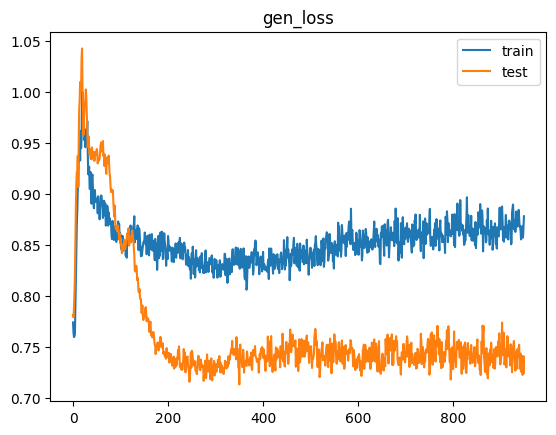

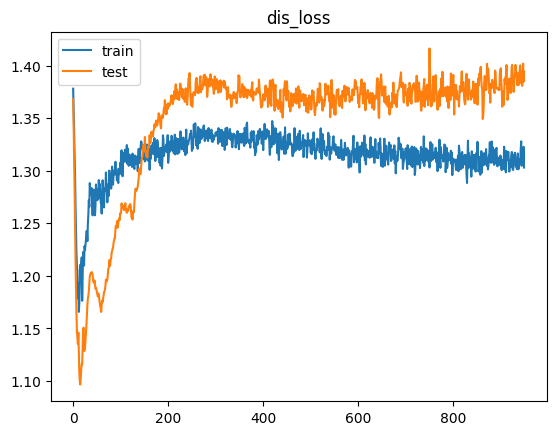

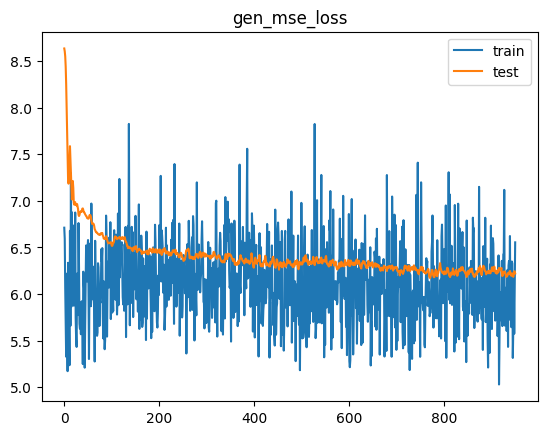

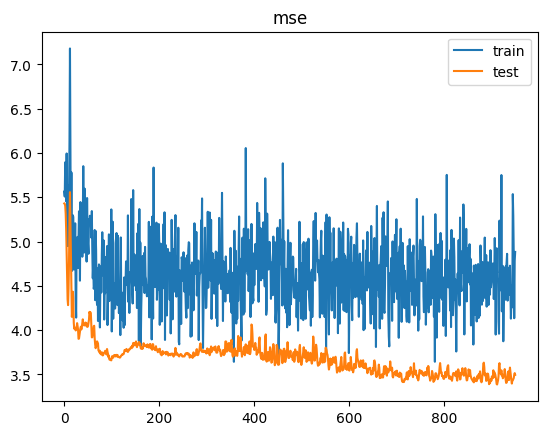

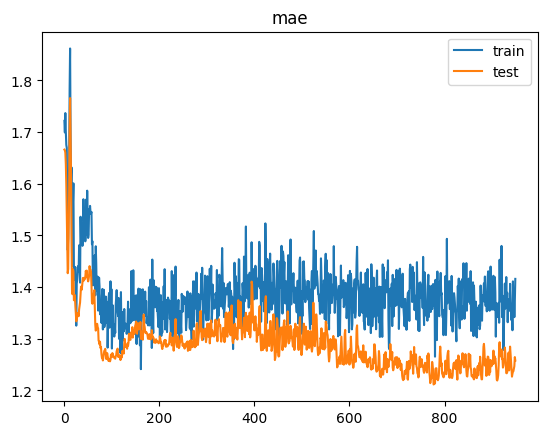

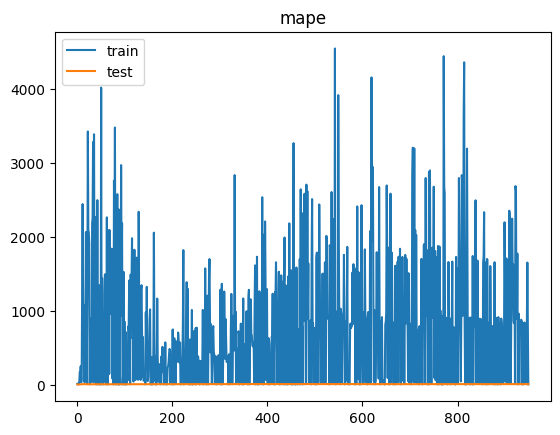

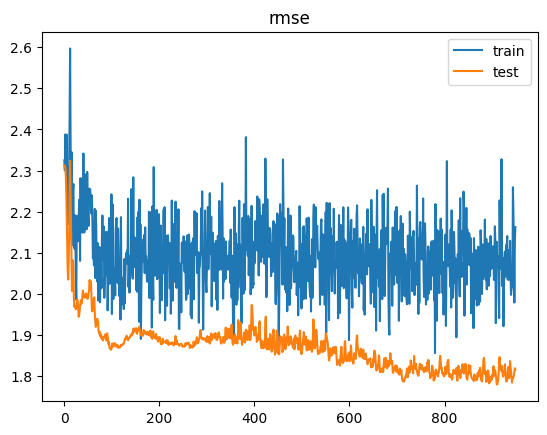

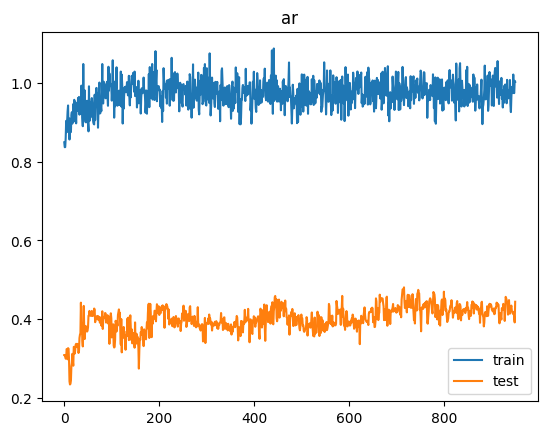

2/2 [==============================] - 1s 3ms/step


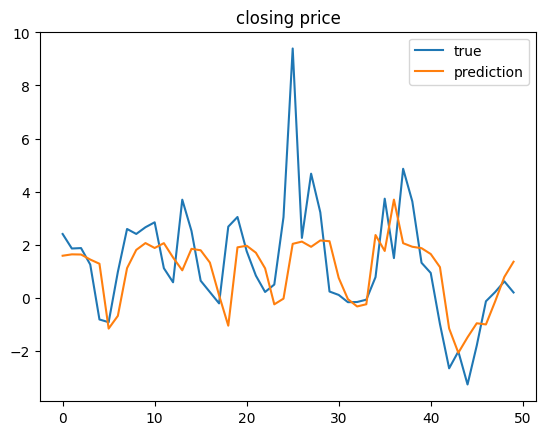

[MSE Baseline] train: 4.4473531003469375  test: 3.7469059248471765
Delta time with epochs = 950: 0:08:29.978583
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 5, 7)]       0           []                               
                                                                                                  
 bidirectional_8 (Bidirectional  (None, 5, 20)       1440        ['input_5[0][0]']                
 )                                                                                                
                                                                                                  
 concatenate_4 (Concatenate)    (None, 5, 27)        0           ['bidirectional_8[0][0]',        
                                                                  'input_5[0][0

Time for epoch 46 is 0.49837207794189453 sec Generator Loss: 0.9189267754554749,  Discriminator_loss: 1.2694942951202393
Time for epoch 47 is 0.49413084983825684 sec Generator Loss: 0.9099305272102356,  Discriminator_loss: 1.2689321041107178
Time for epoch 48 is 0.52571702003479 sec Generator Loss: 0.9258583784103394,  Discriminator_loss: 1.2540557384490967
Time for epoch 49 is 0.48940491676330566 sec Generator Loss: 0.9112515449523926,  Discriminator_loss: 1.2719800472259521
Time for epoch 50 is 0.5207407474517822 sec Generator Loss: 0.9011055827140808,  Discriminator_loss: 1.2802565097808838
Time for epoch 51 is 0.5353140830993652 sec Generator Loss: 0.8845660090446472,  Discriminator_loss: 1.2888085842132568
Time for epoch 52 is 0.5434513092041016 sec Generator Loss: 0.9053645730018616,  Discriminator_loss: 1.2826849222183228
Time for epoch 53 is 0.5194258689880371 sec Generator Loss: 0.9051591157913208,  Discriminator_loss: 1.2957985401153564
Time for epoch 54 is 0.5174729824066162

Time for epoch 115 is 0.5015599727630615 sec Generator Loss: 0.8215715885162354,  Discriminator_loss: 1.3356044292449951
Time for epoch 116 is 0.48851966857910156 sec Generator Loss: 0.8356336951255798,  Discriminator_loss: 1.327521800994873
Time for epoch 117 is 0.4900245666503906 sec Generator Loss: 0.8139848113059998,  Discriminator_loss: 1.3381084203720093
Time for epoch 118 is 0.48885178565979004 sec Generator Loss: 0.8312268853187561,  Discriminator_loss: 1.3283385038375854
Time for epoch 119 is 0.4872927665710449 sec Generator Loss: 0.8310903906822205,  Discriminator_loss: 1.3322395086288452
Time for epoch 120 is 0.5028653144836426 sec Generator Loss: 0.817426860332489,  Discriminator_loss: 1.3368159532546997
Time for epoch 121 is 0.4948878288269043 sec Generator Loss: 0.8078345656394958,  Discriminator_loss: 1.3371363878250122
Time for epoch 122 is 0.48601436614990234 sec Generator Loss: 0.8297286629676819,  Discriminator_loss: 1.32976233959198
Time for epoch 123 is 0.494193077

Time for epoch 183 is 0.4995729923248291 sec Generator Loss: 0.8403705358505249,  Discriminator_loss: 1.322173833847046
Time for epoch 184 is 0.4969065189361572 sec Generator Loss: 0.8269507884979248,  Discriminator_loss: 1.327171802520752
Time for epoch 185 is 0.505368709564209 sec Generator Loss: 0.8331515789031982,  Discriminator_loss: 1.321955919265747
Time for epoch 186 is 0.4877622127532959 sec Generator Loss: 0.8292644619941711,  Discriminator_loss: 1.325649619102478
Time for epoch 187 is 0.4866797924041748 sec Generator Loss: 0.8535077571868896,  Discriminator_loss: 1.312759280204773
Time for epoch 188 is 0.4963686466217041 sec Generator Loss: 0.8261095285415649,  Discriminator_loss: 1.3348380327224731
Time for epoch 189 is 0.4955589771270752 sec Generator Loss: 0.8309822678565979,  Discriminator_loss: 1.3207111358642578
Time for epoch 190 is 0.5026347637176514 sec Generator Loss: 0.8358830809593201,  Discriminator_loss: 1.3162072896957397
Time for epoch 191 is 0.48774957656860

Time for epoch 251 is 0.5033085346221924 sec Generator Loss: 0.8161833882331848,  Discriminator_loss: 1.3345900774002075
Time for epoch 252 is 0.4963231086730957 sec Generator Loss: 0.8365558385848999,  Discriminator_loss: 1.3365598917007446
Time for epoch 253 is 0.4964768886566162 sec Generator Loss: 0.8205112218856812,  Discriminator_loss: 1.3261592388153076
Time for epoch 254 is 0.4921276569366455 sec Generator Loss: 0.8321326971054077,  Discriminator_loss: 1.335593342781067
Time for epoch 255 is 0.5073459148406982 sec Generator Loss: 0.8353056311607361,  Discriminator_loss: 1.3268908262252808
Time for epoch 256 is 0.49704647064208984 sec Generator Loss: 0.8284181356430054,  Discriminator_loss: 1.3251105546951294
Time for epoch 257 is 0.4922785758972168 sec Generator Loss: 0.8200566172599792,  Discriminator_loss: 1.3363889455795288
Time for epoch 258 is 0.4966583251953125 sec Generator Loss: 0.8355706334114075,  Discriminator_loss: 1.329042673110962
Time for epoch 259 is 0.487305402

Time for epoch 319 is 0.5054938793182373 sec Generator Loss: 0.814887523651123,  Discriminator_loss: 1.343466877937317
Time for epoch 320 is 0.48981523513793945 sec Generator Loss: 0.827444314956665,  Discriminator_loss: 1.3265496492385864
Time for epoch 321 is 0.4896385669708252 sec Generator Loss: 0.8155797719955444,  Discriminator_loss: 1.3312805891036987
Time for epoch 322 is 0.4875526428222656 sec Generator Loss: 0.837761640548706,  Discriminator_loss: 1.3243143558502197
Time for epoch 323 is 0.4879953861236572 sec Generator Loss: 0.8313906788825989,  Discriminator_loss: 1.3370097875595093
Time for epoch 324 is 0.48923826217651367 sec Generator Loss: 0.8219633102416992,  Discriminator_loss: 1.3284642696380615
Time for epoch 325 is 0.4885599613189697 sec Generator Loss: 0.8142353892326355,  Discriminator_loss: 1.3440492153167725
Time for epoch 326 is 0.48981475830078125 sec Generator Loss: 0.8231887817382812,  Discriminator_loss: 1.332048773765564
Time for epoch 327 is 0.4903972148

Time for epoch 387 is 0.529670238494873 sec Generator Loss: 0.8275150656700134,  Discriminator_loss: 1.3284997940063477
Time for epoch 388 is 0.4859910011291504 sec Generator Loss: 0.8334317803382874,  Discriminator_loss: 1.3236372470855713
Time for epoch 389 is 0.4946880340576172 sec Generator Loss: 0.82313472032547,  Discriminator_loss: 1.3389266729354858
Time for epoch 390 is 0.48996472358703613 sec Generator Loss: 0.8350771069526672,  Discriminator_loss: 1.3295798301696777
Time for epoch 391 is 0.4856436252593994 sec Generator Loss: 0.8322418928146362,  Discriminator_loss: 1.3348878622055054
Time for epoch 392 is 0.4840731620788574 sec Generator Loss: 0.814950168132782,  Discriminator_loss: 1.3391941785812378
Time for epoch 393 is 0.5158872604370117 sec Generator Loss: 0.837195873260498,  Discriminator_loss: 1.325871467590332
Time for epoch 394 is 0.48609232902526855 sec Generator Loss: 0.8205142617225647,  Discriminator_loss: 1.3362183570861816
Time for epoch 395 is 0.502077817916

Time for epoch 455 is 0.5210738182067871 sec Generator Loss: 0.8230785727500916,  Discriminator_loss: 1.3407384157180786
Time for epoch 456 is 0.5332131385803223 sec Generator Loss: 0.8363475799560547,  Discriminator_loss: 1.3289976119995117
Time for epoch 457 is 0.547553539276123 sec Generator Loss: 0.8204955458641052,  Discriminator_loss: 1.3355741500854492
Time for epoch 458 is 0.5271520614624023 sec Generator Loss: 0.8440672159194946,  Discriminator_loss: 1.3359220027923584
Time for epoch 459 is 0.532036304473877 sec Generator Loss: 0.8212813138961792,  Discriminator_loss: 1.3432117700576782
Time for epoch 460 is 0.5127699375152588 sec Generator Loss: 0.8354063034057617,  Discriminator_loss: 1.3308802843093872
Time for epoch 461 is 0.5064327716827393 sec Generator Loss: 0.8407905101776123,  Discriminator_loss: 1.3328145742416382
Time for epoch 462 is 0.5373444557189941 sec Generator Loss: 0.821133553981781,  Discriminator_loss: 1.336663007736206
Time for epoch 463 is 0.533709764480

Time for epoch 524 is 0.5718975067138672 sec Generator Loss: 0.8261618614196777,  Discriminator_loss: 1.338110089302063
Time for epoch 525 is 0.5761942863464355 sec Generator Loss: 0.84615558385849,  Discriminator_loss: 1.326447606086731
Time for epoch 526 is 0.6129047870635986 sec Generator Loss: 0.8369990587234497,  Discriminator_loss: 1.3162052631378174
Time for epoch 527 is 0.5808594226837158 sec Generator Loss: 0.846010148525238,  Discriminator_loss: 1.3145209550857544
Time for epoch 528 is 0.5396220684051514 sec Generator Loss: 0.8493538498878479,  Discriminator_loss: 1.3241649866104126
Time for epoch 529 is 0.5484857559204102 sec Generator Loss: 0.8584131598472595,  Discriminator_loss: 1.3068915605545044
Time for epoch 530 is 0.5318715572357178 sec Generator Loss: 0.8284708261489868,  Discriminator_loss: 1.330485463142395
Time for epoch 531 is 0.5334081649780273 sec Generator Loss: 0.8444302678108215,  Discriminator_loss: 1.3278957605361938
Time for epoch 532 is 0.52747201919555

Time for epoch 592 is 0.5333786010742188 sec Generator Loss: 0.8512633442878723,  Discriminator_loss: 1.315090537071228
Time for epoch 593 is 0.5076618194580078 sec Generator Loss: 0.8558852076530457,  Discriminator_loss: 1.3247995376586914
Time for epoch 594 is 0.5238823890686035 sec Generator Loss: 0.8402659893035889,  Discriminator_loss: 1.3340758085250854
Time for epoch 595 is 0.5307488441467285 sec Generator Loss: 0.840919554233551,  Discriminator_loss: 1.3253017663955688
Time for epoch 596 is 0.5427591800689697 sec Generator Loss: 0.8620069622993469,  Discriminator_loss: 1.32243812084198
Time for epoch 597 is 0.531078577041626 sec Generator Loss: 0.8304262757301331,  Discriminator_loss: 1.3321527242660522
Time for epoch 598 is 0.5203168392181396 sec Generator Loss: 0.8359788656234741,  Discriminator_loss: 1.3303484916687012
Time for epoch 599 is 0.5192828178405762 sec Generator Loss: 0.8303465843200684,  Discriminator_loss: 1.3218450546264648
Time for epoch 600 is 0.5265319347381

Time for epoch 660 is 0.49344897270202637 sec Generator Loss: 0.852249801158905,  Discriminator_loss: 1.3213380575180054
Time for epoch 661 is 0.4912600517272949 sec Generator Loss: 0.8535791635513306,  Discriminator_loss: 1.3204374313354492
Time for epoch 662 is 0.4961104393005371 sec Generator Loss: 0.8508970141410828,  Discriminator_loss: 1.3165521621704102
Time for epoch 663 is 0.5052585601806641 sec Generator Loss: 0.8459165692329407,  Discriminator_loss: 1.3189080953598022
Time for epoch 664 is 0.488814115524292 sec Generator Loss: 0.8433870673179626,  Discriminator_loss: 1.332374095916748
Time for epoch 665 is 0.49007368087768555 sec Generator Loss: 0.85752934217453,  Discriminator_loss: 1.3146958351135254
Time for epoch 666 is 0.4909682273864746 sec Generator Loss: 0.8503239154815674,  Discriminator_loss: 1.325640082359314
Time for epoch 667 is 0.4960365295410156 sec Generator Loss: 0.8414379954338074,  Discriminator_loss: 1.336685061454773
Time for epoch 668 is 0.4969747066497

Time for epoch 728 is 0.5313873291015625 sec Generator Loss: 0.8440461754798889,  Discriminator_loss: 1.3236867189407349
Time for epoch 729 is 0.5212862491607666 sec Generator Loss: 0.844982922077179,  Discriminator_loss: 1.3240171670913696
Time for epoch 730 is 0.5244112014770508 sec Generator Loss: 0.8611127734184265,  Discriminator_loss: 1.3121037483215332
Time for epoch 731 is 0.5281274318695068 sec Generator Loss: 0.8641566038131714,  Discriminator_loss: 1.3167141675949097
Time for epoch 732 is 0.5550012588500977 sec Generator Loss: 0.8452813625335693,  Discriminator_loss: 1.3263216018676758
Time for epoch 733 is 0.5377769470214844 sec Generator Loss: 0.8614277839660645,  Discriminator_loss: 1.308928370475769
Time for epoch 734 is 0.5396463871002197 sec Generator Loss: 0.8569071292877197,  Discriminator_loss: 1.3205597400665283
Time for epoch 735 is 0.528728723526001 sec Generator Loss: 0.8514152765274048,  Discriminator_loss: 1.3103816509246826
Time for epoch 736 is 0.54102635383

Time for epoch 796 is 0.48943424224853516 sec Generator Loss: 0.8513851165771484,  Discriminator_loss: 1.3234739303588867
Time for epoch 797 is 0.4896986484527588 sec Generator Loss: 0.8650830984115601,  Discriminator_loss: 1.3163089752197266
Time for epoch 798 is 0.492800235748291 sec Generator Loss: 0.8703262805938721,  Discriminator_loss: 1.3235464096069336
Time for epoch 799 is 0.486344575881958 sec Generator Loss: 0.8603731393814087,  Discriminator_loss: 1.314724087715149
Time for epoch 800 is 0.4936096668243408 sec Generator Loss: 0.8693792819976807,  Discriminator_loss: 1.3043063879013062
Time for epoch 801 is 0.510106086730957 sec Generator Loss: 0.8598924279212952,  Discriminator_loss: 1.3222423791885376
Time for epoch 802 is 0.4954259395599365 sec Generator Loss: 0.8667693734169006,  Discriminator_loss: 1.3183807134628296
Time for epoch 803 is 0.509291410446167 sec Generator Loss: 0.8470830321311951,  Discriminator_loss: 1.3397630453109741
Time for epoch 804 is 0.496161699295

Time for epoch 864 is 0.5696508884429932 sec Generator Loss: 0.8629024624824524,  Discriminator_loss: 1.3109713792800903
Time for epoch 865 is 0.5677957534790039 sec Generator Loss: 0.8695505857467651,  Discriminator_loss: 1.312102198600769
Time for epoch 866 is 0.5412032604217529 sec Generator Loss: 0.8694300651550293,  Discriminator_loss: 1.3213739395141602
Time for epoch 867 is 0.5461032390594482 sec Generator Loss: 0.8437491059303284,  Discriminator_loss: 1.3345614671707153
Time for epoch 868 is 0.5272486209869385 sec Generator Loss: 0.8624510169029236,  Discriminator_loss: 1.3164585828781128
Time for epoch 869 is 0.5093395709991455 sec Generator Loss: 0.8526577353477478,  Discriminator_loss: 1.3157188892364502
Time for epoch 870 is 0.5255448818206787 sec Generator Loss: 0.83953857421875,  Discriminator_loss: 1.3261375427246094
Time for epoch 871 is 0.5324983596801758 sec Generator Loss: 0.8533893823623657,  Discriminator_loss: 1.3171778917312622
Time for epoch 872 is 0.56260514259

Time for epoch 932 is 0.4845719337463379 sec Generator Loss: 0.873531699180603,  Discriminator_loss: 1.3067762851715088
Time for epoch 933 is 0.5171310901641846 sec Generator Loss: 0.8646303415298462,  Discriminator_loss: 1.3156288862228394
Time for epoch 934 is 0.5385611057281494 sec Generator Loss: 0.8732544183731079,  Discriminator_loss: 1.3146740198135376
Time for epoch 935 is 0.5196981430053711 sec Generator Loss: 0.873046338558197,  Discriminator_loss: 1.3137986660003662
Time for epoch 936 is 0.5270228385925293 sec Generator Loss: 0.8586848378181458,  Discriminator_loss: 1.3148516416549683
Time for epoch 937 is 0.5309538841247559 sec Generator Loss: 0.8636171817779541,  Discriminator_loss: 1.3233585357666016
Time for epoch 938 is 0.5223510265350342 sec Generator Loss: 0.8737754225730896,  Discriminator_loss: 1.3080474138259888
Time for epoch 939 is 0.5298480987548828 sec Generator Loss: 0.8622941374778748,  Discriminator_loss: 1.3254650831222534
Time for epoch 940 is 0.4969072341

Time for epoch 1000 is 0.5791525840759277 sec Generator Loss: 0.88967365026474,  Discriminator_loss: 1.2985906600952148
Time for epoch 1001 is 0.5328168869018555 sec Generator Loss: 0.8648656010627747,  Discriminator_loss: 1.3191665410995483
Time for epoch 1002 is 0.531674861907959 sec Generator Loss: 0.8719224333763123,  Discriminator_loss: 1.3125184774398804
Time for epoch 1003 is 0.5203235149383545 sec Generator Loss: 0.88426673412323,  Discriminator_loss: 1.2989400625228882
Time for epoch 1004 is 0.5472691059112549 sec Generator Loss: 0.8721663355827332,  Discriminator_loss: 1.3110344409942627
Time for epoch 1005 is 0.539292573928833 sec Generator Loss: 0.8838001489639282,  Discriminator_loss: 1.3006607294082642
Time for epoch 1006 is 0.5082535743713379 sec Generator Loss: 0.8686692118644714,  Discriminator_loss: 1.3084461688995361
Time for epoch 1007 is 0.49899721145629883 sec Generator Loss: 0.8940119743347168,  Discriminator_loss: 1.291213870048523
Time for epoch 1008 is 0.49373

Time for epoch 1068 is 0.4946627616882324 sec Generator Loss: 0.8592032194137573,  Discriminator_loss: 1.3210208415985107
Time for epoch 1069 is 0.49114489555358887 sec Generator Loss: 0.8581854701042175,  Discriminator_loss: 1.3183318376541138
Time for epoch 1070 is 0.4946146011352539 sec Generator Loss: 0.8539098501205444,  Discriminator_loss: 1.3218492269515991
Time for epoch 1071 is 0.4921271800994873 sec Generator Loss: 0.8692195415496826,  Discriminator_loss: 1.305850863456726
Time for epoch 1072 is 0.4918644428253174 sec Generator Loss: 0.8658269047737122,  Discriminator_loss: 1.306658148765564
Time for epoch 1073 is 0.49517178535461426 sec Generator Loss: 0.8895441293716431,  Discriminator_loss: 1.302061676979065
Time for epoch 1074 is 0.47478413581848145 sec Generator Loss: 0.8599446415901184,  Discriminator_loss: 1.3231207132339478
Time for epoch 1075 is 0.467487096786499 sec Generator Loss: 0.8665763139724731,  Discriminator_loss: 1.3094865083694458
Time for epoch 1076 is 0.

Time for epoch 1136 is 0.48485374450683594 sec Generator Loss: 0.8768457770347595,  Discriminator_loss: 1.3024259805679321
Time for epoch 1137 is 0.4870760440826416 sec Generator Loss: 0.8653224110603333,  Discriminator_loss: 1.3127214908599854
Time for epoch 1138 is 0.49161648750305176 sec Generator Loss: 0.8580775856971741,  Discriminator_loss: 1.323809027671814
Time for epoch 1139 is 0.49552416801452637 sec Generator Loss: 0.8727672100067139,  Discriminator_loss: 1.309397578239441
Time for epoch 1140 is 0.4914247989654541 sec Generator Loss: 0.8632703423500061,  Discriminator_loss: 1.321330189704895
Time for epoch 1141 is 0.4945509433746338 sec Generator Loss: 0.8808796405792236,  Discriminator_loss: 1.3117963075637817
Time for epoch 1142 is 0.48973655700683594 sec Generator Loss: 0.8847074508666992,  Discriminator_loss: 1.3060485124588013
Time for epoch 1143 is 0.49980616569519043 sec Generator Loss: 0.8748274445533752,  Discriminator_loss: 1.3114001750946045
Time for epoch 1144 is

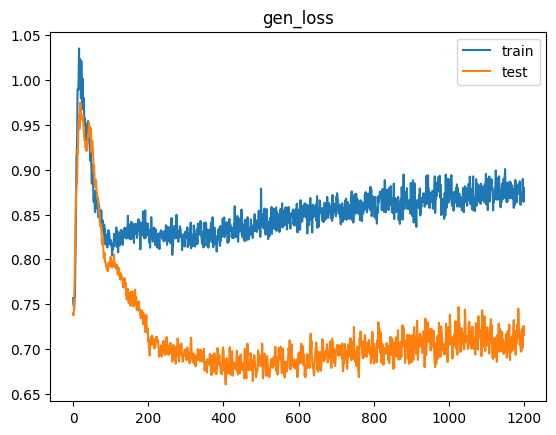

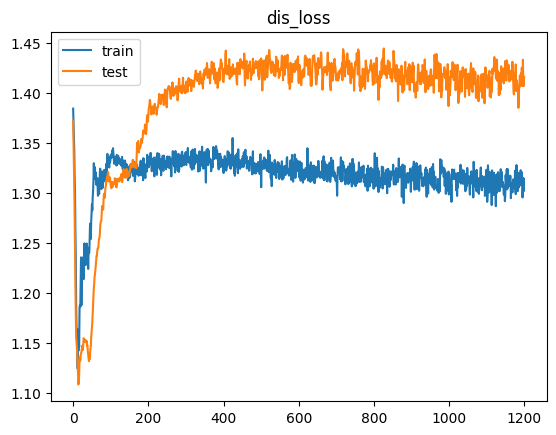

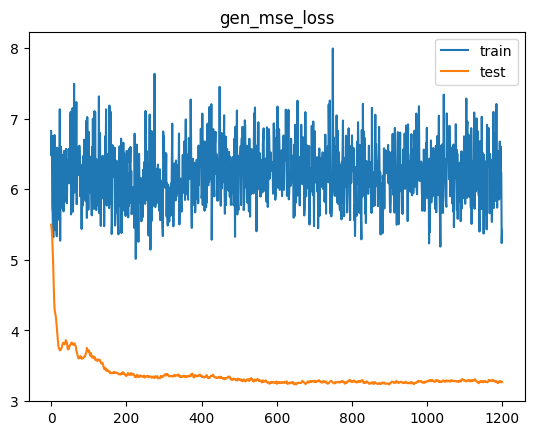

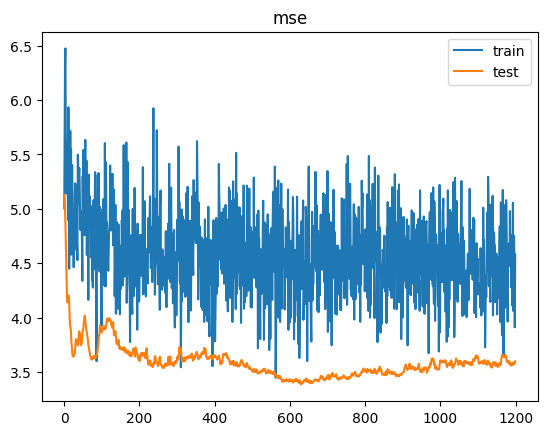

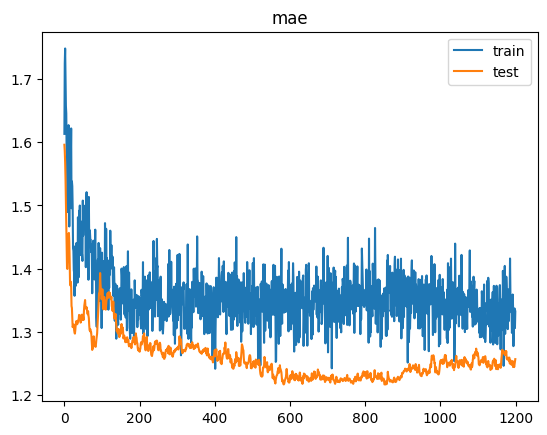

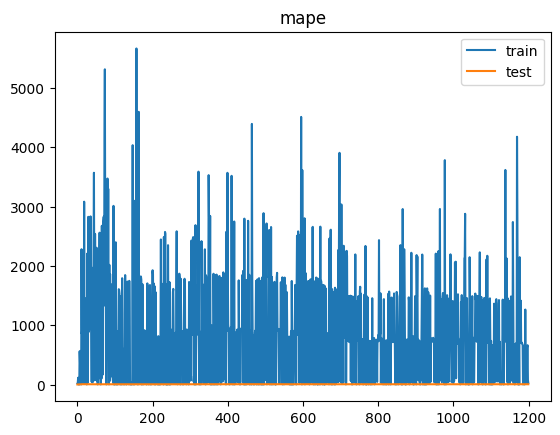

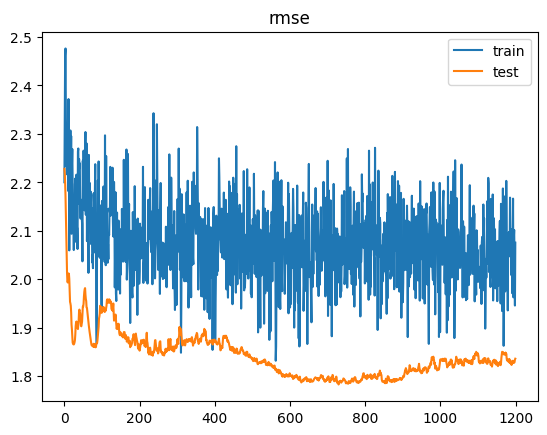

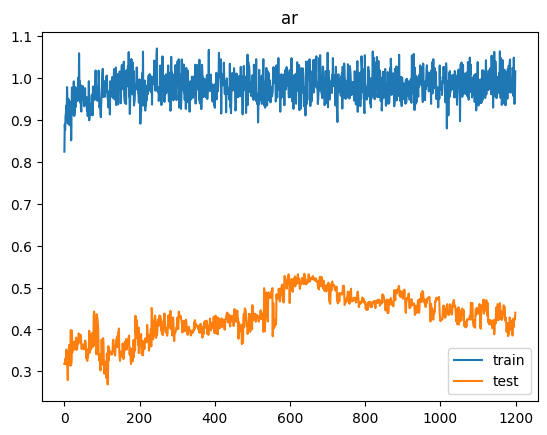

2/2 [==============================] - 0s 2ms/step


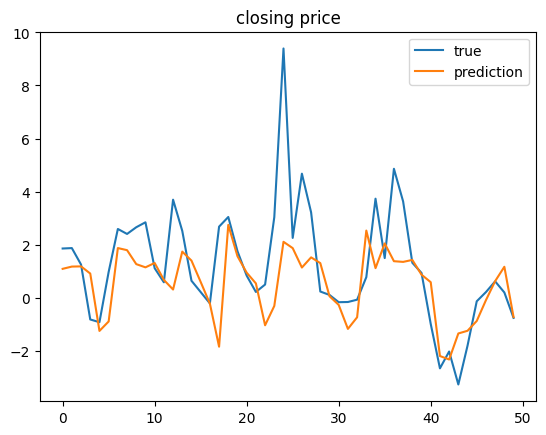

[MSE Baseline] train: 4.312511824622018  test: 3.665913330963867
Delta time with epochs = 1200: 0:10:33.132135
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 5, 7)]       0           []                               
                                                                                                  
 bidirectional_10 (Bidirectiona  (None, 5, 20)       1440        ['input_6[0][0]']                
 l)                                                                                               
                                                                                                  
 concatenate_5 (Concatenate)    (None, 5, 27)        0           ['bidirectional_10[0][0]',       
                                                                  'input_6[0][0]

Time for epoch 46 is 0.5106508731842041 sec Generator Loss: 0.981979489326477,  Discriminator_loss: 1.2286771535873413
Time for epoch 47 is 0.5340738296508789 sec Generator Loss: 0.977765679359436,  Discriminator_loss: 1.201456069946289
Time for epoch 48 is 0.517369270324707 sec Generator Loss: 0.9826292395591736,  Discriminator_loss: 1.213908076286316
Time for epoch 49 is 0.503544807434082 sec Generator Loss: 0.9779423475265503,  Discriminator_loss: 1.2093843221664429
Time for epoch 50 is 0.4860508441925049 sec Generator Loss: 0.985680103302002,  Discriminator_loss: 1.1985653638839722
Time for epoch 51 is 0.48686814308166504 sec Generator Loss: 0.9780920743942261,  Discriminator_loss: 1.206979513168335
Time for epoch 52 is 0.4924895763397217 sec Generator Loss: 0.9604876041412354,  Discriminator_loss: 1.2181426286697388
Time for epoch 53 is 0.4911692142486572 sec Generator Loss: 0.9652529358863831,  Discriminator_loss: 1.2167587280273438
Time for epoch 54 is 0.4853839874267578 sec Gen

Time for epoch 115 is 0.480618953704834 sec Generator Loss: 0.8443155288696289,  Discriminator_loss: 1.323286771774292
Time for epoch 116 is 0.4863111972808838 sec Generator Loss: 0.8277643918991089,  Discriminator_loss: 1.3314294815063477
Time for epoch 117 is 0.4809298515319824 sec Generator Loss: 0.8335416316986084,  Discriminator_loss: 1.330570936203003
Time for epoch 118 is 0.4842097759246826 sec Generator Loss: 0.8272697329521179,  Discriminator_loss: 1.3296265602111816
Time for epoch 119 is 0.47747325897216797 sec Generator Loss: 0.8217971324920654,  Discriminator_loss: 1.331395149230957
Time for epoch 120 is 0.48316502571105957 sec Generator Loss: 0.8265503644943237,  Discriminator_loss: 1.3262220621109009
Time for epoch 121 is 0.48708057403564453 sec Generator Loss: 0.8365679979324341,  Discriminator_loss: 1.3117700815200806
Time for epoch 122 is 0.5012068748474121 sec Generator Loss: 0.8201373219490051,  Discriminator_loss: 1.3287856578826904
Time for epoch 123 is 0.528685808

Time for epoch 183 is 0.49762821197509766 sec Generator Loss: 0.8133828639984131,  Discriminator_loss: 1.337222933769226
Time for epoch 184 is 0.486771821975708 sec Generator Loss: 0.8223286271095276,  Discriminator_loss: 1.3355761766433716
Time for epoch 185 is 0.49356961250305176 sec Generator Loss: 0.8182620406150818,  Discriminator_loss: 1.3347594738006592
Time for epoch 186 is 0.48990559577941895 sec Generator Loss: 0.8195374011993408,  Discriminator_loss: 1.3307099342346191
Time for epoch 187 is 0.4880843162536621 sec Generator Loss: 0.8159638047218323,  Discriminator_loss: 1.343766450881958
Time for epoch 188 is 0.48484158515930176 sec Generator Loss: 0.8082192540168762,  Discriminator_loss: 1.345261812210083
Time for epoch 189 is 0.49135923385620117 sec Generator Loss: 0.8119163513183594,  Discriminator_loss: 1.3402193784713745
Time for epoch 190 is 0.48603320121765137 sec Generator Loss: 0.8116545081138611,  Discriminator_loss: 1.3413630723953247
Time for epoch 191 is 0.487201

Time for epoch 251 is 0.5657508373260498 sec Generator Loss: 0.8228643536567688,  Discriminator_loss: 1.3324023485183716
Time for epoch 252 is 0.5319421291351318 sec Generator Loss: 0.8134723901748657,  Discriminator_loss: 1.3294638395309448
Time for epoch 253 is 0.5116791725158691 sec Generator Loss: 0.8220635652542114,  Discriminator_loss: 1.336614727973938
Time for epoch 254 is 0.5229482650756836 sec Generator Loss: 0.8169585466384888,  Discriminator_loss: 1.3378297090530396
Time for epoch 255 is 0.5211286544799805 sec Generator Loss: 0.8103994131088257,  Discriminator_loss: 1.3348513841629028
Time for epoch 256 is 0.5074186325073242 sec Generator Loss: 0.8269153833389282,  Discriminator_loss: 1.33598792552948
Time for epoch 257 is 0.5142250061035156 sec Generator Loss: 0.8180873394012451,  Discriminator_loss: 1.3375502824783325
Time for epoch 258 is 0.5393741130828857 sec Generator Loss: 0.8290493488311768,  Discriminator_loss: 1.3298879861831665
Time for epoch 259 is 0.51681184768

Time for epoch 320 is 0.5155110359191895 sec Generator Loss: 0.831508994102478,  Discriminator_loss: 1.3243868350982666
Time for epoch 321 is 0.5330007076263428 sec Generator Loss: 0.8195287585258484,  Discriminator_loss: 1.3298718929290771
Time for epoch 322 is 0.5242488384246826 sec Generator Loss: 0.8221287131309509,  Discriminator_loss: 1.3299648761749268
Time for epoch 323 is 0.5352647304534912 sec Generator Loss: 0.8183261752128601,  Discriminator_loss: 1.339771032333374
Time for epoch 324 is 0.5362193584442139 sec Generator Loss: 0.8180615305900574,  Discriminator_loss: 1.3324710130691528
Time for epoch 325 is 0.5162754058837891 sec Generator Loss: 0.8236764669418335,  Discriminator_loss: 1.3363710641860962
Time for epoch 326 is 0.4843020439147949 sec Generator Loss: 0.8196325302124023,  Discriminator_loss: 1.3421623706817627
Time for epoch 327 is 0.4978454113006592 sec Generator Loss: 0.8163734674453735,  Discriminator_loss: 1.3351540565490723
Time for epoch 328 is 0.4821867942

Time for epoch 388 is 0.5137443542480469 sec Generator Loss: 0.8040571212768555,  Discriminator_loss: 1.3348417282104492
Time for epoch 389 is 0.5348107814788818 sec Generator Loss: 0.8153138756752014,  Discriminator_loss: 1.334346890449524
Time for epoch 390 is 0.547900915145874 sec Generator Loss: 0.8168049454689026,  Discriminator_loss: 1.3437633514404297
Time for epoch 391 is 0.5228731632232666 sec Generator Loss: 0.823215901851654,  Discriminator_loss: 1.3304784297943115
Time for epoch 392 is 0.5143675804138184 sec Generator Loss: 0.8150309324264526,  Discriminator_loss: 1.3348244428634644
Time for epoch 393 is 0.5247228145599365 sec Generator Loss: 0.8257357478141785,  Discriminator_loss: 1.3310883045196533
Time for epoch 394 is 0.538834810256958 sec Generator Loss: 0.8281939625740051,  Discriminator_loss: 1.329504132270813
Time for epoch 395 is 0.49959397315979004 sec Generator Loss: 0.8208775520324707,  Discriminator_loss: 1.3309218883514404
Time for epoch 396 is 0.522017002105

Time for epoch 456 is 0.5735213756561279 sec Generator Loss: 0.8307698965072632,  Discriminator_loss: 1.3313781023025513
Time for epoch 457 is 0.5445473194122314 sec Generator Loss: 0.8202886581420898,  Discriminator_loss: 1.3267507553100586
Time for epoch 458 is 0.5562853813171387 sec Generator Loss: 0.834885835647583,  Discriminator_loss: 1.3256276845932007
Time for epoch 459 is 0.594458818435669 sec Generator Loss: 0.8291639685630798,  Discriminator_loss: 1.3244102001190186
Time for epoch 460 is 0.5534801483154297 sec Generator Loss: 0.8200638294219971,  Discriminator_loss: 1.3401367664337158
Time for epoch 461 is 0.5454587936401367 sec Generator Loss: 0.8226277828216553,  Discriminator_loss: 1.3323137760162354
Time for epoch 462 is 0.4974842071533203 sec Generator Loss: 0.8354966044425964,  Discriminator_loss: 1.3293687105178833
Time for epoch 463 is 0.5510787963867188 sec Generator Loss: 0.836178719997406,  Discriminator_loss: 1.3253263235092163
Time for epoch 464 is 0.52509737014

Time for epoch 524 is 0.5257577896118164 sec Generator Loss: 0.8479964137077332,  Discriminator_loss: 1.3243465423583984
Time for epoch 525 is 0.5202722549438477 sec Generator Loss: 0.8293813467025757,  Discriminator_loss: 1.3359326124191284
Time for epoch 526 is 0.5156090259552002 sec Generator Loss: 0.8318662047386169,  Discriminator_loss: 1.319707989692688
Time for epoch 527 is 0.5297605991363525 sec Generator Loss: 0.8230684399604797,  Discriminator_loss: 1.3363311290740967
Time for epoch 528 is 0.5235705375671387 sec Generator Loss: 0.8351297378540039,  Discriminator_loss: 1.3328922986984253
Time for epoch 529 is 0.5392553806304932 sec Generator Loss: 0.8294858336448669,  Discriminator_loss: 1.329087495803833
Time for epoch 530 is 0.5133869647979736 sec Generator Loss: 0.8357360363006592,  Discriminator_loss: 1.3345566987991333
Time for epoch 531 is 0.5002200603485107 sec Generator Loss: 0.8346065878868103,  Discriminator_loss: 1.3278712034225464
Time for epoch 532 is 0.5472767353

Time for epoch 592 is 0.4861025810241699 sec Generator Loss: 0.844740629196167,  Discriminator_loss: 1.3123743534088135
Time for epoch 593 is 0.49033188819885254 sec Generator Loss: 0.8468942046165466,  Discriminator_loss: 1.3119962215423584
Time for epoch 594 is 0.5019421577453613 sec Generator Loss: 0.8584607243537903,  Discriminator_loss: 1.313698410987854
Time for epoch 595 is 0.49553942680358887 sec Generator Loss: 0.8407807946205139,  Discriminator_loss: 1.3274288177490234
Time for epoch 596 is 0.4890618324279785 sec Generator Loss: 0.8460262417793274,  Discriminator_loss: 1.3188093900680542
Time for epoch 597 is 0.48436713218688965 sec Generator Loss: 0.8383957147598267,  Discriminator_loss: 1.3197845220565796
Time for epoch 598 is 0.5079624652862549 sec Generator Loss: 0.8363344669342041,  Discriminator_loss: 1.3253837823867798
Time for epoch 599 is 0.48709607124328613 sec Generator Loss: 0.842683732509613,  Discriminator_loss: 1.322649359703064
Time for epoch 600 is 0.48737215

Time for epoch 660 is 0.5137748718261719 sec Generator Loss: 0.8484116792678833,  Discriminator_loss: 1.3154313564300537
Time for epoch 661 is 0.5497102737426758 sec Generator Loss: 0.8534717559814453,  Discriminator_loss: 1.3200526237487793
Time for epoch 662 is 0.5315594673156738 sec Generator Loss: 0.8530358076095581,  Discriminator_loss: 1.3115347623825073
Time for epoch 663 is 0.5488345623016357 sec Generator Loss: 0.8468616008758545,  Discriminator_loss: 1.3168553113937378
Time for epoch 664 is 0.5246832370758057 sec Generator Loss: 0.8528686761856079,  Discriminator_loss: 1.3116488456726074
Time for epoch 665 is 0.5209488868713379 sec Generator Loss: 0.8460362553596497,  Discriminator_loss: 1.317879319190979
Time for epoch 666 is 0.5230066776275635 sec Generator Loss: 0.8504210114479065,  Discriminator_loss: 1.313783049583435
Time for epoch 667 is 0.5386724472045898 sec Generator Loss: 0.85575270652771,  Discriminator_loss: 1.3092221021652222
Time for epoch 668 is 0.522143125534

Time for epoch 729 is 0.5363051891326904 sec Generator Loss: 0.8604602813720703,  Discriminator_loss: 1.3058573007583618
Time for epoch 730 is 0.5726826190948486 sec Generator Loss: 0.8588206768035889,  Discriminator_loss: 1.314692497253418
Time for epoch 731 is 0.5197849273681641 sec Generator Loss: 0.8566923141479492,  Discriminator_loss: 1.3143205642700195
Time for epoch 732 is 0.5140612125396729 sec Generator Loss: 0.8441802263259888,  Discriminator_loss: 1.3227359056472778
Time for epoch 733 is 0.5055632591247559 sec Generator Loss: 0.8572196960449219,  Discriminator_loss: 1.3070800304412842
Time for epoch 734 is 0.5034890174865723 sec Generator Loss: 0.8633890151977539,  Discriminator_loss: 1.3080466985702515
Time for epoch 735 is 0.5032453536987305 sec Generator Loss: 0.8494194746017456,  Discriminator_loss: 1.3191215991973877
Time for epoch 736 is 0.49501848220825195 sec Generator Loss: 0.8638672828674316,  Discriminator_loss: 1.3216582536697388
Time for epoch 737 is 0.50263619

Time for epoch 798 is 0.5184977054595947 sec Generator Loss: 0.8553186058998108,  Discriminator_loss: 1.3100906610488892
Time for epoch 799 is 0.5030801296234131 sec Generator Loss: 0.8674510717391968,  Discriminator_loss: 1.3027170896530151
Time for epoch 800 is 0.508190393447876 sec Generator Loss: 0.8479318618774414,  Discriminator_loss: 1.3202779293060303
Time for epoch 801 is 0.5044658184051514 sec Generator Loss: 0.8626149892807007,  Discriminator_loss: 1.3115427494049072
Time for epoch 802 is 0.5210990905761719 sec Generator Loss: 0.8580353856086731,  Discriminator_loss: 1.3106390237808228
Time for epoch 803 is 0.5178718566894531 sec Generator Loss: 0.8702722191810608,  Discriminator_loss: 1.3057681322097778
Time for epoch 804 is 0.5157759189605713 sec Generator Loss: 0.8489201068878174,  Discriminator_loss: 1.319636583328247
Time for epoch 805 is 0.5081374645233154 sec Generator Loss: 0.8632187247276306,  Discriminator_loss: 1.291972279548645
Time for epoch 806 is 0.51300930976

Time for epoch 866 is 0.5360085964202881 sec Generator Loss: 0.8709720373153687,  Discriminator_loss: 1.3056719303131104
Time for epoch 867 is 0.5612397193908691 sec Generator Loss: 0.8875020146369934,  Discriminator_loss: 1.297714114189148
Time for epoch 868 is 0.5662877559661865 sec Generator Loss: 0.8666722178459167,  Discriminator_loss: 1.3141825199127197
Time for epoch 869 is 0.5482728481292725 sec Generator Loss: 0.8670369386672974,  Discriminator_loss: 1.3070025444030762
Time for epoch 870 is 0.5765783786773682 sec Generator Loss: 0.8867415189743042,  Discriminator_loss: 1.3161805868148804
Time for epoch 871 is 0.5624868869781494 sec Generator Loss: 0.873741626739502,  Discriminator_loss: 1.3035831451416016
Time for epoch 872 is 0.5346896648406982 sec Generator Loss: 0.8797669410705566,  Discriminator_loss: 1.2985371351242065
Time for epoch 873 is 0.5104975700378418 sec Generator Loss: 0.8803306221961975,  Discriminator_loss: 1.2988179922103882
Time for epoch 874 is 0.5399353504

Time for epoch 935 is 0.536571741104126 sec Generator Loss: 0.8787052035331726,  Discriminator_loss: 1.308768391609192
Time for epoch 936 is 0.5384621620178223 sec Generator Loss: 0.8796245455741882,  Discriminator_loss: 1.3066154718399048
Time for epoch 937 is 0.5227992534637451 sec Generator Loss: 0.8861846923828125,  Discriminator_loss: 1.2898664474487305
Time for epoch 938 is 0.52327561378479 sec Generator Loss: 0.8552847504615784,  Discriminator_loss: 1.3155560493469238
Time for epoch 939 is 0.5306556224822998 sec Generator Loss: 0.8737064599990845,  Discriminator_loss: 1.2901508808135986
Time for epoch 940 is 0.534238338470459 sec Generator Loss: 0.858189582824707,  Discriminator_loss: 1.304328441619873
Time for epoch 941 is 0.5012078285217285 sec Generator Loss: 0.8698374032974243,  Discriminator_loss: 1.311835765838623
Time for epoch 942 is 0.5009191036224365 sec Generator Loss: 0.8613376021385193,  Discriminator_loss: 1.2980557680130005
Time for epoch 943 is 0.5083096027374268

Time for epoch 1003 is 0.5496368408203125 sec Generator Loss: 0.8652229905128479,  Discriminator_loss: 1.3072861433029175
Time for epoch 1004 is 0.5724618434906006 sec Generator Loss: 0.8738371729850769,  Discriminator_loss: 1.3044722080230713
Time for epoch 1005 is 0.5384559631347656 sec Generator Loss: 0.8866970539093018,  Discriminator_loss: 1.293854832649231
Time for epoch 1006 is 0.5407745838165283 sec Generator Loss: 0.895105242729187,  Discriminator_loss: 1.2847718000411987
Time for epoch 1007 is 0.534520149230957 sec Generator Loss: 0.8937081694602966,  Discriminator_loss: 1.28810715675354
Time for epoch 1008 is 0.5363719463348389 sec Generator Loss: 0.8682253360748291,  Discriminator_loss: 1.3187282085418701
Time for epoch 1009 is 0.532029390335083 sec Generator Loss: 0.8933121562004089,  Discriminator_loss: 1.302996039390564
Time for epoch 1010 is 0.5935211181640625 sec Generator Loss: 0.8744581341743469,  Discriminator_loss: 1.3085790872573853
Time for epoch 1011 is 0.548625

Time for epoch 1071 is 0.500009298324585 sec Generator Loss: 0.856804609298706,  Discriminator_loss: 1.312046766281128
Time for epoch 1072 is 0.4939610958099365 sec Generator Loss: 0.8790978193283081,  Discriminator_loss: 1.2951503992080688
Time for epoch 1073 is 0.49866223335266113 sec Generator Loss: 0.8795416355133057,  Discriminator_loss: 1.2981505393981934
Time for epoch 1074 is 0.49753332138061523 sec Generator Loss: 0.9066805243492126,  Discriminator_loss: 1.2893956899642944
Time for epoch 1075 is 0.5055351257324219 sec Generator Loss: 0.8811925649642944,  Discriminator_loss: 1.296144962310791
Time for epoch 1076 is 0.5219533443450928 sec Generator Loss: 0.8684020638465881,  Discriminator_loss: 1.3043415546417236
Time for epoch 1077 is 0.5072116851806641 sec Generator Loss: 0.8832595348358154,  Discriminator_loss: 1.3011540174484253
Time for epoch 1078 is 0.5104687213897705 sec Generator Loss: 0.8802700042724609,  Discriminator_loss: 1.2909865379333496
Time for epoch 1079 is 0.5

Time for epoch 1139 is 0.5649306774139404 sec Generator Loss: 0.8802486062049866,  Discriminator_loss: 1.2979967594146729
Time for epoch 1140 is 0.5453171730041504 sec Generator Loss: 0.8873590230941772,  Discriminator_loss: 1.3000640869140625
Time for epoch 1141 is 0.5423989295959473 sec Generator Loss: 0.8909627199172974,  Discriminator_loss: 1.2888273000717163
Time for epoch 1142 is 0.5465424060821533 sec Generator Loss: 0.8774834871292114,  Discriminator_loss: 1.3057951927185059
Time for epoch 1143 is 0.5509030818939209 sec Generator Loss: 0.8727418780326843,  Discriminator_loss: 1.30282723903656
Time for epoch 1144 is 0.542827844619751 sec Generator Loss: 0.8813530206680298,  Discriminator_loss: 1.290358304977417
Time for epoch 1145 is 0.5360798835754395 sec Generator Loss: 0.8761045336723328,  Discriminator_loss: 1.2977170944213867
Time for epoch 1146 is 0.5433378219604492 sec Generator Loss: 0.8649153709411621,  Discriminator_loss: 1.3179962635040283
Time for epoch 1147 is 0.529

Time for epoch 1207 is 0.5406773090362549 sec Generator Loss: 0.884053111076355,  Discriminator_loss: 1.3002835512161255
Time for epoch 1208 is 0.5354025363922119 sec Generator Loss: 0.8876473307609558,  Discriminator_loss: 1.3005499839782715
Time for epoch 1209 is 0.5618960857391357 sec Generator Loss: 0.8976671099662781,  Discriminator_loss: 1.3028512001037598
Time for epoch 1210 is 0.5351505279541016 sec Generator Loss: 0.8912250399589539,  Discriminator_loss: 1.2906999588012695
Time for epoch 1211 is 0.5555431842803955 sec Generator Loss: 0.8845796585083008,  Discriminator_loss: 1.3078465461730957
Time for epoch 1212 is 0.5334711074829102 sec Generator Loss: 0.8811438679695129,  Discriminator_loss: 1.3021867275238037
Time for epoch 1213 is 0.5397717952728271 sec Generator Loss: 0.8851898312568665,  Discriminator_loss: 1.2976248264312744
Time for epoch 1214 is 0.540665864944458 sec Generator Loss: 0.8902683854103088,  Discriminator_loss: 1.3067430257797241
Time for epoch 1215 is 0.5

Time for epoch 1275 is 0.542057991027832 sec Generator Loss: 0.8787498474121094,  Discriminator_loss: 1.2984730005264282
Time for epoch 1276 is 0.5388290882110596 sec Generator Loss: 0.873108446598053,  Discriminator_loss: 1.2924013137817383
Time for epoch 1277 is 0.5644822120666504 sec Generator Loss: 0.8809794783592224,  Discriminator_loss: 1.2987884283065796
Time for epoch 1278 is 0.5577743053436279 sec Generator Loss: 0.8738983273506165,  Discriminator_loss: 1.3046064376831055
Time for epoch 1279 is 0.5455350875854492 sec Generator Loss: 0.9061270952224731,  Discriminator_loss: 1.2759430408477783
Time for epoch 1280 is 0.5531582832336426 sec Generator Loss: 0.8808157444000244,  Discriminator_loss: 1.294975996017456
Time for epoch 1281 is 0.5379078388214111 sec Generator Loss: 0.8871110081672668,  Discriminator_loss: 1.2971714735031128
Time for epoch 1282 is 0.5361580848693848 sec Generator Loss: 0.8807041645050049,  Discriminator_loss: 1.3040152788162231
Time for epoch 1283 is 0.52

Time for epoch 1343 is 0.5055887699127197 sec Generator Loss: 0.8772949576377869,  Discriminator_loss: 1.2946631908416748
Time for epoch 1344 is 0.4969940185546875 sec Generator Loss: 0.89349764585495,  Discriminator_loss: 1.2930759191513062
Time for epoch 1345 is 0.506397008895874 sec Generator Loss: 0.8984888195991516,  Discriminator_loss: 1.2877944707870483
Time for epoch 1346 is 0.5630431175231934 sec Generator Loss: 0.8855879902839661,  Discriminator_loss: 1.2875860929489136
Time for epoch 1347 is 0.5497863292694092 sec Generator Loss: 0.8927189707756042,  Discriminator_loss: 1.2839804887771606
Time for epoch 1348 is 0.586101770401001 sec Generator Loss: 0.8795340061187744,  Discriminator_loss: 1.2985758781433105
Time for epoch 1349 is 0.6105556488037109 sec Generator Loss: 0.8968771696090698,  Discriminator_loss: 1.2961440086364746
Time for epoch 1350 is 0.6034033298492432 sec Generator Loss: 0.8904981017112732,  Discriminator_loss: 1.2974772453308105
Time for epoch 1351 is 0.603

Time for epoch 1411 is 0.5574865341186523 sec Generator Loss: 0.8923958539962769,  Discriminator_loss: 1.2885903120040894
Time for epoch 1412 is 0.5389904975891113 sec Generator Loss: 0.8816485404968262,  Discriminator_loss: 1.2954919338226318
Time for epoch 1413 is 0.5437662601470947 sec Generator Loss: 0.8828829526901245,  Discriminator_loss: 1.3018286228179932
Time for epoch 1414 is 0.554323673248291 sec Generator Loss: 0.8696869611740112,  Discriminator_loss: 1.2994099855422974
Time for epoch 1415 is 0.5115976333618164 sec Generator Loss: 0.8852927684783936,  Discriminator_loss: 1.2943708896636963
Time for epoch 1416 is 0.5064375400543213 sec Generator Loss: 0.8968037366867065,  Discriminator_loss: 1.2958333492279053
Time for epoch 1417 is 0.5091421604156494 sec Generator Loss: 0.9009212851524353,  Discriminator_loss: 1.287271499633789
Time for epoch 1418 is 0.5242760181427002 sec Generator Loss: 0.8881173729896545,  Discriminator_loss: 1.2893410921096802
Time for epoch 1419 is 0.4

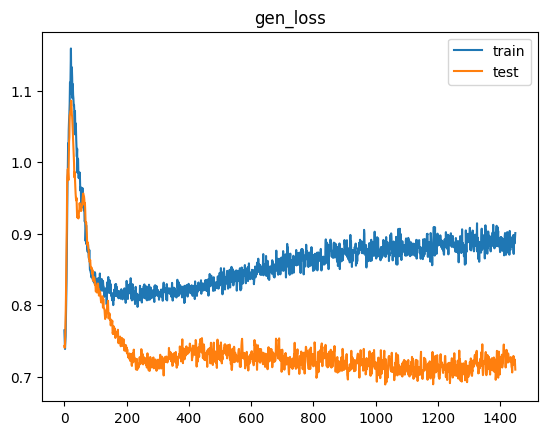

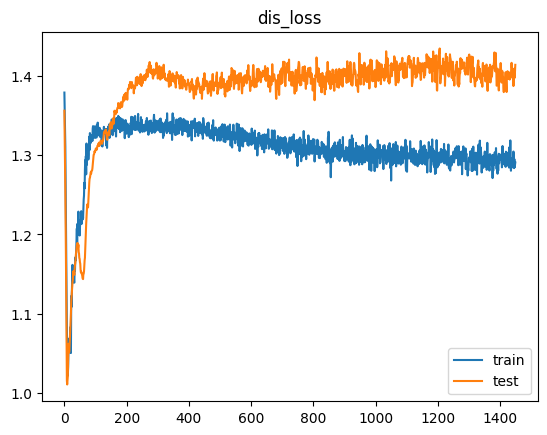

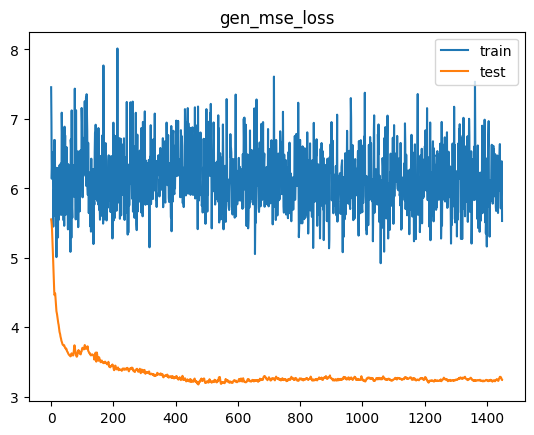

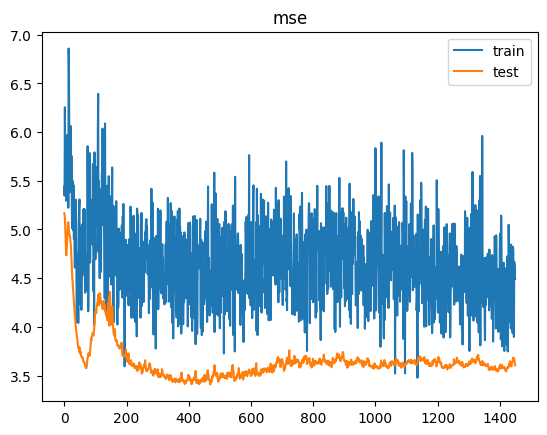

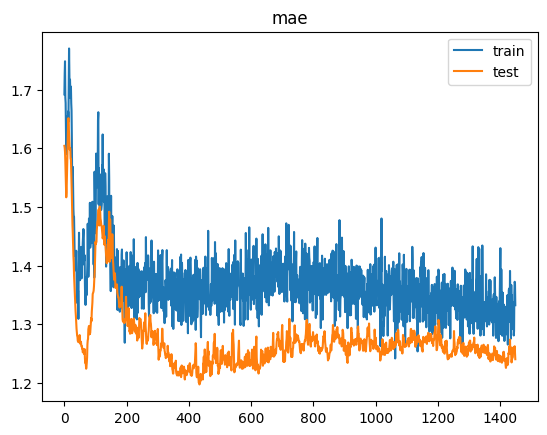

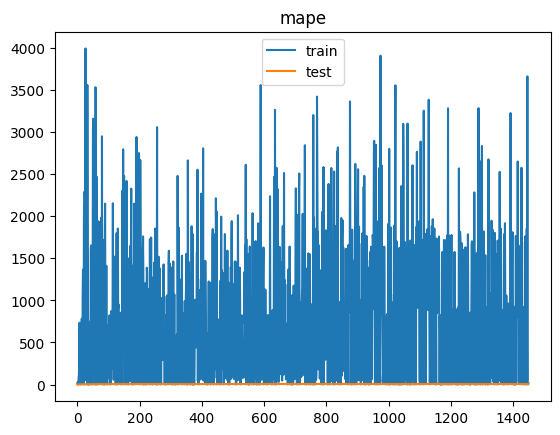

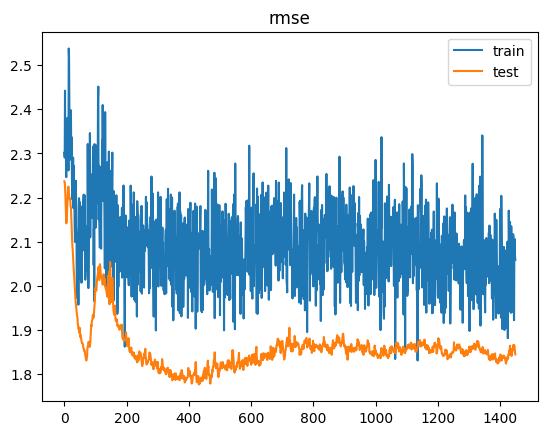

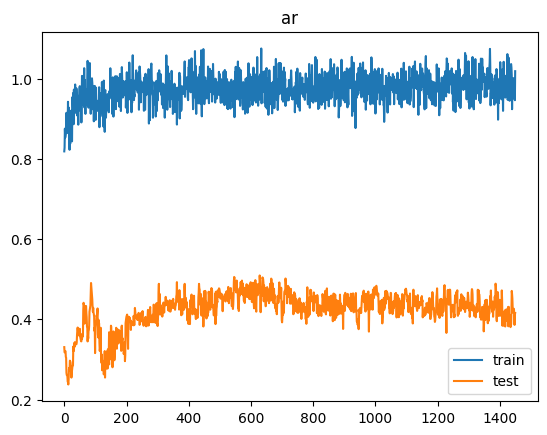

2/2 [==============================] - 1s 3ms/step


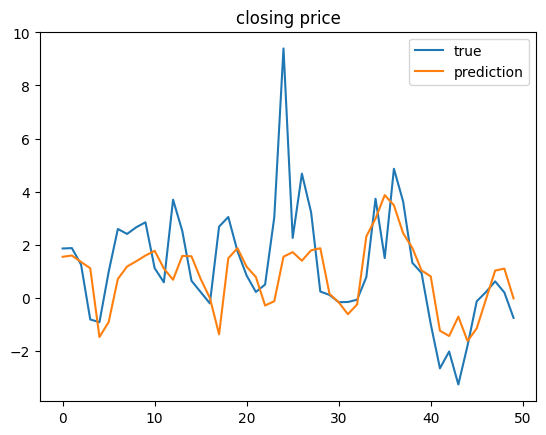

[MSE Baseline] train: 4.581365796614588  test: 3.665913330963867
Delta time with epochs = 1450: 0:13:02.531393
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 5, 7)]       0           []                               
                                                                                                  
 bidirectional_12 (Bidirectiona  (None, 5, 20)       1440        ['input_7[0][0]']                
 l)                                                                                               
                                                                                                  
 concatenate_6 (Concatenate)    (None, 5, 27)        0           ['bidirectional_12[0][0]',       
                                                                  'input_7[0][0]

Time for epoch 46 is 0.5571215152740479 sec Generator Loss: 0.9009382724761963,  Discriminator_loss: 1.2649184465408325
Time for epoch 47 is 0.5642414093017578 sec Generator Loss: 0.893733024597168,  Discriminator_loss: 1.2592039108276367
Time for epoch 48 is 0.5496053695678711 sec Generator Loss: 0.8939494490623474,  Discriminator_loss: 1.259751319885254
Time for epoch 49 is 0.5662240982055664 sec Generator Loss: 0.8808153867721558,  Discriminator_loss: 1.2664754390716553
Time for epoch 50 is 0.48978137969970703 sec Generator Loss: 0.8719823360443115,  Discriminator_loss: 1.3027037382125854
Time for epoch 51 is 0.49711060523986816 sec Generator Loss: 0.890245258808136,  Discriminator_loss: 1.274337649345398
Time for epoch 52 is 0.4890108108520508 sec Generator Loss: 0.8685141205787659,  Discriminator_loss: 1.296930193901062
Time for epoch 53 is 0.4847679138183594 sec Generator Loss: 0.8701184988021851,  Discriminator_loss: 1.2816873788833618
Time for epoch 54 is 0.48753905296325684 se

Time for epoch 115 is 0.5506982803344727 sec Generator Loss: 0.8128764033317566,  Discriminator_loss: 1.3448612689971924
Time for epoch 116 is 0.5257265567779541 sec Generator Loss: 0.8217698931694031,  Discriminator_loss: 1.3345376253128052
Time for epoch 117 is 0.5156607627868652 sec Generator Loss: 0.8193744421005249,  Discriminator_loss: 1.3398123979568481
Time for epoch 118 is 0.48935389518737793 sec Generator Loss: 0.8188695907592773,  Discriminator_loss: 1.334641695022583
Time for epoch 119 is 0.4882814884185791 sec Generator Loss: 0.8214240074157715,  Discriminator_loss: 1.335691213607788
Time for epoch 120 is 0.4988532066345215 sec Generator Loss: 0.8094786405563354,  Discriminator_loss: 1.346011757850647
Time for epoch 121 is 0.4941599369049072 sec Generator Loss: 0.827586829662323,  Discriminator_loss: 1.3361766338348389
Time for epoch 122 is 0.49008679389953613 sec Generator Loss: 0.8124938011169434,  Discriminator_loss: 1.3410840034484863
Time for epoch 123 is 0.5189712047

Time for epoch 183 is 0.5160644054412842 sec Generator Loss: 0.8171374201774597,  Discriminator_loss: 1.335159182548523
Time for epoch 184 is 0.5184850692749023 sec Generator Loss: 0.8166497349739075,  Discriminator_loss: 1.3160518407821655
Time for epoch 185 is 0.5127463340759277 sec Generator Loss: 0.826181173324585,  Discriminator_loss: 1.324899673461914
Time for epoch 186 is 0.5070135593414307 sec Generator Loss: 0.8235291838645935,  Discriminator_loss: 1.3358128070831299
Time for epoch 187 is 0.5160789489746094 sec Generator Loss: 0.8298391699790955,  Discriminator_loss: 1.325758695602417
Time for epoch 188 is 0.5078213214874268 sec Generator Loss: 0.8332353830337524,  Discriminator_loss: 1.3318274021148682
Time for epoch 189 is 0.5132529735565186 sec Generator Loss: 0.8268893361091614,  Discriminator_loss: 1.3260889053344727
Time for epoch 190 is 0.5124671459197998 sec Generator Loss: 0.8182400465011597,  Discriminator_loss: 1.3443527221679688
Time for epoch 191 is 0.510388612747

Time for epoch 251 is 0.532052755355835 sec Generator Loss: 0.8098365068435669,  Discriminator_loss: 1.3387478590011597
Time for epoch 252 is 0.5492978096008301 sec Generator Loss: 0.8248910903930664,  Discriminator_loss: 1.3263248205184937
Time for epoch 253 is 0.5570709705352783 sec Generator Loss: 0.830068051815033,  Discriminator_loss: 1.3353369235992432
Time for epoch 254 is 0.5423526763916016 sec Generator Loss: 0.8285738825798035,  Discriminator_loss: 1.3408864736557007
Time for epoch 255 is 0.5273559093475342 sec Generator Loss: 0.8148884773254395,  Discriminator_loss: 1.335682988166809
Time for epoch 256 is 0.532228946685791 sec Generator Loss: 0.8288642764091492,  Discriminator_loss: 1.3361026048660278
Time for epoch 257 is 0.5569169521331787 sec Generator Loss: 0.8317409753799438,  Discriminator_loss: 1.3246684074401855
Time for epoch 258 is 0.5488040447235107 sec Generator Loss: 0.8095026016235352,  Discriminator_loss: 1.3334081172943115
Time for epoch 259 is 0.520578861236

Time for epoch 319 is 0.61918044090271 sec Generator Loss: 0.8146273493766785,  Discriminator_loss: 1.32962167263031
Time for epoch 320 is 0.5956220626831055 sec Generator Loss: 0.8217096924781799,  Discriminator_loss: 1.3373606204986572
Time for epoch 321 is 0.571221113204956 sec Generator Loss: 0.8259655237197876,  Discriminator_loss: 1.3317811489105225
Time for epoch 322 is 0.5722270011901855 sec Generator Loss: 0.8155359029769897,  Discriminator_loss: 1.342262625694275
Time for epoch 323 is 0.5771381855010986 sec Generator Loss: 0.811835527420044,  Discriminator_loss: 1.346842646598816
Time for epoch 324 is 0.5795145034790039 sec Generator Loss: 0.8175351619720459,  Discriminator_loss: 1.3390196561813354
Time for epoch 325 is 0.5281929969787598 sec Generator Loss: 0.8145110011100769,  Discriminator_loss: 1.3456939458847046
Time for epoch 326 is 0.5308518409729004 sec Generator Loss: 0.8178842663764954,  Discriminator_loss: 1.329315423965454
Time for epoch 327 is 0.5450809001922607 

Time for epoch 388 is 0.5411233901977539 sec Generator Loss: 0.8311536908149719,  Discriminator_loss: 1.3149913549423218
Time for epoch 389 is 0.5314116477966309 sec Generator Loss: 0.8181928396224976,  Discriminator_loss: 1.336029052734375
Time for epoch 390 is 0.5259380340576172 sec Generator Loss: 0.8227135539054871,  Discriminator_loss: 1.332083821296692
Time for epoch 391 is 0.5653212070465088 sec Generator Loss: 0.805661141872406,  Discriminator_loss: 1.3497979640960693
Time for epoch 392 is 0.5415050983428955 sec Generator Loss: 0.813339114189148,  Discriminator_loss: 1.3394458293914795
Time for epoch 393 is 0.5585100650787354 sec Generator Loss: 0.8209181427955627,  Discriminator_loss: 1.3348166942596436
Time for epoch 394 is 0.5380566120147705 sec Generator Loss: 0.8190498352050781,  Discriminator_loss: 1.3388246297836304
Time for epoch 395 is 0.539963960647583 sec Generator Loss: 0.8237038850784302,  Discriminator_loss: 1.3321040868759155
Time for epoch 396 is 0.5595741271972

Time for epoch 456 is 0.541785478591919 sec Generator Loss: 0.8382235765457153,  Discriminator_loss: 1.3224635124206543
Time for epoch 457 is 0.5371255874633789 sec Generator Loss: 0.8189401030540466,  Discriminator_loss: 1.3387242555618286
Time for epoch 458 is 0.551912784576416 sec Generator Loss: 0.8260924220085144,  Discriminator_loss: 1.3202486038208008
Time for epoch 459 is 0.5490806102752686 sec Generator Loss: 0.8219854831695557,  Discriminator_loss: 1.3232134580612183
Time for epoch 460 is 0.5406112670898438 sec Generator Loss: 0.8226556181907654,  Discriminator_loss: 1.3298029899597168
Time for epoch 461 is 0.5280203819274902 sec Generator Loss: 0.8317380547523499,  Discriminator_loss: 1.3317193984985352
Time for epoch 462 is 0.5674839019775391 sec Generator Loss: 0.831717848777771,  Discriminator_loss: 1.3273895978927612
Time for epoch 463 is 0.5203382968902588 sec Generator Loss: 0.8226049542427063,  Discriminator_loss: 1.3316035270690918
Time for epoch 464 is 0.50380706787

Time for epoch 524 is 0.5434482097625732 sec Generator Loss: 0.8272965550422668,  Discriminator_loss: 1.327932596206665
Time for epoch 525 is 0.5446677207946777 sec Generator Loss: 0.8329423666000366,  Discriminator_loss: 1.3185226917266846
Time for epoch 526 is 0.5314042568206787 sec Generator Loss: 0.8206837177276611,  Discriminator_loss: 1.3278179168701172
Time for epoch 527 is 0.5339944362640381 sec Generator Loss: 0.8227997422218323,  Discriminator_loss: 1.3319979906082153
Time for epoch 528 is 0.5638754367828369 sec Generator Loss: 0.8251577019691467,  Discriminator_loss: 1.3302364349365234
Time for epoch 529 is 0.5381011962890625 sec Generator Loss: 0.8133130073547363,  Discriminator_loss: 1.334964394569397
Time for epoch 530 is 0.5467336177825928 sec Generator Loss: 0.8289739489555359,  Discriminator_loss: 1.3275551795959473
Time for epoch 531 is 0.5719177722930908 sec Generator Loss: 0.8212338089942932,  Discriminator_loss: 1.3365267515182495
Time for epoch 532 is 0.5626325607

Time for epoch 592 is 0.5054526329040527 sec Generator Loss: 0.8304329514503479,  Discriminator_loss: 1.3198437690734863
Time for epoch 593 is 0.5032444000244141 sec Generator Loss: 0.8329887986183167,  Discriminator_loss: 1.3269802331924438
Time for epoch 594 is 0.506493330001831 sec Generator Loss: 0.8431113362312317,  Discriminator_loss: 1.3197801113128662
Time for epoch 595 is 0.5052027702331543 sec Generator Loss: 0.827625572681427,  Discriminator_loss: 1.3322354555130005
Time for epoch 596 is 0.5069653987884521 sec Generator Loss: 0.8416031002998352,  Discriminator_loss: 1.317233681678772
Time for epoch 597 is 0.5061309337615967 sec Generator Loss: 0.8473737835884094,  Discriminator_loss: 1.3237329721450806
Time for epoch 598 is 0.504749059677124 sec Generator Loss: 0.8449303507804871,  Discriminator_loss: 1.3201007843017578
Time for epoch 599 is 0.4993174076080322 sec Generator Loss: 0.8346287608146667,  Discriminator_loss: 1.3306903839111328
Time for epoch 600 is 0.507086515426

Time for epoch 661 is 0.5452148914337158 sec Generator Loss: 0.843783974647522,  Discriminator_loss: 1.3157283067703247
Time for epoch 662 is 0.5561342239379883 sec Generator Loss: 0.8417696356773376,  Discriminator_loss: 1.322557806968689
Time for epoch 663 is 0.5505719184875488 sec Generator Loss: 0.8587160110473633,  Discriminator_loss: 1.311942219734192
Time for epoch 664 is 0.5247714519500732 sec Generator Loss: 0.8455634117126465,  Discriminator_loss: 1.3221384286880493
Time for epoch 665 is 0.558647632598877 sec Generator Loss: 0.8467264771461487,  Discriminator_loss: 1.3234187364578247
Time for epoch 666 is 0.5541789531707764 sec Generator Loss: 0.8342797756195068,  Discriminator_loss: 1.31498384475708
Time for epoch 667 is 0.544912576675415 sec Generator Loss: 0.8588948249816895,  Discriminator_loss: 1.3134104013442993
Time for epoch 668 is 0.560650110244751 sec Generator Loss: 0.862066388130188,  Discriminator_loss: 1.320853352546692
Time for epoch 669 is 0.5406017303466797 s

Time for epoch 729 is 0.508136510848999 sec Generator Loss: 0.8515353202819824,  Discriminator_loss: 1.3200808763504028
Time for epoch 730 is 0.5377705097198486 sec Generator Loss: 0.8457708358764648,  Discriminator_loss: 1.3097087144851685
Time for epoch 731 is 0.564873218536377 sec Generator Loss: 0.8459516167640686,  Discriminator_loss: 1.312953233718872
Time for epoch 732 is 0.5396113395690918 sec Generator Loss: 0.8477975130081177,  Discriminator_loss: 1.3188178539276123
Time for epoch 733 is 0.5544788837432861 sec Generator Loss: 0.8464758396148682,  Discriminator_loss: 1.320171594619751
Time for epoch 734 is 0.5372467041015625 sec Generator Loss: 0.8530830144882202,  Discriminator_loss: 1.3181507587432861
Time for epoch 735 is 0.5832419395446777 sec Generator Loss: 0.8311510682106018,  Discriminator_loss: 1.3336615562438965
Time for epoch 736 is 0.5320978164672852 sec Generator Loss: 0.853904664516449,  Discriminator_loss: 1.316019892692566
Time for epoch 737 is 0.55982851982116

Time for epoch 797 is 0.5344128608703613 sec Generator Loss: 0.8499475717544556,  Discriminator_loss: 1.3234796524047852
Time for epoch 798 is 0.5597095489501953 sec Generator Loss: 0.8374254703521729,  Discriminator_loss: 1.3255906105041504
Time for epoch 799 is 0.5454702377319336 sec Generator Loss: 0.8532418608665466,  Discriminator_loss: 1.3245760202407837
Time for epoch 800 is 0.5523805618286133 sec Generator Loss: 0.8521740436553955,  Discriminator_loss: 1.310301661491394
Time for epoch 801 is 0.5504400730133057 sec Generator Loss: 0.8550482988357544,  Discriminator_loss: 1.3077001571655273
Time for epoch 802 is 0.5473551750183105 sec Generator Loss: 0.8597680330276489,  Discriminator_loss: 1.3046586513519287
Time for epoch 803 is 0.558161735534668 sec Generator Loss: 0.8456539511680603,  Discriminator_loss: 1.3240505456924438
Time for epoch 804 is 0.556603193283081 sec Generator Loss: 0.8520359396934509,  Discriminator_loss: 1.323158621788025
Time for epoch 805 is 0.565298557281

Time for epoch 865 is 0.5633516311645508 sec Generator Loss: 0.8387712836265564,  Discriminator_loss: 1.3276448249816895
Time for epoch 866 is 0.5500843524932861 sec Generator Loss: 0.8645886778831482,  Discriminator_loss: 1.3061974048614502
Time for epoch 867 is 0.5608391761779785 sec Generator Loss: 0.8641390204429626,  Discriminator_loss: 1.3171508312225342
Time for epoch 868 is 0.5456886291503906 sec Generator Loss: 0.851176917552948,  Discriminator_loss: 1.3053691387176514
Time for epoch 869 is 0.5483472347259521 sec Generator Loss: 0.8580779433250427,  Discriminator_loss: 1.3080271482467651
Time for epoch 870 is 0.5613656044006348 sec Generator Loss: 0.8434959053993225,  Discriminator_loss: 1.3188844919204712
Time for epoch 871 is 0.6386830806732178 sec Generator Loss: 0.8543353080749512,  Discriminator_loss: 1.3203033208847046
Time for epoch 872 is 0.5985350608825684 sec Generator Loss: 0.8630563616752625,  Discriminator_loss: 1.3101097345352173
Time for epoch 873 is 0.574147224

Time for epoch 933 is 0.5702767372131348 sec Generator Loss: 0.8621348142623901,  Discriminator_loss: 1.299300193786621
Time for epoch 934 is 0.5869824886322021 sec Generator Loss: 0.8689742088317871,  Discriminator_loss: 1.3100372552871704
Time for epoch 935 is 0.5565099716186523 sec Generator Loss: 0.8556154370307922,  Discriminator_loss: 1.3124631643295288
Time for epoch 936 is 0.5516440868377686 sec Generator Loss: 0.855819821357727,  Discriminator_loss: 1.309584379196167
Time for epoch 937 is 0.5776565074920654 sec Generator Loss: 0.8710241913795471,  Discriminator_loss: 1.300016164779663
Time for epoch 938 is 0.5407350063323975 sec Generator Loss: 0.8598325848579407,  Discriminator_loss: 1.3097819089889526
Time for epoch 939 is 0.5467743873596191 sec Generator Loss: 0.8665516972541809,  Discriminator_loss: 1.3129053115844727
Time for epoch 940 is 0.5249712467193604 sec Generator Loss: 0.8763116002082825,  Discriminator_loss: 1.3007620573043823
Time for epoch 941 is 0.545462608337

Time for epoch 1001 is 0.5641999244689941 sec Generator Loss: 0.8428772687911987,  Discriminator_loss: 1.3262170553207397
Time for epoch 1002 is 0.5658519268035889 sec Generator Loss: 0.8504243493080139,  Discriminator_loss: 1.3070026636123657
Time for epoch 1003 is 0.5882861614227295 sec Generator Loss: 0.8544251322746277,  Discriminator_loss: 1.3289003372192383
Time for epoch 1004 is 0.5668759346008301 sec Generator Loss: 0.8714514374732971,  Discriminator_loss: 1.2989232540130615
Time for epoch 1005 is 0.5711162090301514 sec Generator Loss: 0.8555333018302917,  Discriminator_loss: 1.3184999227523804
Time for epoch 1006 is 0.5728116035461426 sec Generator Loss: 0.8554399013519287,  Discriminator_loss: 1.3072792291641235
Time for epoch 1007 is 0.5392863750457764 sec Generator Loss: 0.8647909164428711,  Discriminator_loss: 1.3090876340866089
Time for epoch 1008 is 0.5675256252288818 sec Generator Loss: 0.864879310131073,  Discriminator_loss: 1.3126368522644043
Time for epoch 1009 is 0.

Time for epoch 1069 is 0.541675329208374 sec Generator Loss: 0.866599977016449,  Discriminator_loss: 1.30830717086792
Time for epoch 1070 is 0.5565292835235596 sec Generator Loss: 0.8540482521057129,  Discriminator_loss: 1.3110544681549072
Time for epoch 1071 is 0.5887472629547119 sec Generator Loss: 0.8727959394454956,  Discriminator_loss: 1.2958601713180542
Time for epoch 1072 is 0.6285855770111084 sec Generator Loss: 0.8675484657287598,  Discriminator_loss: 1.3065807819366455
Time for epoch 1073 is 0.536595344543457 sec Generator Loss: 0.8805522918701172,  Discriminator_loss: 1.2961184978485107
Time for epoch 1074 is 0.5651934146881104 sec Generator Loss: 0.8738715648651123,  Discriminator_loss: 1.3001185655593872
Time for epoch 1075 is 0.5436017513275146 sec Generator Loss: 0.8718175888061523,  Discriminator_loss: 1.3094569444656372
Time for epoch 1076 is 0.5582411289215088 sec Generator Loss: 0.8638008832931519,  Discriminator_loss: 1.3095238208770752
Time for epoch 1077 is 0.5281

Time for epoch 1137 is 0.5502123832702637 sec Generator Loss: 0.8647786974906921,  Discriminator_loss: 1.3089663982391357
Time for epoch 1138 is 0.5963752269744873 sec Generator Loss: 0.8970566391944885,  Discriminator_loss: 1.2919446229934692
Time for epoch 1139 is 0.550694465637207 sec Generator Loss: 0.8639692664146423,  Discriminator_loss: 1.3133052587509155
Time for epoch 1140 is 0.5336484909057617 sec Generator Loss: 0.864495575428009,  Discriminator_loss: 1.3048863410949707
Time for epoch 1141 is 0.5431628227233887 sec Generator Loss: 0.8801910281181335,  Discriminator_loss: 1.298222303390503
Time for epoch 1142 is 0.5750279426574707 sec Generator Loss: 0.8733154535293579,  Discriminator_loss: 1.3067376613616943
Time for epoch 1143 is 0.5568597316741943 sec Generator Loss: 0.864210844039917,  Discriminator_loss: 1.3139426708221436
Time for epoch 1144 is 0.564810037612915 sec Generator Loss: 0.8560811877250671,  Discriminator_loss: 1.3237512111663818
Time for epoch 1145 is 0.5434

Time for epoch 1205 is 0.5100662708282471 sec Generator Loss: 0.8627226948738098,  Discriminator_loss: 1.3006579875946045
Time for epoch 1206 is 0.5685961246490479 sec Generator Loss: 0.8606910109519958,  Discriminator_loss: 1.3208955526351929
Time for epoch 1207 is 0.5986266136169434 sec Generator Loss: 0.8495380282402039,  Discriminator_loss: 1.308483600616455
Time for epoch 1208 is 0.549454927444458 sec Generator Loss: 0.8761233687400818,  Discriminator_loss: 1.301526665687561
Time for epoch 1209 is 0.5593032836914062 sec Generator Loss: 0.8711990714073181,  Discriminator_loss: 1.3026217222213745
Time for epoch 1210 is 0.5631458759307861 sec Generator Loss: 0.8810082077980042,  Discriminator_loss: 1.3016897439956665
Time for epoch 1211 is 0.5759584903717041 sec Generator Loss: 0.8818687200546265,  Discriminator_loss: 1.3056529760360718
Time for epoch 1212 is 0.5701990127563477 sec Generator Loss: 0.8894583582878113,  Discriminator_loss: 1.2935363054275513
Time for epoch 1213 is 0.55

Time for epoch 1273 is 0.859943151473999 sec Generator Loss: 0.8597549796104431,  Discriminator_loss: 1.3137972354888916
Time for epoch 1274 is 0.7069134712219238 sec Generator Loss: 0.880034327507019,  Discriminator_loss: 1.29875910282135
Time for epoch 1275 is 0.6912355422973633 sec Generator Loss: 0.8594906330108643,  Discriminator_loss: 1.3162081241607666
Time for epoch 1276 is 0.6074080467224121 sec Generator Loss: 0.868034839630127,  Discriminator_loss: 1.2979413270950317
Time for epoch 1277 is 0.6579327583312988 sec Generator Loss: 0.8839530348777771,  Discriminator_loss: 1.3021564483642578
Time for epoch 1278 is 0.6553835868835449 sec Generator Loss: 0.8802878260612488,  Discriminator_loss: 1.2965810298919678
Time for epoch 1279 is 0.8403503894805908 sec Generator Loss: 0.8814244270324707,  Discriminator_loss: 1.3008553981781006
Time for epoch 1280 is 0.623272180557251 sec Generator Loss: 0.8811261653900146,  Discriminator_loss: 1.292321801185608
Time for epoch 1281 is 0.686032

Time for epoch 1341 is 0.5938694477081299 sec Generator Loss: 0.8900966048240662,  Discriminator_loss: 1.2976939678192139
Time for epoch 1342 is 0.6488230228424072 sec Generator Loss: 0.8665667772293091,  Discriminator_loss: 1.3053144216537476
Time for epoch 1343 is 0.65561842918396 sec Generator Loss: 0.8814849257469177,  Discriminator_loss: 1.3003625869750977
Time for epoch 1344 is 0.6765096187591553 sec Generator Loss: 0.864398717880249,  Discriminator_loss: 1.3144441843032837
Time for epoch 1345 is 0.626415491104126 sec Generator Loss: 0.8943658471107483,  Discriminator_loss: 1.2970749139785767
Time for epoch 1346 is 0.663238525390625 sec Generator Loss: 0.8701545596122742,  Discriminator_loss: 1.2994214296340942
Time for epoch 1347 is 0.5981419086456299 sec Generator Loss: 0.8746125102043152,  Discriminator_loss: 1.3035138845443726
Time for epoch 1348 is 0.6168971061706543 sec Generator Loss: 0.896087646484375,  Discriminator_loss: 1.2899086475372314
Time for epoch 1349 is 0.59659

Time for epoch 1409 is 0.5558552742004395 sec Generator Loss: 0.8897965550422668,  Discriminator_loss: 1.305439829826355
Time for epoch 1410 is 0.5648159980773926 sec Generator Loss: 0.8839912414550781,  Discriminator_loss: 1.2881224155426025
Time for epoch 1411 is 0.552415132522583 sec Generator Loss: 0.8880850672721863,  Discriminator_loss: 1.291930079460144
Time for epoch 1412 is 0.5509974956512451 sec Generator Loss: 0.8820139765739441,  Discriminator_loss: 1.3124914169311523
Time for epoch 1413 is 0.6014084815979004 sec Generator Loss: 0.869856059551239,  Discriminator_loss: 1.2982895374298096
Time for epoch 1414 is 0.554579496383667 sec Generator Loss: 0.8646173477172852,  Discriminator_loss: 1.3054863214492798
Time for epoch 1415 is 0.6169826984405518 sec Generator Loss: 0.8838788270950317,  Discriminator_loss: 1.3010997772216797
Time for epoch 1416 is 0.575310468673706 sec Generator Loss: 0.8861281275749207,  Discriminator_loss: 1.2897735834121704
Time for epoch 1417 is 0.57315

Time for epoch 1477 is 0.5857789516448975 sec Generator Loss: 0.8846412897109985,  Discriminator_loss: 1.2857964038848877
Time for epoch 1478 is 0.5699787139892578 sec Generator Loss: 0.8934629559516907,  Discriminator_loss: 1.2991262674331665
Time for epoch 1479 is 0.5391807556152344 sec Generator Loss: 0.905640184879303,  Discriminator_loss: 1.291994571685791
Time for epoch 1480 is 0.5493676662445068 sec Generator Loss: 0.8743403553962708,  Discriminator_loss: 1.3079625368118286
Time for epoch 1481 is 0.6129240989685059 sec Generator Loss: 0.8855249285697937,  Discriminator_loss: 1.3016917705535889
Time for epoch 1482 is 0.6019227504730225 sec Generator Loss: 0.8918176889419556,  Discriminator_loss: 1.2907588481903076
Time for epoch 1483 is 0.6375365257263184 sec Generator Loss: 0.8744135499000549,  Discriminator_loss: 1.3065205812454224
Time for epoch 1484 is 0.5735609531402588 sec Generator Loss: 0.8806580901145935,  Discriminator_loss: 1.2954884767532349
Time for epoch 1485 is 0.6

Time for epoch 1545 is 0.5912957191467285 sec Generator Loss: 0.8824948072433472,  Discriminator_loss: 1.3079785108566284
Time for epoch 1546 is 0.5396239757537842 sec Generator Loss: 0.8947160243988037,  Discriminator_loss: 1.295650601387024
Time for epoch 1547 is 0.5684909820556641 sec Generator Loss: 0.8916288018226624,  Discriminator_loss: 1.2977802753448486
Time for epoch 1548 is 0.5484683513641357 sec Generator Loss: 0.9119777083396912,  Discriminator_loss: 1.2795336246490479
Time for epoch 1549 is 0.5682642459869385 sec Generator Loss: 0.8848961591720581,  Discriminator_loss: 1.2990421056747437
Time for epoch 1550 is 0.5815191268920898 sec Generator Loss: 0.9012851715087891,  Discriminator_loss: 1.2846643924713135
Time for epoch 1551 is 0.5660154819488525 sec Generator Loss: 0.8848296403884888,  Discriminator_loss: 1.3015096187591553
Time for epoch 1552 is 0.5750911235809326 sec Generator Loss: 0.8930075764656067,  Discriminator_loss: 1.2962192296981812
Time for epoch 1553 is 0.

Time for epoch 1613 is 0.5530807971954346 sec Generator Loss: 0.8898254632949829,  Discriminator_loss: 1.2968339920043945
Time for epoch 1614 is 0.5584845542907715 sec Generator Loss: 0.879260241985321,  Discriminator_loss: 1.3017603158950806
Time for epoch 1615 is 0.5610454082489014 sec Generator Loss: 0.8831886649131775,  Discriminator_loss: 1.3067171573638916
Time for epoch 1616 is 0.5603561401367188 sec Generator Loss: 0.8994160294532776,  Discriminator_loss: 1.2869014739990234
Time for epoch 1617 is 0.5715136528015137 sec Generator Loss: 0.872590184211731,  Discriminator_loss: 1.3011029958724976
Time for epoch 1618 is 0.5621757507324219 sec Generator Loss: 0.8709321022033691,  Discriminator_loss: 1.2915103435516357
Time for epoch 1619 is 0.571019172668457 sec Generator Loss: 0.8910219669342041,  Discriminator_loss: 1.2945098876953125
Time for epoch 1620 is 0.5464789867401123 sec Generator Loss: 0.8826068043708801,  Discriminator_loss: 1.2918788194656372
Time for epoch 1621 is 0.56

Time for epoch 1681 is 0.5182814598083496 sec Generator Loss: 0.8983564376831055,  Discriminator_loss: 1.2815548181533813
Time for epoch 1682 is 0.6395907402038574 sec Generator Loss: 0.8936686515808105,  Discriminator_loss: 1.2870126962661743
Time for epoch 1683 is 0.5985264778137207 sec Generator Loss: 0.8744964003562927,  Discriminator_loss: 1.2979381084442139
Time for epoch 1684 is 0.5894820690155029 sec Generator Loss: 0.904503583908081,  Discriminator_loss: 1.2924355268478394
Time for epoch 1685 is 0.5570147037506104 sec Generator Loss: 0.8940742611885071,  Discriminator_loss: 1.2925292253494263
Time for epoch 1686 is 0.5487563610076904 sec Generator Loss: 0.8949524164199829,  Discriminator_loss: 1.2819015979766846
Time for epoch 1687 is 0.5580847263336182 sec Generator Loss: 0.8760752081871033,  Discriminator_loss: 1.29953932762146
Time for epoch 1688 is 0.6621110439300537 sec Generator Loss: 0.8765920996665955,  Discriminator_loss: 1.2881489992141724
Time for epoch 1689 is 0.61

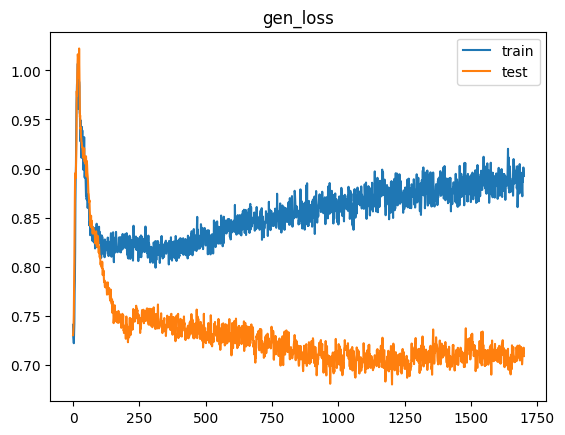

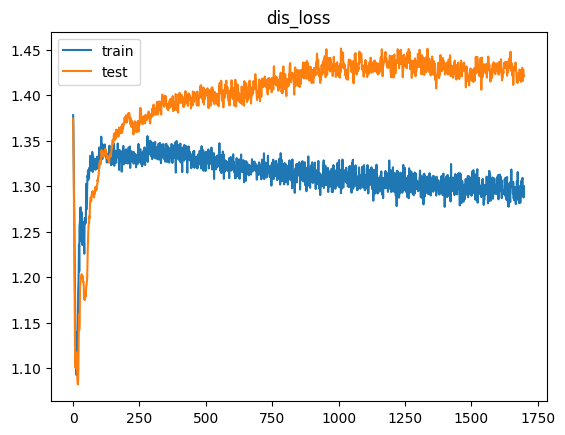

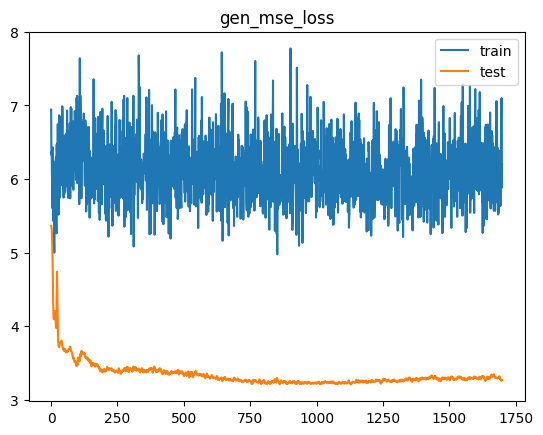

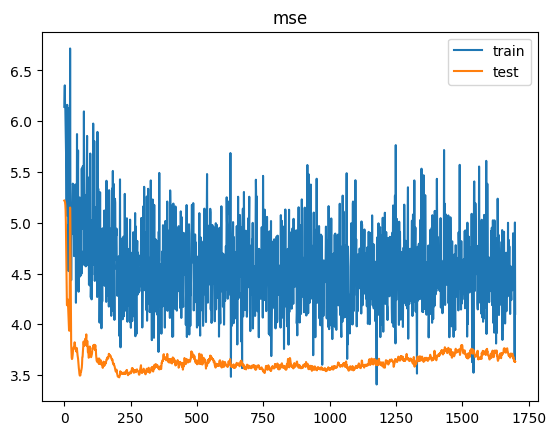

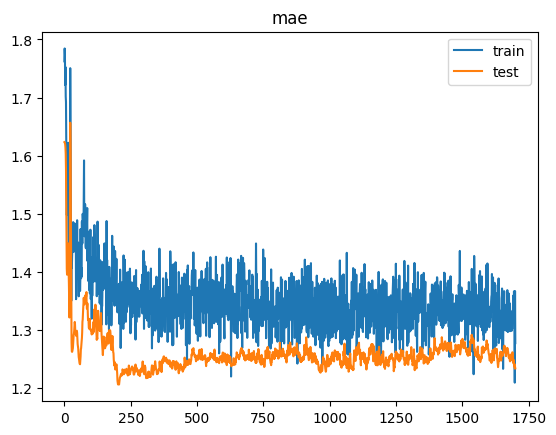

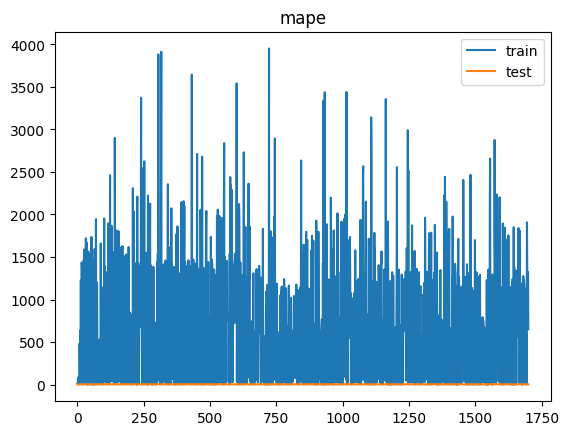

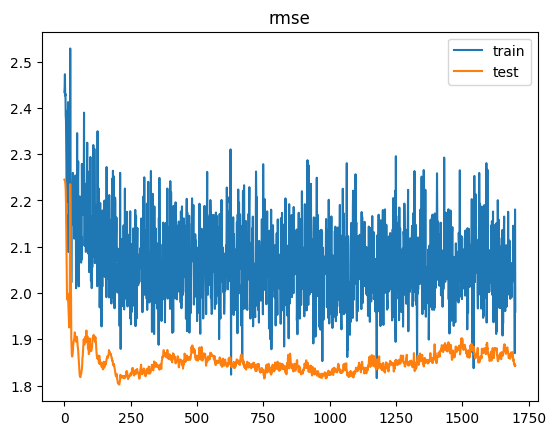

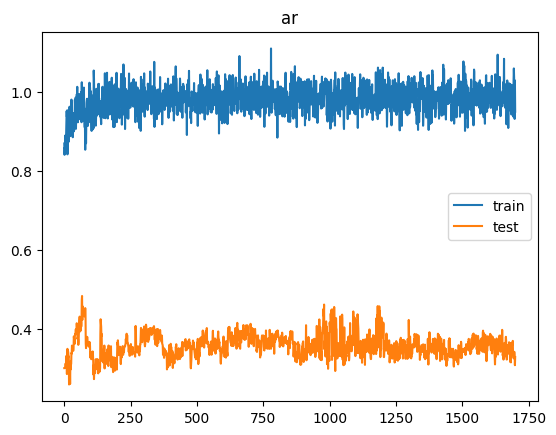

2/2 [==============================] - 1s 3ms/step


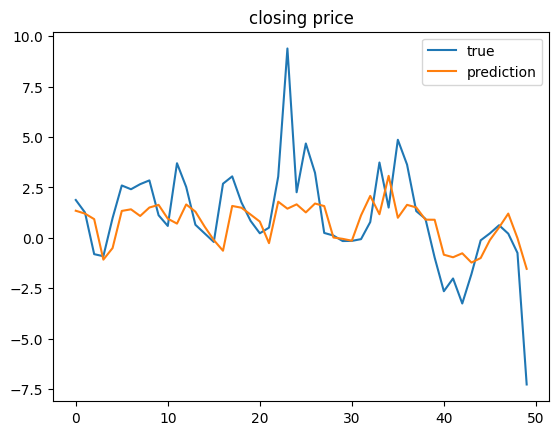

[MSE Baseline] train: 4.505990799249824  test: 3.634052838095099
Delta time with epochs = 1700: 0:16:15.388468


In [20]:
for epochs in [200, 450, 700, 950, 1200, 1450, 1700]:
    start_time = datetime.datetime.now()
    df = add_Ma(df)
    data_gen_train, data_gen_test = get_gen_train_test(df, n_sequence, n_batch)

    generator = make_generator_model(n_sequence, n_features)
    discriminator=make_discriminator_model(n_features)

    learning_rate=1e-4
    generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

    @tf.function
    def train_step(sequences, sequences_end):
      return train_step_def(sequences, sequences_end)

    @tf.function
    def test_step(sequences, sequences_end):
      return test_step_def(sequences, sequences_end)

    checkpoint_dir = './training_checkpoints'+stock_code
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                     discriminator_optimizer=discriminator_optimizer,
                                     generator=generator,
                                     discriminator=discriminator)

    history, history_val = train(data_gen_train, data_gen_test, epochs)

    plot_history(history, history_val)
    plot_frame(*data_gen_test[0], generator)

    print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))
    now = datetime.datetime.now()
    delta = now - start_time
    print("Delta time with epochs = {0}:".format(epochs), delta)
    generator.save("dcbilstm_ffnn_epochs_{0}.h5".format(epochs))

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 5, 7)]       0           []                               
                                                                                                  
 bidirectional_14 (Bidirectiona  (None, 5, 20)       1440        ['input_8[0][0]']                
 l)                                                                                               
                                                                                                  
 concatenate_7 (Concatenate)    (None, 5, 27)        0           ['bidirectional_14[0][0]',       
                                                                  'input_8[0][0]']                
                                                                                            

Time for epoch 47 is 0.5896556377410889 sec Generator Loss: 0.8953546285629272,  Discriminator_loss: 1.2559367418289185
Time for epoch 48 is 0.6295912265777588 sec Generator Loss: 0.8860698342323303,  Discriminator_loss: 1.2881782054901123
Time for epoch 49 is 0.5671348571777344 sec Generator Loss: 0.8878357410430908,  Discriminator_loss: 1.266780972480774
Time for epoch 50 is 0.5730810165405273 sec Generator Loss: 0.8807281851768494,  Discriminator_loss: 1.2770978212356567
Time for epoch 51 is 0.5456981658935547 sec Generator Loss: 0.8812094330787659,  Discriminator_loss: 1.2789767980575562
Time for epoch 52 is 0.5380215644836426 sec Generator Loss: 0.8758025169372559,  Discriminator_loss: 1.2688020467758179
Time for epoch 53 is 0.5492649078369141 sec Generator Loss: 0.8761580586433411,  Discriminator_loss: 1.2757573127746582
Time for epoch 54 is 0.5395822525024414 sec Generator Loss: 0.8623965978622437,  Discriminator_loss: 1.302510380744934
Time for epoch 55 is 0.5578796863555908 se

Time for epoch 116 is 0.5006756782531738 sec Generator Loss: 0.8018715381622314,  Discriminator_loss: 1.3496097326278687
Time for epoch 117 is 0.5484282970428467 sec Generator Loss: 0.8087544441223145,  Discriminator_loss: 1.356126070022583
Time for epoch 118 is 0.5337390899658203 sec Generator Loss: 0.8017136454582214,  Discriminator_loss: 1.352858543395996
Time for epoch 119 is 0.5293247699737549 sec Generator Loss: 0.8021893501281738,  Discriminator_loss: 1.3547701835632324
Time for epoch 120 is 0.5124866962432861 sec Generator Loss: 0.8049380779266357,  Discriminator_loss: 1.354343295097351
Time for epoch 121 is 0.5311863422393799 sec Generator Loss: 0.8049280643463135,  Discriminator_loss: 1.3512262105941772
Time for epoch 122 is 0.5262207984924316 sec Generator Loss: 0.8003239035606384,  Discriminator_loss: 1.3520257472991943
Time for epoch 123 is 0.5333878993988037 sec Generator Loss: 0.7907026410102844,  Discriminator_loss: 1.3683511018753052
Time for epoch 124 is 0.54629015922

Time for epoch 184 is 0.5329663753509521 sec Generator Loss: 0.807775616645813,  Discriminator_loss: 1.3383225202560425
Time for epoch 185 is 0.5728421211242676 sec Generator Loss: 0.8107479810714722,  Discriminator_loss: 1.3460723161697388
Time for epoch 186 is 0.596649169921875 sec Generator Loss: 0.8037558197975159,  Discriminator_loss: 1.3455005884170532
Time for epoch 187 is 0.541386604309082 sec Generator Loss: 0.8028120398521423,  Discriminator_loss: 1.3437409400939941
Time for epoch 188 is 0.6237330436706543 sec Generator Loss: 0.8009116649627686,  Discriminator_loss: 1.354784607887268
Time for epoch 189 is 0.5790972709655762 sec Generator Loss: 0.799375057220459,  Discriminator_loss: 1.3489257097244263
Time for epoch 190 is 0.5571074485778809 sec Generator Loss: 0.8028436899185181,  Discriminator_loss: 1.340685486793518
Time for epoch 191 is 0.5610592365264893 sec Generator Loss: 0.7963218092918396,  Discriminator_loss: 1.3479304313659668
Time for epoch 192 is 0.57399940490722

Time for epoch 253 is 0.5906116962432861 sec Generator Loss: 0.802129328250885,  Discriminator_loss: 1.3410582542419434
Time for epoch 254 is 0.5857763290405273 sec Generator Loss: 0.8071660399436951,  Discriminator_loss: 1.3374875783920288
Time for epoch 255 is 0.5901858806610107 sec Generator Loss: 0.8230100870132446,  Discriminator_loss: 1.3328272104263306
Time for epoch 256 is 0.5471885204315186 sec Generator Loss: 0.8144267797470093,  Discriminator_loss: 1.3353182077407837
Time for epoch 257 is 0.5564591884613037 sec Generator Loss: 0.8055649995803833,  Discriminator_loss: 1.3478692770004272
Time for epoch 258 is 0.5776751041412354 sec Generator Loss: 0.8046597838401794,  Discriminator_loss: 1.3512284755706787
Time for epoch 259 is 0.5593152046203613 sec Generator Loss: 0.8144119381904602,  Discriminator_loss: 1.3370277881622314
Time for epoch 260 is 0.5369997024536133 sec Generator Loss: 0.8052890300750732,  Discriminator_loss: 1.3386225700378418
Time for epoch 261 is 0.587145090

Time for epoch 321 is 0.5803172588348389 sec Generator Loss: 0.802931547164917,  Discriminator_loss: 1.3436203002929688
Time for epoch 322 is 0.6622674465179443 sec Generator Loss: 0.7873455286026001,  Discriminator_loss: 1.3470104932785034
Time for epoch 323 is 0.6185281276702881 sec Generator Loss: 0.8032686114311218,  Discriminator_loss: 1.343254804611206
Time for epoch 324 is 0.6472039222717285 sec Generator Loss: 0.7980155348777771,  Discriminator_loss: 1.3446489572525024
Time for epoch 325 is 0.6585214138031006 sec Generator Loss: 0.8036035895347595,  Discriminator_loss: 1.337351679801941
Time for epoch 326 is 0.6351401805877686 sec Generator Loss: 0.8022220134735107,  Discriminator_loss: 1.3484876155853271
Time for epoch 327 is 0.5580976009368896 sec Generator Loss: 0.806179940700531,  Discriminator_loss: 1.3347547054290771
Time for epoch 328 is 0.5678410530090332 sec Generator Loss: 0.8061944246292114,  Discriminator_loss: 1.349977731704712
Time for epoch 329 is 0.5553646087646

Time for epoch 390 is 0.5871014595031738 sec Generator Loss: 0.7980040311813354,  Discriminator_loss: 1.343536138534546
Time for epoch 391 is 0.5943090915679932 sec Generator Loss: 0.7995573282241821,  Discriminator_loss: 1.3462110757827759
Time for epoch 392 is 0.5992946624755859 sec Generator Loss: 0.7927706241607666,  Discriminator_loss: 1.3503938913345337
Time for epoch 393 is 0.6554734706878662 sec Generator Loss: 0.7912721633911133,  Discriminator_loss: 1.3505353927612305
Time for epoch 394 is 0.5567505359649658 sec Generator Loss: 0.8010956645011902,  Discriminator_loss: 1.346346139907837
Time for epoch 395 is 0.5765893459320068 sec Generator Loss: 0.8044410943984985,  Discriminator_loss: 1.3380335569381714
Time for epoch 396 is 0.5571200847625732 sec Generator Loss: 0.80912846326828,  Discriminator_loss: 1.3385332822799683
Time for epoch 397 is 0.555088996887207 sec Generator Loss: 0.8053504824638367,  Discriminator_loss: 1.3488681316375732
Time for epoch 398 is 0.5510518550872

Time for epoch 458 is 0.5769374370574951 sec Generator Loss: 0.8165577054023743,  Discriminator_loss: 1.341607689857483
Time for epoch 459 is 0.573235273361206 sec Generator Loss: 0.8097504377365112,  Discriminator_loss: 1.3416250944137573
Time for epoch 460 is 0.5865683555603027 sec Generator Loss: 0.8234740495681763,  Discriminator_loss: 1.3358194828033447
Time for epoch 461 is 0.5590591430664062 sec Generator Loss: 0.8154239654541016,  Discriminator_loss: 1.3325908184051514
Time for epoch 462 is 0.5809671878814697 sec Generator Loss: 0.811870813369751,  Discriminator_loss: 1.3323615789413452
Time for epoch 463 is 0.5384316444396973 sec Generator Loss: 0.8066580891609192,  Discriminator_loss: 1.3326724767684937
Time for epoch 464 is 0.5491113662719727 sec Generator Loss: 0.8023492693901062,  Discriminator_loss: 1.347503662109375
Time for epoch 465 is 0.6095020771026611 sec Generator Loss: 0.8050991892814636,  Discriminator_loss: 1.3399680852890015
Time for epoch 466 is 0.546563148498

Time for epoch 526 is 0.5638797283172607 sec Generator Loss: 0.8214481472969055,  Discriminator_loss: 1.3282885551452637
Time for epoch 527 is 0.5661232471466064 sec Generator Loss: 0.8165686726570129,  Discriminator_loss: 1.322371244430542
Time for epoch 528 is 0.5467407703399658 sec Generator Loss: 0.8295531272888184,  Discriminator_loss: 1.315870761871338
Time for epoch 529 is 0.6117184162139893 sec Generator Loss: 0.8192023634910583,  Discriminator_loss: 1.3320478200912476
Time for epoch 530 is 0.5959088802337646 sec Generator Loss: 0.8297968506813049,  Discriminator_loss: 1.3251442909240723
Time for epoch 531 is 0.5883762836456299 sec Generator Loss: 0.8299497365951538,  Discriminator_loss: 1.3165944814682007
Time for epoch 532 is 0.5560324192047119 sec Generator Loss: 0.8287941217422485,  Discriminator_loss: 1.3284131288528442
Time for epoch 533 is 0.5686554908752441 sec Generator Loss: 0.8242948651313782,  Discriminator_loss: 1.3311858177185059
Time for epoch 534 is 0.5694453716

Time for epoch 595 is 0.5522246360778809 sec Generator Loss: 0.8313665986061096,  Discriminator_loss: 1.3204959630966187
Time for epoch 596 is 0.5569984912872314 sec Generator Loss: 0.8278174996376038,  Discriminator_loss: 1.3267234563827515
Time for epoch 597 is 0.5534324645996094 sec Generator Loss: 0.8173373937606812,  Discriminator_loss: 1.3317216634750366
Time for epoch 598 is 0.5609219074249268 sec Generator Loss: 0.8318371176719666,  Discriminator_loss: 1.3246670961380005
Time for epoch 599 is 0.5409517288208008 sec Generator Loss: 0.823452889919281,  Discriminator_loss: 1.3294283151626587
Time for epoch 600 is 0.5810647010803223 sec Generator Loss: 0.8322091102600098,  Discriminator_loss: 1.3195730447769165
Time for epoch 601 is 0.6004061698913574 sec Generator Loss: 0.8322468400001526,  Discriminator_loss: 1.3179292678833008
Time for epoch 602 is 0.5780205726623535 sec Generator Loss: 0.8265848159790039,  Discriminator_loss: 1.3362728357315063
Time for epoch 603 is 0.575972318

Time for epoch 663 is 0.5963175296783447 sec Generator Loss: 0.8420940637588501,  Discriminator_loss: 1.3230839967727661
Time for epoch 664 is 0.5591192245483398 sec Generator Loss: 0.820133626461029,  Discriminator_loss: 1.3273608684539795
Time for epoch 665 is 0.5553703308105469 sec Generator Loss: 0.8360118269920349,  Discriminator_loss: 1.3085131645202637
Time for epoch 666 is 0.5487167835235596 sec Generator Loss: 0.8411024212837219,  Discriminator_loss: 1.3228206634521484
Time for epoch 667 is 0.6259355545043945 sec Generator Loss: 0.8365755081176758,  Discriminator_loss: 1.320593237876892
Time for epoch 668 is 0.5893092155456543 sec Generator Loss: 0.8395792841911316,  Discriminator_loss: 1.3282413482666016
Time for epoch 669 is 0.5752089023590088 sec Generator Loss: 0.8425289988517761,  Discriminator_loss: 1.318599820137024
Time for epoch 670 is 0.5942132472991943 sec Generator Loss: 0.8457506895065308,  Discriminator_loss: 1.3151196241378784
Time for epoch 671 is 0.60576128959

Time for epoch 731 is 0.5508348941802979 sec Generator Loss: 0.8506466150283813,  Discriminator_loss: 1.3126527070999146
Time for epoch 732 is 0.5534048080444336 sec Generator Loss: 0.8435502052307129,  Discriminator_loss: 1.322456955909729
Time for epoch 733 is 0.5685102939605713 sec Generator Loss: 0.8523387312889099,  Discriminator_loss: 1.3127132654190063
Time for epoch 734 is 0.5468485355377197 sec Generator Loss: 0.843157172203064,  Discriminator_loss: 1.3126055002212524
Time for epoch 735 is 0.6183445453643799 sec Generator Loss: 0.8340369462966919,  Discriminator_loss: 1.3288154602050781
Time for epoch 736 is 0.5586528778076172 sec Generator Loss: 0.8478688597679138,  Discriminator_loss: 1.3180863857269287
Time for epoch 737 is 0.5917811393737793 sec Generator Loss: 0.8374263048171997,  Discriminator_loss: 1.3232002258300781
Time for epoch 738 is 0.5711073875427246 sec Generator Loss: 0.837693452835083,  Discriminator_loss: 1.326019525527954
Time for epoch 739 is 0.559917926788

Time for epoch 799 is 0.6447951793670654 sec Generator Loss: 0.860397458076477,  Discriminator_loss: 1.3057990074157715
Time for epoch 800 is 0.5848639011383057 sec Generator Loss: 0.8601608276367188,  Discriminator_loss: 1.3142269849777222
Time for epoch 801 is 0.6364014148712158 sec Generator Loss: 0.8379883766174316,  Discriminator_loss: 1.32100510597229
Time for epoch 802 is 0.5945980548858643 sec Generator Loss: 0.8366529941558838,  Discriminator_loss: 1.3199090957641602
Time for epoch 803 is 0.5589323043823242 sec Generator Loss: 0.8532171249389648,  Discriminator_loss: 1.31596040725708
Time for epoch 804 is 0.5822217464447021 sec Generator Loss: 0.8523527383804321,  Discriminator_loss: 1.3151798248291016
Time for epoch 805 is 0.5666007995605469 sec Generator Loss: 0.8475078344345093,  Discriminator_loss: 1.3080233335494995
Time for epoch 806 is 0.6071476936340332 sec Generator Loss: 0.8429219722747803,  Discriminator_loss: 1.3299006223678589
Time for epoch 807 is 0.5625813007354

Time for epoch 867 is 0.563126802444458 sec Generator Loss: 0.8587846755981445,  Discriminator_loss: 1.3034698963165283
Time for epoch 868 is 0.5736935138702393 sec Generator Loss: 0.854618489742279,  Discriminator_loss: 1.3069484233856201
Time for epoch 869 is 0.5820784568786621 sec Generator Loss: 0.8561931848526001,  Discriminator_loss: 1.3140720129013062
Time for epoch 870 is 0.5642001628875732 sec Generator Loss: 0.8409412503242493,  Discriminator_loss: 1.3173044919967651
Time for epoch 871 is 0.5695767402648926 sec Generator Loss: 0.8394384384155273,  Discriminator_loss: 1.31727135181427
Time for epoch 872 is 0.5643367767333984 sec Generator Loss: 0.8566138744354248,  Discriminator_loss: 1.307538628578186
Time for epoch 873 is 0.5726931095123291 sec Generator Loss: 0.8557189702987671,  Discriminator_loss: 1.30999755859375
Time for epoch 874 is 0.6126866340637207 sec Generator Loss: 0.859717607498169,  Discriminator_loss: 1.3157601356506348
Time for epoch 875 is 0.5607004165649414

Time for epoch 936 is 0.5814285278320312 sec Generator Loss: 0.8515356779098511,  Discriminator_loss: 1.3172308206558228
Time for epoch 937 is 0.582676887512207 sec Generator Loss: 0.8529131412506104,  Discriminator_loss: 1.3167099952697754
Time for epoch 938 is 0.6241917610168457 sec Generator Loss: 0.8345305323600769,  Discriminator_loss: 1.322579026222229
Time for epoch 939 is 0.5746979713439941 sec Generator Loss: 0.8524044156074524,  Discriminator_loss: 1.3101807832717896
Time for epoch 940 is 0.5877869129180908 sec Generator Loss: 0.8444591164588928,  Discriminator_loss: 1.318228006362915
Time for epoch 941 is 0.572526216506958 sec Generator Loss: 0.844867467880249,  Discriminator_loss: 1.2979234457015991
Time for epoch 942 is 0.5800073146820068 sec Generator Loss: 0.8467976450920105,  Discriminator_loss: 1.3092615604400635
Time for epoch 943 is 0.5619778633117676 sec Generator Loss: 0.8526350855827332,  Discriminator_loss: 1.3024721145629883
Time for epoch 944 is 0.5776150226593

Time for epoch 1004 is 0.6062922477722168 sec Generator Loss: 0.8494743704795837,  Discriminator_loss: 1.3036308288574219
Time for epoch 1005 is 0.6170876026153564 sec Generator Loss: 0.8576403260231018,  Discriminator_loss: 1.3108426332473755
Time for epoch 1006 is 0.569627046585083 sec Generator Loss: 0.8559287190437317,  Discriminator_loss: 1.303261637687683
Time for epoch 1007 is 0.5857152938842773 sec Generator Loss: 0.8546785116195679,  Discriminator_loss: 1.3196462392807007
Time for epoch 1008 is 0.6517424583435059 sec Generator Loss: 0.858595609664917,  Discriminator_loss: 1.3091239929199219
Time for epoch 1009 is 0.602236270904541 sec Generator Loss: 0.8613978028297424,  Discriminator_loss: 1.3045368194580078
Time for epoch 1010 is 0.5956454277038574 sec Generator Loss: 0.8715464472770691,  Discriminator_loss: 1.3179558515548706
Time for epoch 1011 is 0.6346144676208496 sec Generator Loss: 0.845565676689148,  Discriminator_loss: 1.319649577140808
Time for epoch 1012 is 0.57990

Time for epoch 1072 is 0.5489625930786133 sec Generator Loss: 0.8509132266044617,  Discriminator_loss: 1.3139299154281616
Time for epoch 1073 is 0.583244800567627 sec Generator Loss: 0.861530065536499,  Discriminator_loss: 1.3025474548339844
Time for epoch 1074 is 0.6145713329315186 sec Generator Loss: 0.8485169410705566,  Discriminator_loss: 1.317315936088562
Time for epoch 1075 is 0.6178884506225586 sec Generator Loss: 0.8589274287223816,  Discriminator_loss: 1.306269645690918
Time for epoch 1076 is 0.6342825889587402 sec Generator Loss: 0.8730329275131226,  Discriminator_loss: 1.3008683919906616
Time for epoch 1077 is 0.6469411849975586 sec Generator Loss: 0.8457229137420654,  Discriminator_loss: 1.317246913909912
Time for epoch 1078 is 0.602069616317749 sec Generator Loss: 0.8608700633049011,  Discriminator_loss: 1.3160152435302734
Time for epoch 1079 is 0.5791497230529785 sec Generator Loss: 0.8550048470497131,  Discriminator_loss: 1.3099502325057983
Time for epoch 1080 is 0.71154

Time for epoch 1140 is 0.6517696380615234 sec Generator Loss: 0.8615701794624329,  Discriminator_loss: 1.2968370914459229
Time for epoch 1141 is 0.6059460639953613 sec Generator Loss: 0.85138338804245,  Discriminator_loss: 1.3107839822769165
Time for epoch 1142 is 0.6233336925506592 sec Generator Loss: 0.8664477467536926,  Discriminator_loss: 1.3090970516204834
Time for epoch 1143 is 0.6565036773681641 sec Generator Loss: 0.8653594851493835,  Discriminator_loss: 1.3007478713989258
Time for epoch 1144 is 0.584352970123291 sec Generator Loss: 0.8574597239494324,  Discriminator_loss: 1.3181695938110352
Time for epoch 1145 is 0.7013611793518066 sec Generator Loss: 0.8536099791526794,  Discriminator_loss: 1.3138339519500732
Time for epoch 1146 is 0.5804810523986816 sec Generator Loss: 0.8619587421417236,  Discriminator_loss: 1.3085498809814453
Time for epoch 1147 is 0.5674788951873779 sec Generator Loss: 0.8833696842193604,  Discriminator_loss: 1.2948261499404907
Time for epoch 1148 is 0.55

Time for epoch 1208 is 0.6056778430938721 sec Generator Loss: 0.8548151850700378,  Discriminator_loss: 1.301404356956482
Time for epoch 1209 is 0.6084113121032715 sec Generator Loss: 0.8690400719642639,  Discriminator_loss: 1.3101317882537842
Time for epoch 1210 is 0.6157763004302979 sec Generator Loss: 0.8686195611953735,  Discriminator_loss: 1.3077268600463867
Time for epoch 1211 is 0.6855225563049316 sec Generator Loss: 0.8731297254562378,  Discriminator_loss: 1.301428198814392
Time for epoch 1212 is 0.6033775806427002 sec Generator Loss: 0.8714707493782043,  Discriminator_loss: 1.3069262504577637
Time for epoch 1213 is 0.6091084480285645 sec Generator Loss: 0.8577375411987305,  Discriminator_loss: 1.3121496438980103
Time for epoch 1214 is 0.62070631980896 sec Generator Loss: 0.867853045463562,  Discriminator_loss: 1.3042858839035034
Time for epoch 1215 is 0.5938944816589355 sec Generator Loss: 0.8593376874923706,  Discriminator_loss: 1.3104078769683838
Time for epoch 1216 is 0.6019

Time for epoch 1276 is 0.6030571460723877 sec Generator Loss: 0.8470746278762817,  Discriminator_loss: 1.3158382177352905
Time for epoch 1277 is 0.6281962394714355 sec Generator Loss: 0.8725550770759583,  Discriminator_loss: 1.290701985359192
Time for epoch 1278 is 0.6545701026916504 sec Generator Loss: 0.8725897073745728,  Discriminator_loss: 1.3072495460510254
Time for epoch 1279 is 0.6735234260559082 sec Generator Loss: 0.8633540272712708,  Discriminator_loss: 1.3062198162078857
Time for epoch 1280 is 0.7118186950683594 sec Generator Loss: 0.8715175986289978,  Discriminator_loss: 1.301384449005127
Time for epoch 1281 is 0.6465950012207031 sec Generator Loss: 0.8660683035850525,  Discriminator_loss: 1.2967424392700195
Time for epoch 1282 is 0.6748199462890625 sec Generator Loss: 0.8795737624168396,  Discriminator_loss: 1.2828577756881714
Time for epoch 1283 is 0.7888615131378174 sec Generator Loss: 0.8778611421585083,  Discriminator_loss: 1.298140525817871
Time for epoch 1284 is 0.68

Time for epoch 1344 is 0.6201105117797852 sec Generator Loss: 0.8725276589393616,  Discriminator_loss: 1.2950843572616577
Time for epoch 1345 is 0.5846760272979736 sec Generator Loss: 0.8662915229797363,  Discriminator_loss: 1.302140474319458
Time for epoch 1346 is 0.5744521617889404 sec Generator Loss: 0.8546638488769531,  Discriminator_loss: 1.309309959411621
Time for epoch 1347 is 0.5878777503967285 sec Generator Loss: 0.8640100359916687,  Discriminator_loss: 1.3070363998413086
Time for epoch 1348 is 0.6286115646362305 sec Generator Loss: 0.8666905164718628,  Discriminator_loss: 1.3208038806915283
Time for epoch 1349 is 0.6379213333129883 sec Generator Loss: 0.8575097918510437,  Discriminator_loss: 1.3104358911514282
Time for epoch 1350 is 0.6183314323425293 sec Generator Loss: 0.857109010219574,  Discriminator_loss: 1.2997592687606812
Time for epoch 1351 is 0.5922741889953613 sec Generator Loss: 0.8730659484863281,  Discriminator_loss: 1.3068886995315552
Time for epoch 1352 is 0.60

Time for epoch 1412 is 0.6152269840240479 sec Generator Loss: 0.8821712732315063,  Discriminator_loss: 1.294966697692871
Time for epoch 1413 is 0.6573193073272705 sec Generator Loss: 0.860849916934967,  Discriminator_loss: 1.309515357017517
Time for epoch 1414 is 0.6664965152740479 sec Generator Loss: 0.8753683567047119,  Discriminator_loss: 1.3000171184539795
Time for epoch 1415 is 0.6857435703277588 sec Generator Loss: 0.8847770094871521,  Discriminator_loss: 1.2922642230987549
Time for epoch 1416 is 0.6025927066802979 sec Generator Loss: 0.8706369996070862,  Discriminator_loss: 1.299828290939331
Time for epoch 1417 is 0.6196508407592773 sec Generator Loss: 0.8525447249412537,  Discriminator_loss: 1.3075618743896484
Time for epoch 1418 is 0.6096954345703125 sec Generator Loss: 0.8772690296173096,  Discriminator_loss: 1.2918550968170166
Time for epoch 1419 is 0.6493148803710938 sec Generator Loss: 0.8727970719337463,  Discriminator_loss: 1.3011895418167114
Time for epoch 1420 is 0.611

Time for epoch 1480 is 0.6010904312133789 sec Generator Loss: 0.8697534203529358,  Discriminator_loss: 1.308577537536621
Time for epoch 1481 is 0.591162919998169 sec Generator Loss: 0.8783525824546814,  Discriminator_loss: 1.296409010887146
Time for epoch 1482 is 0.5842530727386475 sec Generator Loss: 0.8750376105308533,  Discriminator_loss: 1.3040653467178345
Time for epoch 1483 is 0.5927858352661133 sec Generator Loss: 0.8703455328941345,  Discriminator_loss: 1.2994740009307861
Time for epoch 1484 is 0.6085865497589111 sec Generator Loss: 0.8694556355476379,  Discriminator_loss: 1.30767822265625
Time for epoch 1485 is 0.5718667507171631 sec Generator Loss: 0.8753466010093689,  Discriminator_loss: 1.3006596565246582
Time for epoch 1486 is 0.6013765335083008 sec Generator Loss: 0.868584156036377,  Discriminator_loss: 1.312591552734375
Time for epoch 1487 is 0.6317777633666992 sec Generator Loss: 0.8694847226142883,  Discriminator_loss: 1.3026354312896729
Time for epoch 1488 is 0.591784

Time for epoch 1548 is 0.6200125217437744 sec Generator Loss: 0.859119713306427,  Discriminator_loss: 1.3042634725570679
Time for epoch 1549 is 0.6122996807098389 sec Generator Loss: 0.8662260174751282,  Discriminator_loss: 1.3018946647644043
Time for epoch 1550 is 0.6673581600189209 sec Generator Loss: 0.8613216876983643,  Discriminator_loss: 1.299594521522522
Time for epoch 1551 is 0.6195228099822998 sec Generator Loss: 0.874882161617279,  Discriminator_loss: 1.2896506786346436
Time for epoch 1552 is 0.6714065074920654 sec Generator Loss: 0.859170138835907,  Discriminator_loss: 1.3130701780319214
Time for epoch 1553 is 0.6526942253112793 sec Generator Loss: 0.8869832158088684,  Discriminator_loss: 1.3057997226715088
Time for epoch 1554 is 0.6310150623321533 sec Generator Loss: 0.8609895706176758,  Discriminator_loss: 1.3055578470230103
Time for epoch 1555 is 0.6317331790924072 sec Generator Loss: 0.8616412281990051,  Discriminator_loss: 1.3023695945739746
Time for epoch 1556 is 0.701

Time for epoch 1616 is 0.5603454113006592 sec Generator Loss: 0.8660211563110352,  Discriminator_loss: 1.3102960586547852
Time for epoch 1617 is 0.6067070960998535 sec Generator Loss: 0.8787485957145691,  Discriminator_loss: 1.291276216506958
Time for epoch 1618 is 0.5910406112670898 sec Generator Loss: 0.8727285861968994,  Discriminator_loss: 1.3007293939590454
Time for epoch 1619 is 0.5797867774963379 sec Generator Loss: 0.866536021232605,  Discriminator_loss: 1.3131541013717651
Time for epoch 1620 is 0.6140406131744385 sec Generator Loss: 0.8836156129837036,  Discriminator_loss: 1.2965753078460693
Time for epoch 1621 is 0.6171550750732422 sec Generator Loss: 0.8678827881813049,  Discriminator_loss: 1.3121334314346313
Time for epoch 1622 is 0.5940144062042236 sec Generator Loss: 0.8743395805358887,  Discriminator_loss: 1.2954577207565308
Time for epoch 1623 is 0.5978074073791504 sec Generator Loss: 0.8738945722579956,  Discriminator_loss: 1.3020113706588745
Time for epoch 1624 is 0.5

Time for epoch 1684 is 0.6074404716491699 sec Generator Loss: 0.8806741833686829,  Discriminator_loss: 1.2960454225540161
Time for epoch 1685 is 0.5759239196777344 sec Generator Loss: 0.8732165694236755,  Discriminator_loss: 1.2946977615356445
Time for epoch 1686 is 0.6025688648223877 sec Generator Loss: 0.8872523903846741,  Discriminator_loss: 1.2949373722076416
Time for epoch 1687 is 0.6378345489501953 sec Generator Loss: 0.896545946598053,  Discriminator_loss: 1.2977427244186401
Time for epoch 1688 is 0.6127607822418213 sec Generator Loss: 0.8803089261054993,  Discriminator_loss: 1.298836588859558
Time for epoch 1689 is 0.5747549533843994 sec Generator Loss: 0.8718177080154419,  Discriminator_loss: 1.3039509057998657
Time for epoch 1690 is 0.5657174587249756 sec Generator Loss: 0.8846474885940552,  Discriminator_loss: 1.2840367555618286
Time for epoch 1691 is 0.5794174671173096 sec Generator Loss: 0.8903299570083618,  Discriminator_loss: 1.2886648178100586
Time for epoch 1692 is 0.6

Time for epoch 1752 is 0.6317462921142578 sec Generator Loss: 0.8661882281303406,  Discriminator_loss: 1.2963528633117676
Time for epoch 1753 is 0.6622557640075684 sec Generator Loss: 0.862367570400238,  Discriminator_loss: 1.3123127222061157
Time for epoch 1754 is 0.6599647998809814 sec Generator Loss: 0.8742252588272095,  Discriminator_loss: 1.2953130006790161
Time for epoch 1755 is 0.6897094249725342 sec Generator Loss: 0.8830255270004272,  Discriminator_loss: 1.2966864109039307
Time for epoch 1756 is 0.6627981662750244 sec Generator Loss: 0.8815141916275024,  Discriminator_loss: 1.2880043983459473
Time for epoch 1757 is 0.7221579551696777 sec Generator Loss: 0.8704545497894287,  Discriminator_loss: 1.2977460622787476
Time for epoch 1758 is 0.628026008605957 sec Generator Loss: 0.8743610978126526,  Discriminator_loss: 1.296441674232483
Time for epoch 1759 is 0.6559920310974121 sec Generator Loss: 0.8802552819252014,  Discriminator_loss: 1.2990881204605103
Time for epoch 1760 is 0.61

Time for epoch 1820 is 0.5775470733642578 sec Generator Loss: 0.8827798366546631,  Discriminator_loss: 1.2830806970596313
Time for epoch 1821 is 0.5823819637298584 sec Generator Loss: 0.8673925995826721,  Discriminator_loss: 1.3059494495391846
Time for epoch 1822 is 0.6372883319854736 sec Generator Loss: 0.8712172508239746,  Discriminator_loss: 1.3005661964416504
Time for epoch 1823 is 0.6150479316711426 sec Generator Loss: 0.8826335072517395,  Discriminator_loss: 1.2896898984909058
Time for epoch 1824 is 0.6208336353302002 sec Generator Loss: 0.8805130124092102,  Discriminator_loss: 1.2887507677078247
Time for epoch 1825 is 0.5839357376098633 sec Generator Loss: 0.8796387910842896,  Discriminator_loss: 1.2979775667190552
Time for epoch 1826 is 0.5924100875854492 sec Generator Loss: 0.8844243288040161,  Discriminator_loss: 1.3013454675674438
Time for epoch 1827 is 0.6406240463256836 sec Generator Loss: 0.8949914574623108,  Discriminator_loss: 1.295591115951538
Time for epoch 1828 is 0.

Time for epoch 1888 is 0.5376887321472168 sec Generator Loss: 0.8750687837600708,  Discriminator_loss: 1.298032522201538
Time for epoch 1889 is 0.6084682941436768 sec Generator Loss: 0.8939080834388733,  Discriminator_loss: 1.29879629611969
Time for epoch 1890 is 0.5968923568725586 sec Generator Loss: 0.8900328874588013,  Discriminator_loss: 1.2853518724441528
Time for epoch 1891 is 0.5537028312683105 sec Generator Loss: 0.8676257133483887,  Discriminator_loss: 1.3003073930740356
Time for epoch 1892 is 0.601919412612915 sec Generator Loss: 0.8724557161331177,  Discriminator_loss: 1.2888907194137573
Time for epoch 1893 is 0.6359612941741943 sec Generator Loss: 0.8595015406608582,  Discriminator_loss: 1.310063123703003
Time for epoch 1894 is 0.6142899990081787 sec Generator Loss: 0.8830612897872925,  Discriminator_loss: 1.300146460533142
Time for epoch 1895 is 0.6173744201660156 sec Generator Loss: 0.8751817941665649,  Discriminator_loss: 1.30042564868927
Time for epoch 1896 is 0.6329963

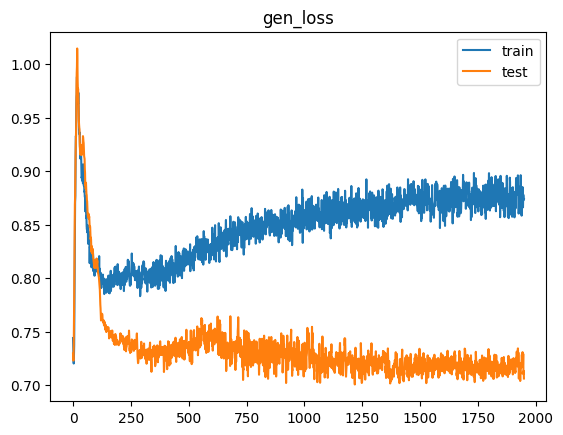

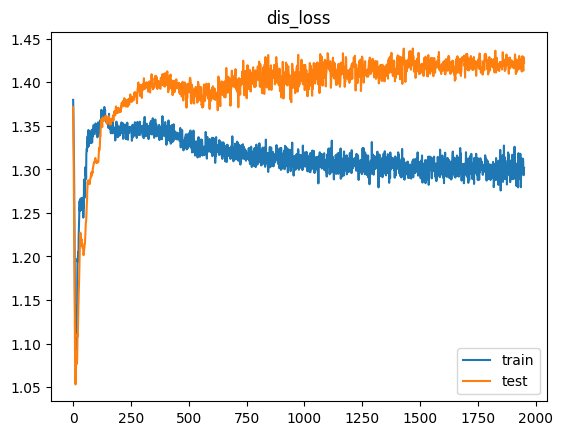

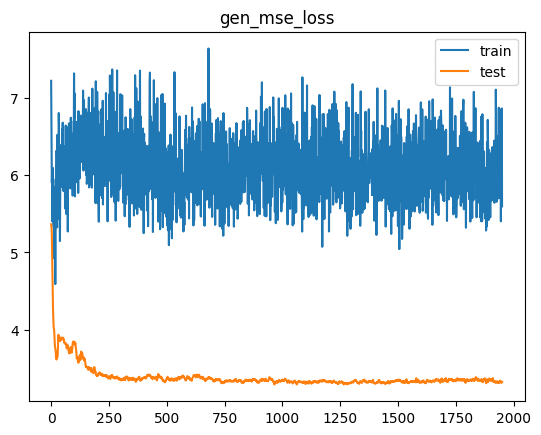

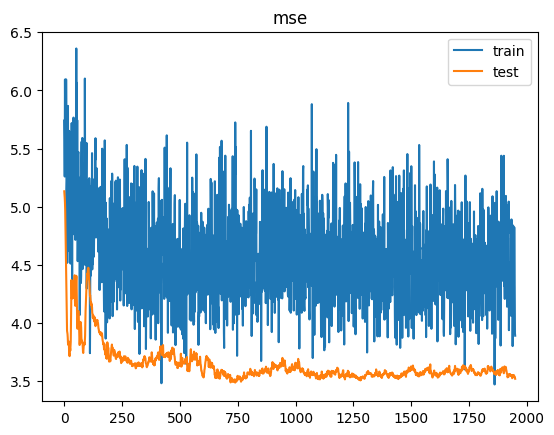

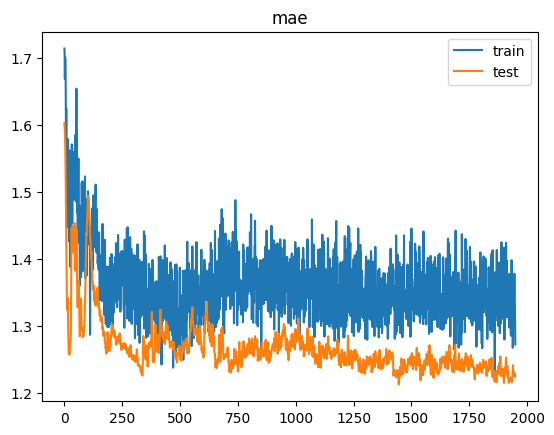

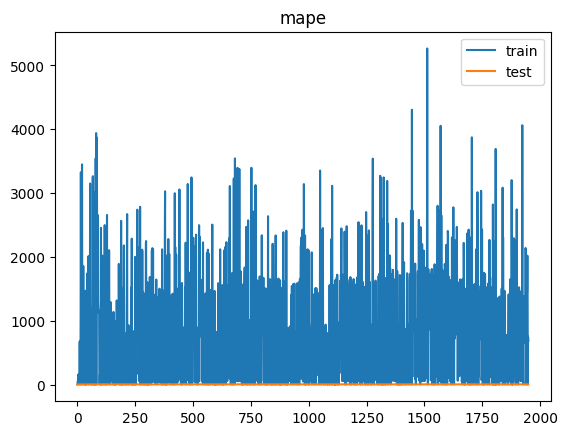

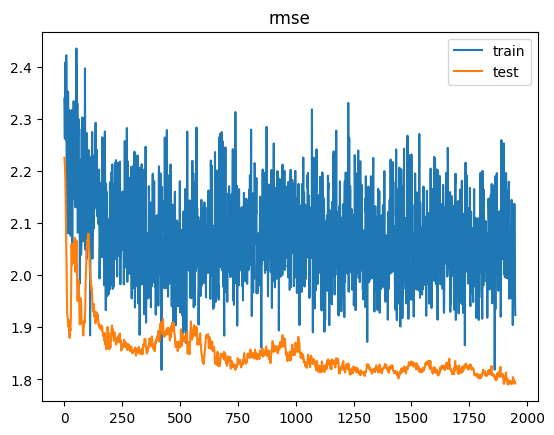

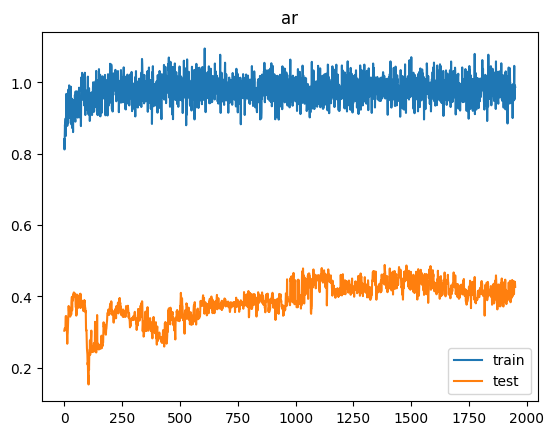

2/2 [==============================] - 1s 4ms/step


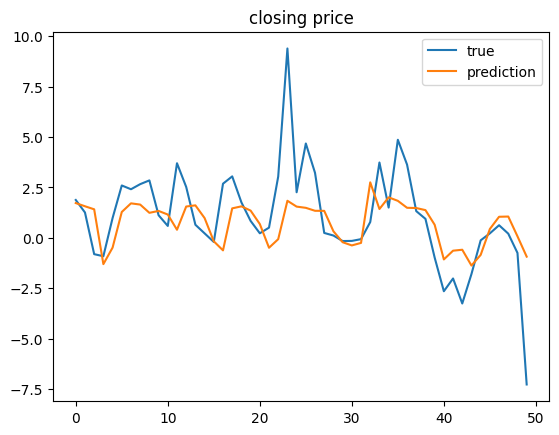

[MSE Baseline] train: 3.722489492167136  test: 3.634052838095099
Delta time with epochs = 1950: 0:19:58.176689


In [21]:
for epochs in [1950]:
    start_time = datetime.datetime.now()
    df = add_Ma(df)
    data_gen_train, data_gen_test = get_gen_train_test(df, n_sequence, n_batch)

    generator = make_generator_model(n_sequence, n_features)
    discriminator=make_discriminator_model(n_features)

    learning_rate=1e-4
    generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

    @tf.function
    def train_step(sequences, sequences_end):
      return train_step_def(sequences, sequences_end)

    @tf.function
    def test_step(sequences, sequences_end):
      return test_step_def(sequences, sequences_end)

    checkpoint_dir = './training_checkpoints'+stock_code
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                     discriminator_optimizer=discriminator_optimizer,
                                     generator=generator,
                                     discriminator=discriminator)

    history, history_val = train(data_gen_train, data_gen_test, epochs)

    plot_history(history, history_val)
    plot_frame(*data_gen_test[0], generator)

    print("[MSE Baseline] train:",mean_squared_error(data_gen_train)," test:", mean_squared_error(data_gen_test))
    now = datetime.datetime.now()
    delta = now - start_time
    print("Delta time with epochs = {0}:".format(epochs), delta)
    generator.save("dcbilstm_ffnn_epochs_{0}.h5".format(epochs))